<a href="https://colab.research.google.com/github/susmitsingh01/vllm-serving-performance-lab/blob/main/Copy_of_vllm_serving_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT: Diagnosing the latency–throughput tradeoff in vLLM serving under concurrent loads


- **Experiment 1:** Baseline setup and workload harness for mixed prompt-length serving

- **Experiment 1.1:** Fix max-tokens and context-budget failures by adding dynamic `max_tokens` to prevent request rejections

- **Experiment 2:** BAD (unfair) scheduling characterization with concurrency sweeps to expose head-of-line blocking and tail-latency spikes

- **Experiment 3:** Tail latency and throughput variation with concurrency sweep by holding workload and output length constant to isolate scheduling effects

- **Experiment 4:** Sweep of concurrency and `max-num-seqs` under a deliberately bad configuration to map scaling limits, queueing onset, and short request degradation from long-prefill contention

- **Experiment 5:** Find a strong FAIR scheduling configuration by first sweeping `max-num-batched-tokens` at lower concurrency (c=16), then validating at c=32, and finally running a `max-num-batched-tokens × max-num-seqs` grid at c=32 to pick a stable throughput vs tail-latency sweet spot

## Installing libraries

In [ ]:
!pip -q install datasets transformers
!pip -q install tqdm

!pip -q install "jedi>=0.16"
!pip -q install vllm

## Importing Libraries

In [ ]:
from google.colab import drive
import os

import json, random, statistics
from pathlib import Path
from datasets import load_dataset
from transformers import AutoTokenizer

import itertools

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import random

import vllm
import torch
from vllm import LLM, SamplingParams
import requests, time

import concurrent.futures as cf
import pandas as pd

import shutil
import math
import subprocess



## Mounting the Drive

In [ ]:
# Mounting Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Write locally first for faster write, then copy to Drive at the end
OUT_DIR = "/content/workloads"
os.makedirs(OUT_DIR, exist_ok=True)

# Where to persist outputs in Drive
DRIVE_OUT_DIR = "/content/drive/MyDrive/llm_loadtest_workloads"
os.makedirs(DRIVE_OUT_DIR, exist_ok=True)

print("OUT_DIR:", OUT_DIR)
print("DRIVE_OUT_DIR:", DRIVE_OUT_DIR)


OUT_DIR: /content/workloads
DRIVE_OUT_DIR: /content/drive/MyDrive/llm_loadtest_workloads


In [ ]:
MODEL = "Qwen/Qwen2.5-3B-Instruct"
tok = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

def tok_len(text: str) -> int:
    return len(tok.encode(text, add_special_tokens=False))

def in_range(n, r):
    return r[0] <= n <= r[1]

random.seed(42)

SHORT_RANGE = (8, 24)        # NQ-friendly short prompts
MED_RANGE   = (128, 256)     # UltraChat-friendly medium prompts
LONG_RANGE  = (2048, 4096)   # long prompts via concatenation


# How many prompts you want in each bucket
WANT_SHORT  = 800
WANT_MEDIUM = 400
WANT_LONG   = 600

# Requests per workload file
TOTAL_REQS_PER_FILE = 400

print("Tokenizer loaded for:", MODEL)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Tokenizer loaded for: Qwen/Qwen2.5-3B-Instruct


## Function to enable Dataset Streaming

In [ ]:
def try_load_streaming(dataset_name, config_split_candidates):
    last_err = None

    for cfg, split in config_split_candidates:
        try:
            if cfg is None:
                ds = load_dataset(dataset_name, split=split, streaming=True)

            else:
                ds = load_dataset(dataset_name, cfg, split=split, streaming=True)
            print(f"Loaded {dataset_name} (config={cfg}, split={split})")

            return ds

        except Exception as e:
            last_err = e
            print(f"Failed {dataset_name} (config={cfg}, split={split}): {type(e).__name__}")

    raise RuntimeError(f"Could not load {dataset_name}. Last error: {last_err}")



In [ ]:
# streaming both the datasets
ultra_stream = try_load_streaming(
    "HuggingFaceH4/ultrachat_200k",
    config_split_candidates=[
        (None, "train_sft"),
        ("default", "train_sft"),
        ("default", "train"),
    ],
)

nq_stream = try_load_streaming(
    "natural_questions",
    config_split_candidates=[
        (None, "train"),
        ("default", "train"),
    ],
)


README.md: 0.00B [00:00, ?B/s]

Loaded HuggingFaceH4/ultrachat_200k (config=None, split=train_sft)


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/287 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/287 [00:00<?, ?it/s]

Loaded natural_questions (config=None, split=train)


## Check if the Dataset loaded properly

In [ ]:
ex = next(iter(nq_stream))
print("Keys:", ex.keys())
print("Sample:", {k: ex[k] for k in list(ex.keys())[:5]})

# clearing the output because it takes a lot of space in pdf version of notebook

In [ ]:
ex = next(iter(ultra_stream))
print("Keys:", ex.keys())
print("Sample:", {k: ex[k] for k in list(ex.keys())[:5]})

# clearing the output because it takes a lot of space in pdf version of notebook

## Functions to extract prompt from Dataset

In [ ]:
def ultrachat_user_text(ex):
    prompt = ex.get("prompt")
    if isinstance(prompt, str) and prompt.strip():
        return prompt.strip()

    # This is a fallback: scan the "messages" list for the first user turn
    msgs = ex.get("messages")
    if isinstance(msgs, list):
        for m in msgs:
            if not isinstance(m, dict):
                continue

            role = (m.get("role") or "").lower()
            content = m.get("content") or ""

            if role == "user" and isinstance(content, str) and content.strip():
                return content.strip()

    return None


def nq_question_text(ex):
    q = ex.get("question")
    if isinstance(q, dict):
        t = q.get("text")
        return t.strip() if isinstance(t, str) and t.strip() else None
    if isinstance(q, str):
        return q.strip() if q.strip() else None
    return None


## Create Small and Medum Buckets

In [ ]:
from tqdm import tqdm

def stream_bucket(
    stream,
    text_fn,
    want_n,
    token_range,
    max_read,
    desc,
    print_every=500,
    also_keep_pool=True,
):
    """
    Stream from a HF streaming dataset, extract text, collect:
      - bucket: texts in token_range until want_n
      - pool: all extracted texts (optional)
    """
    bucket = []
    pool = [] if also_keep_pool else None

    for i, ex in tqdm(enumerate(stream), total=max_read, desc=desc):
        if i >= max_read:
            break

        s = text_fn(ex)
        if not s:
            continue

        if also_keep_pool:
            pool.append(s)

        n = tok_len(s)
        if len(bucket) < want_n and in_range(n, token_range):
            bucket.append(s)

        if (i % print_every) == 0:
            tqdm.write(f"read={i:,}, {desc}_bucket={len(bucket)}")

        if len(bucket) >= want_n:
            break

    return bucket, pool


In [ ]:
MAX_NQ_READ = 50000

short_bucket, nq_pool = stream_bucket(
    stream=nq_stream,
    text_fn=nq_question_text,
    want_n=WANT_SHORT,
    token_range=SHORT_RANGE,
    max_read=MAX_NQ_READ,
    desc="short",
    print_every=200,   # keep your original cadence
    also_keep_pool=True,
)

print("short_bucket:", len(short_bucket))


short:   0%|          | 2/50000 [00:18<104:09:36,  7.50s/it]

read=0, short_bucket=1


short:   0%|          | 208/50000 [00:30<26:42, 31.07it/s]

read=200, short_bucket=201


short:   1%|          | 402/50000 [00:42<2:21:13,  5.85it/s]

read=400, short_bucket=401


short:   1%|          | 604/50000 [00:58<35:59, 22.88it/s]

read=600, short_bucket=601


short:   2%|▏         | 799/50000 [01:08<1:10:09, 11.69it/s]


short_bucket: 800


In [ ]:
MAX_ULTRA_READ = 200000

medium_bucket, ultra_pool = stream_bucket(
    stream=ultra_stream,
    text_fn=ultrachat_user_text,
    want_n=WANT_MEDIUM,
    token_range=MED_RANGE,
    max_read=MAX_ULTRA_READ,
    desc="medium",
    print_every=500,   # keep your original cadence
    also_keep_pool=True,
)

print("medium_bucket:", len(medium_bucket))

medium:   0%|          | 14/200000 [00:03<9:37:24,  5.77it/s] 

read=0, medium_bucket=0


medium:   0%|          | 528/200000 [00:04<10:42, 310.50it/s]

read=500, medium_bucket=51


medium:   1%|          | 1040/200000 [00:06<09:46, 339.40it/s]

read=1,000, medium_bucket=106


medium:   1%|          | 1537/200000 [00:08<12:04, 274.11it/s]

read=1,500, medium_bucket=158


medium:   1%|          | 2042/200000 [00:09<09:52, 334.10it/s]

read=2,000, medium_bucket=198


medium:   1%|▏         | 2543/200000 [00:11<10:07, 325.01it/s]

read=2,500, medium_bucket=252


medium:   2%|▏         | 3004/200000 [00:13<23:16, 141.10it/s]

read=3,000, medium_bucket=305


medium:   2%|▏         | 3614/200000 [00:19<07:18, 448.23it/s]

read=3,500, medium_bucket=355


medium:   2%|▏         | 3990/200000 [00:20<17:07, 190.85it/s]

medium_bucket: 400


## Create Large Bucket

In [ ]:
def build_long_prompt(target_tokens, rng, snippets_pool, max_unique_before_reset=2000):
    parts = []
    used = set()

    while True:
        idx = rng.randrange(len(snippets_pool))
        if idx in used:
            continue
        used.add(idx)

        parts.append(snippets_pool[idx].replace("\n", " ").strip())
        text = "\n\n".join(parts)

        if tok_len(text) >= target_tokens:
            break

        if len(used) > min(max_unique_before_reset, len(snippets_pool) - 1):
            used.clear()

    ids = tok.encode(text, add_special_tokens=False)[:target_tokens]
    return tok.decode(ids)

def build_long_bucket(
    want_n,
    token_range,
    snippets_pool,
    seed=123,
    desc="long",
    print_every=10,
):
    assert len(snippets_pool) > 0, "snippets_pool must not be empty"

    rng = random.Random(seed)
    bucket = []

    for j in tqdm(range(want_n), desc=f"Building {desc}"):
        target = rng.randint(token_range[0], token_range[1])
        lp = build_long_prompt(target, rng, snippets_pool)
        bucket.append(lp)

        if ((j + 1) % print_every) == 0:
            tqdm.write(f"built={j+1}/{want_n}, last_len={tok_len(lp)} tokens")

    return bucket


In [ ]:
snippets_pool = short_bucket + medium_bucket
long_bucket = build_long_bucket(
    want_n=WANT_LONG,
    token_range=LONG_RANGE,
    snippets_pool=snippets_pool,
    seed=123,
    desc="long",
    print_every=10,
)

print("long_bucket:", len(long_bucket))


Building long:   2%|▏         | 10/600 [00:02<03:26,  2.85it/s]

built=10/600, last_len=3366 tokens


Building long:   3%|▎         | 20/600 [00:06<03:07,  3.09it/s]

built=20/600, last_len=2955 tokens


Building long:   5%|▌         | 30/600 [00:11<05:48,  1.64it/s]

built=30/600, last_len=3380 tokens


Building long:   7%|▋         | 40/600 [00:17<07:19,  1.27it/s]

built=40/600, last_len=3161 tokens


Building long:   8%|▊         | 50/600 [00:25<07:18,  1.25it/s]

built=50/600, last_len=3393 tokens


Building long:  10%|█         | 60/600 [00:29<03:09,  2.86it/s]

built=60/600, last_len=2295 tokens


Building long:  12%|█▏        | 70/600 [00:32<02:16,  3.88it/s]

built=70/600, last_len=2631 tokens


Building long:  13%|█▎        | 80/600 [00:37<05:57,  1.45it/s]

built=80/600, last_len=3856 tokens


Building long:  15%|█▌        | 90/600 [00:41<02:56,  2.89it/s]

built=90/600, last_len=2146 tokens


Building long:  17%|█▋        | 100/600 [00:46<03:35,  2.32it/s]

built=100/600, last_len=2627 tokens


Building long:  18%|█▊        | 110/600 [00:52<06:05,  1.34it/s]

built=110/600, last_len=4031 tokens


Building long:  20%|██        | 120/600 [00:57<03:45,  2.13it/s]

built=120/600, last_len=3992 tokens


Building long:  22%|██▏       | 130/600 [01:01<02:43,  2.87it/s]

built=130/600, last_len=2305 tokens


Building long:  23%|██▎       | 140/600 [01:07<04:23,  1.75it/s]

built=140/600, last_len=3250 tokens


Building long:  25%|██▌       | 150/600 [01:11<03:04,  2.45it/s]

built=150/600, last_len=3441 tokens


Building long:  27%|██▋       | 160/600 [01:14<02:37,  2.80it/s]

built=160/600, last_len=3468 tokens


Building long:  28%|██▊       | 170/600 [01:17<02:08,  3.36it/s]

built=170/600, last_len=2441 tokens


Building long:  30%|███       | 180/600 [01:22<03:39,  1.91it/s]

built=180/600, last_len=3415 tokens


Building long:  32%|███▏      | 190/600 [01:29<03:24,  2.01it/s]

built=190/600, last_len=3169 tokens


Building long:  33%|███▎      | 200/600 [01:33<02:45,  2.42it/s]

built=200/600, last_len=2460 tokens


Building long:  35%|███▌      | 210/600 [01:38<02:26,  2.65it/s]

built=210/600, last_len=2945 tokens


Building long:  37%|███▋      | 220/600 [01:42<02:06,  3.01it/s]

built=220/600, last_len=3628 tokens


Building long:  38%|███▊      | 230/600 [01:51<06:17,  1.02s/it]

built=230/600, last_len=3228 tokens


Building long:  40%|████      | 240/600 [01:57<04:22,  1.37it/s]

built=240/600, last_len=3886 tokens


Building long:  42%|████▏     | 250/600 [02:09<06:26,  1.10s/it]

built=250/600, last_len=3225 tokens


Building long:  43%|████▎     | 260/600 [02:14<02:30,  2.26it/s]

built=260/600, last_len=3722 tokens


Building long:  45%|████▌     | 270/600 [02:19<02:49,  1.95it/s]

built=270/600, last_len=2643 tokens


Building long:  47%|████▋     | 280/600 [02:23<03:09,  1.69it/s]

built=280/600, last_len=4031 tokens


Building long:  48%|████▊     | 290/600 [02:39<09:20,  1.81s/it]

built=290/600, last_len=2986 tokens


Building long:  50%|█████     | 300/600 [02:45<03:48,  1.32it/s]

built=300/600, last_len=3837 tokens


Building long:  52%|█████▏    | 310/600 [02:57<04:38,  1.04it/s]

built=310/600, last_len=3470 tokens


Building long:  53%|█████▎    | 320/600 [03:08<04:19,  1.08it/s]

built=320/600, last_len=3117 tokens


Building long:  55%|█████▌    | 330/600 [03:16<04:41,  1.04s/it]

built=330/600, last_len=3086 tokens


Building long:  57%|█████▋    | 340/600 [03:23<02:40,  1.62it/s]

built=340/600, last_len=3688 tokens


Building long:  58%|█████▊    | 350/600 [03:29<03:55,  1.06it/s]

built=350/600, last_len=3755 tokens


Building long:  60%|██████    | 360/600 [03:39<03:56,  1.01it/s]

built=360/600, last_len=2462 tokens


Building long:  62%|██████▏   | 370/600 [03:44<02:14,  1.71it/s]

built=370/600, last_len=3850 tokens


Building long:  63%|██████▎   | 380/600 [03:57<04:01,  1.10s/it]

built=380/600, last_len=2184 tokens


Building long:  65%|██████▌   | 390/600 [04:02<01:47,  1.95it/s]

built=390/600, last_len=3645 tokens


Building long:  67%|██████▋   | 400/600 [04:09<02:21,  1.41it/s]

built=400/600, last_len=3122 tokens


Building long:  68%|██████▊   | 410/600 [04:15<02:58,  1.07it/s]

built=410/600, last_len=3959 tokens


Building long:  70%|███████   | 420/600 [04:27<02:44,  1.09it/s]

built=420/600, last_len=3146 tokens


Building long:  72%|███████▏  | 430/600 [04:31<01:41,  1.68it/s]

built=430/600, last_len=3866 tokens


Building long:  73%|███████▎  | 440/600 [04:38<01:38,  1.62it/s]

built=440/600, last_len=3164 tokens


Building long:  75%|███████▌  | 450/600 [04:45<02:02,  1.22it/s]

built=450/600, last_len=3925 tokens


Building long:  77%|███████▋  | 460/600 [04:51<01:14,  1.88it/s]

built=460/600, last_len=3569 tokens


Building long:  78%|███████▊  | 470/600 [04:57<01:39,  1.31it/s]

built=470/600, last_len=3912 tokens


Building long:  80%|████████  | 480/600 [05:03<01:08,  1.76it/s]

built=480/600, last_len=3028 tokens


Building long:  82%|████████▏ | 490/600 [05:07<00:38,  2.87it/s]

built=490/600, last_len=2081 tokens


Building long:  83%|████████▎ | 500/600 [05:10<00:38,  2.61it/s]

built=500/600, last_len=2345 tokens


Building long:  85%|████████▌ | 510/600 [05:22<01:22,  1.09it/s]

built=510/600, last_len=2541 tokens


Building long:  87%|████████▋ | 520/600 [05:34<01:55,  1.44s/it]

built=520/600, last_len=2754 tokens


Building long:  88%|████████▊ | 530/600 [05:48<02:32,  2.17s/it]

built=530/600, last_len=3959 tokens


Building long:  90%|█████████ | 540/600 [05:58<01:14,  1.24s/it]

built=540/600, last_len=3576 tokens


Building long:  92%|█████████▏| 550/600 [06:09<00:30,  1.62it/s]

built=550/600, last_len=2163 tokens


Building long:  93%|█████████▎| 560/600 [06:21<00:43,  1.09s/it]

built=560/600, last_len=2606 tokens


Building long:  95%|█████████▌| 570/600 [06:33<00:53,  1.78s/it]

built=570/600, last_len=3850 tokens


Building long:  97%|█████████▋| 580/600 [06:39<00:09,  2.12it/s]

built=580/600, last_len=3674 tokens


Building long:  98%|█████████▊| 590/600 [06:42<00:03,  2.52it/s]

built=590/600, last_len=3438 tokens


Building long: 100%|██████████| 600/600 [06:48<00:00,  1.47it/s]

built=600/600, last_len=2664 tokens
long_bucket: 600


## Create Mixed Buckets

In [ ]:

from tqdm.auto import tqdm

TOTAL_REQS_PER_FILE = 400
SEED = 999

OVERWRITE_LOCAL = False
OVERWRITE_DRIVE = False

ENABLE_LONG_HEAVY = True
HEAVY_LONG_RANGE = (3500, 4096)
WANT_LONG_HEAVY = 600
USE_LONG_HEAVY_FOR = {"mix_60_40.jsonl", "mix_50_50.jsonl"}

MIX_SPECS = {
    "short_only.jsonl":     {"short": 1.0},
    "medium_only.jsonl":    {"medium": 1.0},
    "long_only.jsonl":      {"long": 1.0},

    "mix_90_10.jsonl":      {"short": 0.9, "long": 0.1},
    "mix_70_30.jsonl":      {"short": 0.7, "long": 0.3},
    "mix_70_20_10.jsonl":   {"short": 0.7, "medium": 0.2, "long": 0.1},

    # these use long heavy
    "mix_60_40.jsonl":      {"short": 0.6, "long": 0.4},
    "mix_50_50.jsonl":      {"short": 0.5, "long": 0.5},
}

assert "tok" in globals(), "Tokenizer 'tok' not found."
assert "short_bucket" in globals() and len(short_bucket) > 0, "short_bucket missing/empty."
assert "medium_bucket" in globals() and len(medium_bucket) > 0, "medium_bucket missing/empty."
assert "long_bucket" in globals() and len(long_bucket) > 0, "long_bucket missing/empty."


def tok_len(text: str) -> int:
    return len(tok.encode(text, add_special_tokens=False))


def build_long_prompt(target_tokens, rng, snippets_pool):
    parts = []
    used = set()
    while True:
        idx = rng.randrange(len(snippets_pool))
        if idx in used:
            continue
        used.add(idx)

        parts.append(snippets_pool[idx].replace("\n", " ").strip())
        text = "\n\n".join(parts)

        if tok_len(text) >= target_tokens:
            break

        if len(used) > min(2000, len(snippets_pool) - 1):
            used.clear()

    ids = tok.encode(text, add_special_tokens=False)[:target_tokens]
    return tok.decode(ids)


def build_long_bucket(want_n, token_range, snippets_pool, seed=1234, desc="long_bucket"):
    rng = random.Random(seed)
    bucket = []

    for _ in tqdm(range(want_n), desc=f"Building {desc} {token_range}"):
        target = rng.randint(token_range[0], token_range[1])
        bucket.append(build_long_prompt(target, rng, snippets_pool))

    return bucket


long_heavy_bucket = None
if ENABLE_LONG_HEAVY and len(USE_LONG_HEAVY_FOR) > 0:
    snippets_pool = short_bucket + medium_bucket
    long_heavy_bucket = build_long_bucket(
        want_n=WANT_LONG_HEAVY,
        token_range=HEAVY_LONG_RANGE,
        snippets_pool=snippets_pool,
        seed=1234,
        desc="long_heavy_bucket",
    )

    print(
        "long_heavy_bucket:",
        len(long_heavy_bucket),
        "example_len_tokens:",
        tok_len(long_heavy_bucket[0]),
    )

def write_jsonl(path, prompts, max_tokens=128, temperature=0.0):
    with open(path, "w", encoding="utf-8") as f:
        for p in prompts:
            row = {
                "messages": [{"role": "user", "content": p}],
                "max_tokens": max_tokens,
                "temperature": temperature,
            }
            f.write(json.dumps(row) + "\n")


def sample_prompts(bucket, k, rng):
    if k <= 0:
        return []
    if len(bucket) < k:
        raise ValueError(f"Bucket too small: need {k}, have {len(bucket)}")
    return rng.sample(bucket, k)


def normalize_ratios(ratios: dict) -> dict:
    r = dict(ratios)
    s = float(r.get("short", 0.0))
    m = float(r.get("medium", 0.0))
    l = float(r.get("long", 0.0))
    total = s + m + l

    if total > 1.000001:
        raise ValueError(f"Ratios sum > 1.0: {ratios}")

    if "long" not in r:
        r["long"] = 1.0 - (s + m)

    return r

def make_mix(total, ratios, rng, short_b, medium_b, long_b):
    ratios = normalize_ratios(ratios)
    k_short  = int(total * ratios.get("short", 0))
    k_medium = int(total * ratios.get("medium", 0))
    k_long   = total - k_short - k_medium

    prompts = []
    prompts += sample_prompts(short_b,  k_short,  rng)
    prompts += sample_prompts(medium_b, k_medium, rng)
    prompts += sample_prompts(long_b,   k_long,   rng)

    rng.shuffle(prompts)

    return prompts

def should_write(path, overwrite=False):
    return overwrite or (not os.path.exists(path))


def safe_copy(local_path, drive_path, overwrite=False):
    if not overwrite and os.path.exists(drive_path):
        return False

    shutil.copy(local_path, drive_path)

    return True

rng = random.Random(SEED)

written = []
skipped = []

for fn, ratios in MIX_SPECS.items():
    local_path = os.path.join(OUT_DIR, fn)
    drive_path = os.path.join(DRIVE_OUT_DIR, fn)

    if (not OVERWRITE_LOCAL) and os.path.exists(local_path) and (not OVERWRITE_DRIVE) and os.path.exists(drive_path):
        skipped.append(fn)
        continue

    use_heavy = (fn in USE_LONG_HEAVY_FOR) and (long_heavy_bucket is not None)
    long_source = long_heavy_bucket if use_heavy else long_bucket

    prompts = make_mix(
        total=TOTAL_REQS_PER_FILE,
        ratios=ratios,
        rng=rng,
        short_b=short_bucket,
        medium_b=medium_bucket,
        long_b=long_source,
    )

    if should_write(local_path, overwrite=OVERWRITE_LOCAL):
        write_jsonl(local_path, prompts)
    else:
        skipped.append(fn)
        continue

    copied = safe_copy(local_path, drive_path, overwrite=OVERWRITE_DRIVE)
    if not copied:
        print("Exists on Drive, skipping copy:", drive_path)

    written.append(fn)

print("Done.")
print("Written:", written)
print("Skipped:", skipped)
print("Local dir:", OUT_DIR)
print("Drive dir:", DRIVE_OUT_DIR)


Building long_heavy_bucket (3500, 4096):   0%|          | 0/600 [00:00<?, ?it/s]

long_heavy_bucket: 600 example_len_tokens: 3951
Exists on Drive, skipping copy: /content/drive/MyDrive/llm_loadtest_workloads/short_only.jsonl
Exists on Drive, skipping copy: /content/drive/MyDrive/llm_loadtest_workloads/medium_only.jsonl
Exists on Drive, skipping copy: /content/drive/MyDrive/llm_loadtest_workloads/long_only.jsonl
Exists on Drive, skipping copy: /content/drive/MyDrive/llm_loadtest_workloads/mix_90_10.jsonl
Exists on Drive, skipping copy: /content/drive/MyDrive/llm_loadtest_workloads/mix_70_30.jsonl
Exists on Drive, skipping copy: /content/drive/MyDrive/llm_loadtest_workloads/mix_70_20_10.jsonl
Exists on Drive, skipping copy: /content/drive/MyDrive/llm_loadtest_workloads/mix_60_40.jsonl
Exists on Drive, skipping copy: /content/drive/MyDrive/llm_loadtest_workloads/mix_50_50.jsonl
Done.
Written: ['short_only.jsonl', 'medium_only.jsonl', 'long_only.jsonl', 'mix_90_10.jsonl', 'mix_70_30.jsonl', 'mix_70_20_10.jsonl', 'mix_60_40.jsonl', 'mix_50_50.jsonl']
Skipped: []
Local di

In [ ]:
WORKLOAD_DIR = "/content/workloads"
FILES = sorted([f for f in os.listdir(WORKLOAD_DIR) if f.endswith(".jsonl")])


def tok_len(text: str) -> int:
    return len(tok.encode(text, add_special_tokens=False))

def read_jsonl(path: str):
    rows = []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue

            rows.append(json.loads(line))

    return rows

def extract_prompt(row: dict) -> str:
    msgs = row.get("messages", [])

    if isinstance(msgs, list) and len(msgs) > 0 and isinstance(msgs[0], dict):
        return (msgs[0].get("content") or "").strip()

    return ""

def stats(arr):
    arr = np.array(arr, dtype=float)

    if len(arr) == 0:
        return {}

    return {
        "n": int(len(arr)),
        "min": float(np.min(arr)),
        "p50": float(np.percentile(arr, 50)),
        "p90": float(np.percentile(arr, 90)),
        "p95": float(np.percentile(arr, 95)),
        "p99": float(np.percentile(arr, 99)),
        "max": float(np.max(arr)),
        "mean": float(np.mean(arr)),
    }

results = []
per_file_details = {}

for fn in tqdm(FILES, desc="Verifying workload JSONLs"):
    path = os.path.join(WORKLOAD_DIR, fn)
    rows = read_jsonl(path)

    prompts = [extract_prompt(r) for r in rows]
    prompts = [p for p in prompts if p]  # drop empties

    tok_lens = [tok_len(p) for p in prompts]
    char_lens = [len(p) for p in prompts]

    s_tok = stats(tok_lens)
    s_chr = stats(char_lens)

    results.append({
        "file": fn,
        "n": s_tok.get("n", 0),
        "tok_min": s_tok.get("min"),
        "tok_p50": s_tok.get("p50"),
        "tok_p90": s_tok.get("p90"),
        "tok_p95": s_tok.get("p95"),
        "tok_p99": s_tok.get("p99"),
        "tok_max": s_tok.get("max"),
        "tok_mean": s_tok.get("mean"),
        "char_p50": s_chr.get("p50"),
        "char_p99": s_chr.get("p99"),
    })

    # store some examples for sanity checks
    if len(tok_lens) > 0:
        idx_sorted = np.argsort(tok_lens)
        smallest = idx_sorted[:2].tolist()
        largest = idx_sorted[-2:].tolist()
        per_file_details[fn] = {
            "smallest_examples": [(tok_lens[i], prompts[i][:200]) for i in smallest],
            "largest_examples": [(tok_lens[i], prompts[i][:200]) for i in largest],
        }

df_stats = pd.DataFrame(results).sort_values("file")
display(df_stats)

print("\n--- Sanity samples (first 200 chars) ---")
for fn, det in per_file_details.items():
    print(f"\n### {fn}")
    print("Smallest:")
    for L, s in det["smallest_examples"]:
        print(f"  tok={L} | {s!r}")
    print("Largest:")
    for L, s in det["largest_examples"]:
        print(f"  tok={L} | {s!r}")


Verifying workload JSONLs:   0%|          | 0/8 [00:00<?, ?it/s]

file    n  tok_min  tok_p50  tok_p90  tok_p95  tok_p99  \
0     long_only.jsonl  400   2051.0   3068.5   3931.1  4028.10  4083.01   
1   medium_only.jsonl  400    128.0    169.0    231.1   240.05   253.00   
2     mix_50_50.jsonl  400      8.0   1761.0   4018.1  4062.10  4090.02   
3     mix_60_40.jsonl  400      8.0     12.5   3983.1  4042.10  4089.01   
4  mix_70_20_10.jsonl  400      8.0     11.0    432.9  3189.05  3898.31   
5     mix_70_30.jsonl  400      8.0     11.0   3525.5  3852.10  4070.13   
6     mix_90_10.jsonl  400      8.0     10.0    239.1  3332.80  3887.60   
7    short_only.jsonl  400      8.0     10.0     14.0    15.00    19.01   

   tok_max   tok_mean  char_p50  char_p99  
0   4092.0  3061.0350   14489.5  19827.18  
1    256.0   175.9325     819.0   1378.01  
2   4096.0  1918.2400    7905.0  19973.59  
3   4095.0  1532.5800      56.0  19942.21  
4   4090.0   357.9650      49.5  18275.65  
5   4092.0   939.5800      50.0  19346.25  
6   4090.0   334.2300      46.0  18965.18  
7     23.0    10.5925      45.0     88.01


--- Sanity samples (first 200 chars) ---

### long_only.jsonl
Smallest:
  tok=2051 | 'who wrote the song come thou fount of every blessing\n\nCan you summarize the setting and atmosphere at Sue Ann Staff Estate Winery Weddings? Answer according to: Surrounded by lush vineyards and perche'
  tok=2058 | 'Write a fast-paced, plot-driven thriller novel that chronicles the story of a young woman abducted by a notoriously insidious serial killer. The narrative style should be highly tense and suspenseful,'
Largest:
  tok=4090 | "elvis presley daddy don't you walk so fast\n\nhow old do you have to be to get a tattoo in utah\n\nbruce lee hall of mirrors enter the dragon\n\nWrite a 75,000-word historical romance novel set during the H"
  tok=4092 | 'when was the last time a total eclipse happened\n\nWrite a detailed report that analyzes and summarizes the various ways in which technology has influenced and transformed the manufacturing industry. Yo'

### medium_only.jsonl
Smallest:
  tok=128 |

# Setting up vLLM server and Dataset loading

In [ ]:
print("vLLM:", vllm.__version__)
print("torch:", torch.__version__, "cuda:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0))

vLLM: 0.13.0
torch: 2.9.0+cu126 cuda: 12.6
GPU: NVIDIA L4


In [ ]:
# Use this cell, when restarting the Server again in the same runtime
# it clears out the previous instances prevents issues in server setup

!pkill -f "vllm.entrypoints.openai.api_server" || true
!pkill -f "EngineCore" || true
!pkill -f "vllm" || true


^C
^C
^C


In [ ]:
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"
PORT = 8000

MAX_MODEL_LEN = 4096
GPU_UTIL = 0.70
DTYPE = "half"              # fp16 weights/compute

# Launch server
# run it in the background and log to a file.
cmd = f"""
nohup python3 -m vllm.entrypoints.openai.api_server \
  --model {MODEL_ID} \
  --host 127.0.0.1 \
  --port {PORT} \
  --max-model-len {MAX_MODEL_LEN} \
  --gpu-memory-utilization {GPU_UTIL} \
  --dtype {DTYPE} \
  --enforce-eager \
  --disable-log-stats \
  > vllm_server.log 2>&1 &
"""

print("Launching vLLM server...")
!bash -lc "$cmd"

print("Server process launched. Showing last 30 log lines:")
!tail -n 30 vllm_server.log


Launching vLLM server...
Server process launched. Showing last 30 log lines:


## Function to check the successful startup of the server

In [ ]:
import time, requests

BASE = "http://127.0.0.1:8000"

def wait_for_server(timeout_s=600):
    t0 = time.time()
    while time.time() - t0 < timeout_s:
        try:
            r = requests.get(f"{BASE}/v1/models", timeout=2)
            if r.status_code == 200:
                return True, r.json()
        except Exception:
            pass
        time.sleep(2)
    return False, None

ok, payload = wait_for_server()
print("Ready:", ok)
if ok:
    print("Models:", [m["id"] for m in payload.get("data", [])])
else:
    print("Not ready yet. Check logs:")
    !tail -n 60 vllm_server.log


Ready: True
Models: ['Qwen/Qwen2.5-3B-Instruct']


In [ ]:
# Server take almost a minute to start,
# keep checking the logs to confirm successful startup
# before running any experiments

!tail -n 200 vllm_server.log


2026-01-11 19:14:50.463943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768158890.485170    3519 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768158890.491587    3519 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768158890.507836    3519 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768158890.507865    3519 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768158890.507868    3519 computation_placer.cc:177] computation placer alr

## Sanity check after Server start

In [ ]:
import requests, json

BASE="http://127.0.0.1:8000"

payload = {
  "model": "Qwen/Qwen2.5-3B-Instruct",
  "messages": [{"role":"user","content":"Say hi in one sentence."}],
  "max_tokens": 32,
  "temperature": 0.0
}

r = requests.post(f"{BASE}/v1/chat/completions", json=payload, timeout=120)
print(r.status_code)
print(r.json()["choices"][0]["message"]["content"])


200
Hi there! How can I assist you today?


In [ ]:
# check the GPU consumption once the vLLM server is up
! nvidia-smi

Sun Jan 11 19:55:23 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   56C    P0             30W /   72W |   16225MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load the dataset and run tests


In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the dataset from Drive

In [ ]:
import json, os, random
from pathlib import Path

PROMPT_DIR = Path("/content/drive/MyDrive/llm_loadtest_workloads")

FILES = [
    "short_only.jsonl",
    "medium_only.jsonl",
    "long_only.jsonl",
    "mix_90_10.jsonl",
    "mix_70_30.jsonl",
    "mix_70_20_10.jsonl",
    "mix_60_40.jsonl",
    "mix_50_50.jsonl"
]

def load_jsonl_prompts(path: Path, limit=None, seed=123):
    prompts = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)

            if "prompt" in obj:
                prompts.append(obj["prompt"])

            elif "messages" in obj:
                users = [m["content"] for m in obj["messages"] if m.get("role") == "user"]

                if users:
                    prompts.append(users[-1])

            if limit and len(prompts) >= limit:
                break

    random.Random(seed).shuffle(prompts)
    return prompts

prompt_sets = {}
for fn in FILES:
    p = PROMPT_DIR / fn
    if p.exists():
        prompt_sets[fn] = load_jsonl_prompts(p)
        print(f"Loaded {fn}: {len(prompt_sets[fn])} prompts")
    else:
        print(f"Missing: {p}")


Loaded short_only.jsonl: 400 prompts
Loaded medium_only.jsonl: 400 prompts
Loaded long_only.jsonl: 400 prompts
Loaded mix_90_10.jsonl: 400 prompts
Loaded mix_70_30.jsonl: 400 prompts
Loaded mix_70_20_10.jsonl: 400 prompts
Loaded mix_60_40.jsonl: 400 prompts
Loaded mix_50_50.jsonl: 400 prompts


## Checking if the dataset is properly read

In [ ]:
from transformers import AutoTokenizer
import numpy as np, random

TOK_MODEL = "Qwen/Qwen2.5-3B-Instruct"
tok = AutoTokenizer.from_pretrained(TOK_MODEL, use_fast=True)

def tok_len(s: str) -> int:
    return len(tok.encode(s, add_special_tokens=False))

def summarize_lengths(name, prompts, n=200):
    sample = random.sample(prompts, min(n, len(prompts)))
    lens = np.array([tok_len(p) for p in sample])
    print(f"{name:18s}  n={len(sample):4d}  min={lens.min():4d}  p50={int(np.median(lens)):4d}  p90={int(np.quantile(lens,0.9)):4d}  p99={int(np.quantile(lens,0.99)):4d}  max={lens.max():4d}")

for fn, prompts in prompt_sets.items():
    summarize_lengths(fn, prompts)


short_only.jsonl    n= 200  min=   8  p50=  10  p90=  13  p99=  16  max=  16
medium_only.jsonl   n= 200  min= 128  p50= 166  p90= 230  p99= 246  max= 255
long_only.jsonl     n= 200  min=2051  p50=3196  p90=3949  p99=4062  max=4093
mix_90_10.jsonl     n= 200  min=   8  p50=  10  p90=2319  p99=3944  max=4002
mix_70_30.jsonl     n= 200  min=   8  p50=  11  p90=3312  p99=3924  max=4031
mix_70_20_10.jsonl  n= 200  min=   8  p50=  11  p90= 231  p99=3660  max=3833
mix_60_40.jsonl     n= 200  min=   8  p50=  12  p90=3970  p99=4082  max=4090
mix_50_50.jsonl     n= 200  min=   8  p50=3510  p90=4002  p99=4084  max=4096


##

# Experiment 1

In this experiment, we stress-test vLLM serving under mixed prompt-length workloads to reproduce two real-world issues:

(1) context-budget failures where long prompts combined with a fixed max_tokens cause requests to error out (HTTP 400 max token limit), and

(2) degraded serving performance as the fraction of long prompts increases. We run controlled workloads (short-only and mixed ratios like 90/10 and 70/30), then compare success rate, throughput (RPS), and latency metrics (p50/p90/p99) to quantify how long prompts amplify tail latency and reduce effective throughput.

This sets up the next experiments where we mitigate the failure mode (dynamic max_tokens / context budgeting) and run experiments to see how can we configure our servers to perform better under mixed loads.






## Single-Request Client Helper (Latency + Token Usage)

In [ ]:
import time, requests

BASE = "http://127.0.0.1:8000"
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"

def one_request(prompt, max_tokens=128, temperature=0.0, timeout=120):
    t0 = time.perf_counter()
    payload = {
        "model": MODEL_ID,
        "messages": [{"role": "user", "content": prompt}],
        "max_tokens": max_tokens,
        "temperature": temperature,
    }

    r = requests.post(f"{BASE}/v1/chat/completions", json=payload, timeout=timeout)

    latency = time.perf_counter() - t0

    # Hard fail with useful error
    if r.status_code != 200:
        txt = r.text[:500]
        raise RuntimeError(f"HTTP {r.status_code}: {txt}")

    j = r.json()
    usage = j.get("usage", {})
    return {
        "latency_s": latency,
        "prompt_tokens": usage.get("prompt_tokens"),
        "completion_tokens": usage.get("completion_tokens"),
        "total_tokens": usage.get("total_tokens"),
        "status_code": r.status_code,
    }


## Some checks before starting the experiment

In [ ]:
# Is the server process actually running?
!ps aux | grep -E "vllm\.entrypoints\.openai\.api_server|api_server" | grep -v grep

# Is anything listening on port 8000, and which process owns it?
!ss -ltnp | grep ":8000" || true

# What did the server log say most recently?
!tail -n 80 vllm_server.log || true


print(requests.get("http://127.0.0.1:8000/v1/models").status_code)
print(requests.get("http://127.0.0.1:8000/v1/models").json())

root        3519  0.6  3.1 14040592 1743404 ?    Sl   19:14   0:24 python3 -m vllm.entrypoints.openai.api_server --model Qwen/Qwen2.5-3B-Instruct --host 127.0.0.1 --port 8000 --max-model-len 4096 --gpu-memory-utilization 0.7 --dtype half --enforce-eager --disable-log-stats
LISTEN 0      2048       127.0.0.1:8000       0.0.0.0:*    users:(("python3",pid=3519,fd=33))        
(APIServer pid=3519) INFO 01-11 19:14:59 [model.py:1661] Using max model len 4096
(APIServer pid=3519) INFO 01-11 19:15:00 [scheduler.py:230] Chunked prefill is enabled with max_num_batched_tokens=2048.
(APIServer pid=3519) WARNING 01-11 19:15:00 [vllm.py:622] Enforce eager set, overriding optimization level to -O0
(APIServer pid=3519) INFO 01-11 19:15:00 [vllm.py:722] Cudagraph is disabled under eager mode
2026-01-11 19:15:08.298361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E00

## Server Health Check + Verify vLLM OpenAI Endpoint Is Working

In [ ]:
import requests, json

BASE = "http://127.0.0.1:8000"
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"

payload = {
    "model": MODEL_ID,
    "messages": [{"role": "user", "content": "Say hello in one sentence."}],
    "max_tokens": 32,
    "temperature": 0.0,
}

r = requests.post(f"{BASE}/v1/chat/completions", json=payload, timeout=120)
print("status:", r.status_code)
print("text:", r.text[:400])


status: 200
text: {"id":"chatcmpl-bc2f4e8695ca898b","object":"chat.completion","created":1768163326,"model":"Qwen/Qwen2.5-3B-Instruct","choices":[{"index":0,"message":{"role":"assistant","content":"Hello! How can I assist you today?","refusal":null,"annotations":null,"audio":null,"function_call":null,"tool_calls":[],"reasoning":null,"reasoning_content":null},"logprobs":null,"finish_reason":"stop","stop_reason":null


## Single-Request Sanity Check (Real Workload Prompt)

In [ ]:
test_prompt = prompt_sets["short_only.jsonl"][0]
print("prompt tokens (rough chars):", len(test_prompt))

out = one_request(test_prompt, max_tokens=32)
print(out)


prompt tokens (rough chars): 49
{'latency_s': 0.8831302409998898, 'prompt_tokens': 39, 'completion_tokens': 32, 'total_tokens': 71, 'status_code': 200}


## Client-Side Load Generator (ThreadPool) + Latency/RPS Summary

In [ ]:
def run_load(prompts, concurrency=8, total_requests=200, max_tokens=128, desc="load"):
    rng = random.Random(123)
    picked = [rng.choice(prompts) for _ in range(total_requests)]

    results = []
    t_start = time.perf_counter()

    def task(i):
        p = picked[i]
        try:
            res = one_request(p, max_tokens=max_tokens)
            res["ok"] = True
        except Exception as e:
            res = {"ok": False, "error": str(e), "latency_s": None,
                   "prompt_tokens": None, "completion_tokens": None, "total_tokens": None}
        return res

    ok_ct = 0
    fail_ct = 0

    with cf.ThreadPoolExecutor(max_workers=concurrency) as ex:
        futs = [ex.submit(task, i) for i in range(total_requests)]

        pbar = tqdm(total=total_requests, desc=desc)
        for f in cf.as_completed(futs):
            r = f.result()
            results.append(r)
            if r.get("ok"):
                ok_ct += 1
            else:
                fail_ct += 1
            pbar.update(1)
            pbar.set_postfix(ok=ok_ct, fail=fail_ct)
        pbar.close()

    t_end = time.perf_counter()

    df = pd.DataFrame(results)
    ok_df = df[df["ok"] == True].copy()

    summary = {
        "concurrency": concurrency,
        "total_requests": total_requests,
        "ok": int(ok_df.shape[0]),
        "fail": int(df.shape[0] - ok_df.shape[0]),
        "wall_time_s": t_end - t_start,
        "rps": ok_df.shape[0] / (t_end - t_start) if (t_end - t_start) > 0 else None,
        "p50_s": float(ok_df["latency_s"].quantile(0.50)) if len(ok_df) else None,
        "p90_s": float(ok_df["latency_s"].quantile(0.90)) if len(ok_df) else None,
        "p99_s": float(ok_df["latency_s"].quantile(0.99)) if len(ok_df) else None,
        "mean_s": float(ok_df["latency_s"].mean()) if len(ok_df) else None,
    }
    return df, summary


## Reproducing Context-Length Failures Under Load (Max Token Limit)

In [ ]:
workloads = [
    ("short_only", "short_only.jsonl"),
    ("mix_90_10", "mix_90_10.jsonl"),
    ("mix_70_30", "mix_70_30.jsonl"),
]

all_summaries = []
all_dfs = {}

for name, fn in tqdm(workloads, desc="Workloads"):
    print("\nRunning:", name)
    df, summ = run_load(
        prompt_sets[fn],
        concurrency=8,
        total_requests=200,
        max_tokens=128,
        desc=f"{name} (c=8)"
    )
    all_dfs[name] = df
    all_summaries.append({"workload": name, **summ})
    print(summ)

summary_df = pd.DataFrame(all_summaries)
summary_df


Workloads:   0%|          | 0/3 [00:00<?, ?it/s]


Running: short_only


short_only (c=8):   0%|          | 0/200 [00:00<?, ?it/s]

{'concurrency': 8, 'total_requests': 200, 'ok': 200, 'fail': 0, 'wall_time_s': 79.18587238500186, 'rps': 2.5257030575807717, 'p50_s': 3.553790949499671, 'p90_s': 3.5761803588007752, 'p99_s': 3.5867652782488584, 'mean_s': 3.104981383839822}

Running: mix_90_10


mix_90_10 (c=8):   0%|          | 0/200 [00:00<?, ?it/s]

{'concurrency': 8, 'total_requests': 200, 'ok': 198, 'fail': 2, 'wall_time_s': 86.622785784999, 'rps': 2.2857727121757945, 'p50_s': 3.6156531919987174, 'p90_s': 4.1372710210980586, 'p99_s': 4.528918918627678, 'mean_s': 3.433755588661609}

Running: mix_70_30


mix_70_30 (c=8):   0%|          | 0/200 [00:00<?, ?it/s]

{'concurrency': 8, 'total_requests': 200, 'ok': 195, 'fail': 5, 'wall_time_s': 99.59230680399924, 'rps': 1.9579825616828626, 'p50_s': 4.101179446999595, 'p90_s': 4.894588489399757, 'p99_s': 5.37605518930228, 'mean_s': 4.054637723287175}


workload  concurrency  total_requests   ok  fail  wall_time_s       rps  \
0  short_only            8             200  200     0    79.185872  2.525703   
1   mix_90_10            8             200  198     2    86.622786  2.285773   
2   mix_70_30            8             200  195     5    99.592307  1.957983   

      p50_s     p90_s     p99_s    mean_s  
0  3.553791  3.576180  3.586765  3.104981  
1  3.615653  4.137271  4.528919  3.433756  
2  4.101179  4.894588  5.376055  4.054638

In [ ]:
for name, df in all_dfs.items():
    print("\n===", name, "===")
    print("rows:", len(df))
    print("cols:", list(df.columns))

    if "ok" in df.columns:
        fails = df[df["ok"] == False]
    elif "status" in df.columns:
        fails = df[df["status"] != 200]
    else:
        print("I don't see ok/status columns — tell me df.columns and I’ll adapt.")
        continue

    print("fail count:", len(fails))
    if len(fails):
        cols_to_show = [c for c in ["status", "error", "latency_s", "prompt_len", "prompt_tokens"] if c in fails.columns]
        display(fails[cols_to_show].head(10))
        if "error" in fails.columns:
            print("\nTop error reasons:")
            display(fails["error"].value_counts().head(10))



=== short_only ===
rows: 200
cols: ['latency_s', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'status_code', 'ok']
fail count: 0

=== mix_90_10 ===
rows: 200
cols: ['latency_s', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'status_code', 'ok', 'error']
fail count: 2


error  latency_s  \
159  HTTP 400: {"error":{"message":"'max_tokens' or...        NaN   
168  HTTP 400: {"error":{"message":"'max_tokens' or...        NaN   

     prompt_tokens  
159            NaN  
168            NaN


Top error reasons:


error
HTTP 400: {"error":{"message":"'max_tokens' or 'max_completion_tokens' is too large: 128. This model's maximum context length is 4096 tokens and your request has 4030 input tokens (128 > 4096 - 4030). None","type":"BadRequestError","param":null,"code":400}}    1
HTTP 400: {"error":{"message":"'max_tokens' or 'max_completion_tokens' is too large: 128. This model's maximum context length is 4096 tokens and your request has 4040 input tokens (128 > 4096 - 4040). None","type":"BadRequestError","param":null,"code":400}}    1
Name: count, dtype: int64


=== mix_70_30 ===
rows: 200
cols: ['latency_s', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'status_code', 'ok', 'error']
fail count: 5


error  latency_s  \
85   HTTP 400: {"error":{"message":"'max_tokens' or...        NaN   
90   HTTP 400: {"error":{"message":"'max_tokens' or...        NaN   
118  HTTP 400: {"error":{"message":"'max_tokens' or...        NaN   
178  HTTP 400: {"error":{"message":"'max_tokens' or...        NaN   
189  HTTP 400: {"error":{"message":"'max_tokens' or...        NaN   

     prompt_tokens  
85             NaN  
90             NaN  
118            NaN  
178            NaN  
189            NaN


Top error reasons:


error
HTTP 400: {"error":{"message":"'max_tokens' or 'max_completion_tokens' is too large: 128. This model's maximum context length is 4096 tokens and your request has 4040 input tokens (128 > 4096 - 4040). None","type":"BadRequestError","param":null,"code":400}}    2
HTTP 400: {"error":{"message":"'max_tokens' or 'max_completion_tokens' is too large: 128. This model's maximum context length is 4096 tokens and your request has 3984 input tokens (128 > 4096 - 3984). None","type":"BadRequestError","param":null,"code":400}}    1
HTTP 400: {"error":{"message":"'max_tokens' or 'max_completion_tokens' is too large: 128. This model's maximum context length is 4096 tokens and your request has 4015 input tokens (128 > 4096 - 4015). None","type":"BadRequestError","param":null,"code":400}}    1
HTTP 400: {"error":{"message":"'max_tokens' or 'max_completion_tokens' is too large: 128. This model's maximum context length is 4096 tokens and your request has 4060 input tokens (128 > 4096 - 4060). None","type":"BadRequestError","param":null,"code":400}}    1
Name: count, dtype: int64

## Conclusion

In the mixed workloads (mix_90_10 and mix_70_30), we start seeing HTTP 400 failures even though the same code works fine for short-only prompts. The error message shows why: the model has a fixed maximum context length of 4096 tokens, and some of our long prompts already consume ~3980–4060 input tokens.

When we blindly request a fixed max_tokens=128 for completion, the request becomes impossible because the remaining context budget (4096 - input_tokens) is smaller than 128. vLLM therefore rejects those requests with a BadRequest error (e.g., “128 > 4096 − 4040”).

This confirms a real serving issue under mixed prompt lengths: static
max_tokens can cause hard failures whenever inputs approach the context window, motivating the next experiment where we dynamically cap max_tokens based on the available token budget per request.

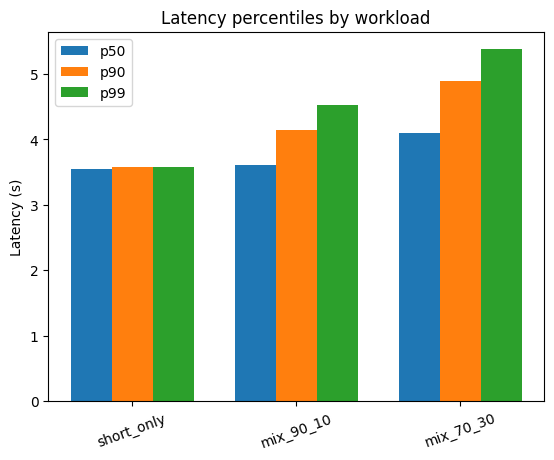

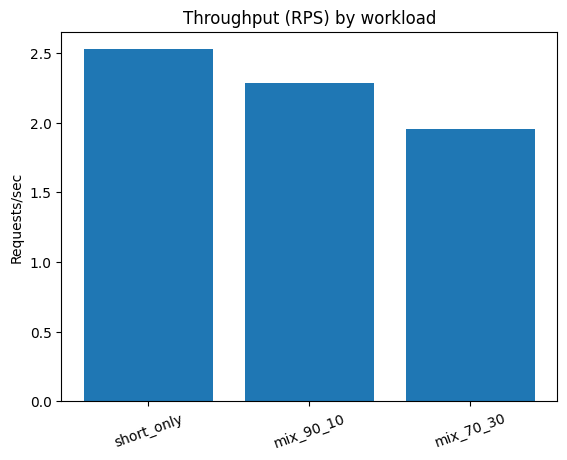

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = summary_df["workload"].tolist()

# p50/p90/p99
p50 = summary_df["p50_s"].values
p90 = summary_df["p90_s"].values
p99 = summary_df["p99_s"].values

x = np.arange(len(labels))
w = 0.25

plt.figure()
plt.bar(x - w, p50, width=w, label="p50")
plt.bar(x,     p90, width=w, label="p90")
plt.bar(x + w, p99, width=w, label="p99")
plt.xticks(x, labels, rotation=20)
plt.ylabel("Latency (s)")
plt.title("Latency percentiles by workload")
plt.legend()
plt.show()

# RPS
plt.figure()
plt.bar(labels, summary_df["rps"].values)
plt.ylabel("Requests/sec")
plt.title("Throughput (RPS) by workload")
plt.xticks(rotation=20)
plt.show()


## Plot Interpretation

These two plots summarize the impact of prompt-length mix on both latency tail and throughput at a fixed concurrency (c=8, 200 total requests each).

As we move from short_only -> mix_90_10 -> mix_70_30, the proportion of long prompts increases, which pushes up p90/p99 latency and reduces overall RPS. This is the classic “mixed-length serving” effect.

Long prompts spend much more time in prefill and consume more KV-cache and batching budget, so they slow down batch completion and increase queueing for everyone, which shows up most clearly in tail latency.

The throughput chart reinforces this: more long requests means fewer requests completed per second. Also note that the latency percentiles here are computed over successful (ok) requests.

The few failed requests from long prompts are not included in the percentile bars, and those failures are exactly what we address next with the max_tokens safety and dynamic max_tokens fix.

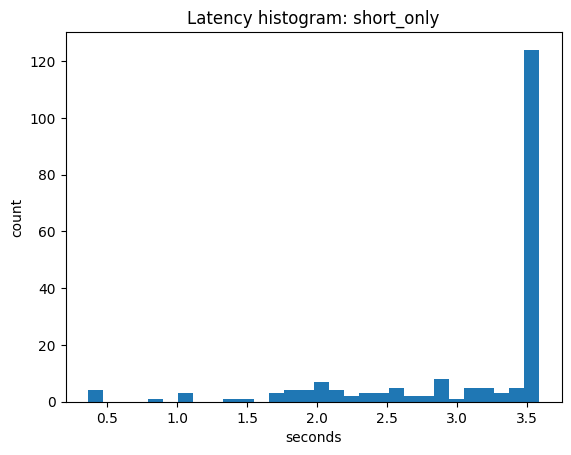

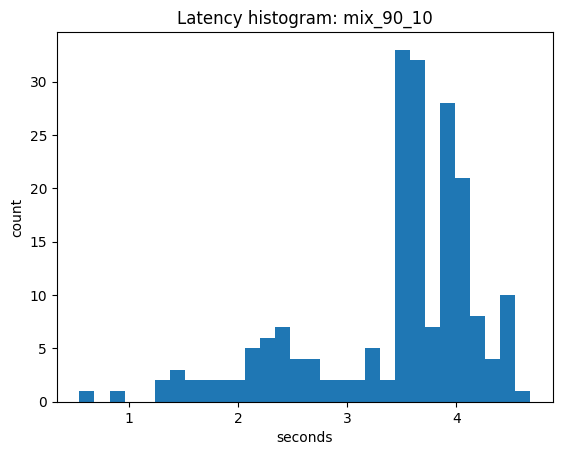

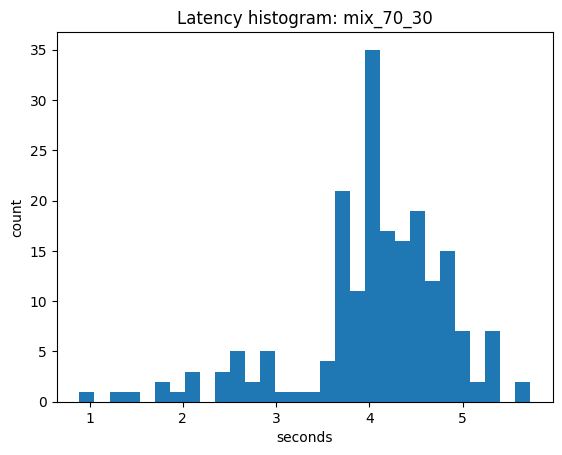

In [ ]:
for name, df in all_dfs.items():
    if "latency_s" in df.columns:
        vals = df[df["latency_s"].notna()]["latency_s"].values
        plt.figure()
        plt.hist(vals, bins=30)
        plt.title(f"Latency histogram: {name}")
        plt.xlabel("seconds")
        plt.ylabel("count")
        plt.show()


## Plot Interpretation

These histograms show the full latency distribution for each workload, not just the percentile summaries. The short_only workload is tightly clustered, which indicates stable, predictable latency when all prompts are small.

As we introduce longer prompts in mix_90_10 and mix_70_30, the distribution shifts to the right and spreads out, meaning higher average latency and greater variability. You can also see a heavier “right tail” in the mixed workloads, which is exactly what drives the p90/p99 increases we saw earlier.

This supports the core point of the experiment: mixed prompt lengths increase tail latency and make serving behavior less predictable.

In the next step we addressing context-budget failures.

# Experiment 1.1: Eliminating `max_token_limit` Failures with Context-Budgeting


### Why this matters ??
In real LLM services, requests do not arrive with uniform prompt sizes. You typically see a mix of short questions, medium chat turns, and occasional very long inputs (documents, logs, transcripts, RAG context, tool traces). If the system sometimes returns hard failures (for example, HTTP 400 context overflow), the service becomes unreliable, breaks downstream pipelines (agents, batch jobs, retries), and makes it harder to meet latency and availability targets.

A robust serving layer should enforce a clear context budget policy that keeps every request within the model’s context window, while degrading gracefully when the input is too large.

### Why we cannot “just cap prompt length”??
Simply limiting the prompt size is not a complete solution:

- **Capability loss:** Long inputs are often the whole point of the application (summarization, document Q&A, log diagnosis).
- **Prompt + completion share the same budget:** Even a “legal-sized” prompt can overflow if `max_tokens` is too large for the remaining space.
- **Naive truncation hurts quality:** Blindly cutting the prompt can drop critical context and silently degrade answer quality.
- **Chat formatting overhead:** System messages and chat templates add tokens that a simple character cap does not account for.



### What we implement in Experiment 1.1
In this experiment, we implement a **context-budgeting policy** that guarantees requests fit the model’s context window:

- First, shrink the output (`max_tokens`) to fit the remaining budget.
- If there still is not enough space for a minimum output, trim the input (head+tail) to create room.
- Log metadata (estimated prompt tokens, chosen `max_tokens`, whether trimming occurred) so the behavior is measurable and reproducible.


In [ ]:
# clean out previous instances of vLLM if you want to start a new server

!pkill -9 -f "vllm.entrypoints.openai.api_server" || true
!pkill -9 -f "EngineCore" || true
!pkill -9 -f "vllm" || true
!sleep 2
!nvidia-smi

^C
^C
^C
Sun Jan 11 22:01:00 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   54C    P8             18W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------------------

In [ ]:
!lsof -i :8000 || true



COMMAND  PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
python3 1144 root   79u  IPv4 606432      0t0  TCP localhost:49490->localhost:8000 (CLOSE_WAIT)


In [ ]:

MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"
PORT = 8000

MAX_MODEL_LEN = 4096
GPU_UTIL = 0.70
DTYPE = "half"

cmd = f"""
nohup python -m vllm.entrypoints.openai.api_server \
  --model {MODEL_ID} \
  --host 127.0.0.1 \
  --port {PORT} \
  --max-model-len {MAX_MODEL_LEN} \
  --gpu-memory-utilization {GPU_UTIL} \
  --dtype {DTYPE} \
  --disable-log-stats \
  > vllm_server.log 2>&1 &
"""

print("Launching vLLM server...")
!bash -lc "$cmd"
!tail -n 30 vllm_server.log


Launching vLLM server...


## Function to check the successful startup of the server.

In [ ]:
BASE = "http://127.0.0.1:8000"

def wait_for_server(timeout_s=600):
    t0 = time.time()
    while time.time() - t0 < timeout_s:
        try:
            r = requests.get(f"{BASE}/v1/models", timeout=2)
            if r.status_code == 200:
                return True, r.json()
        except Exception:
            pass
        time.sleep(2)
    return False, None

ok, payload = wait_for_server()
print("Ready:", ok)
if ok:
    print("Models:", [m["id"] for m in payload.get("data", [])])
else:
    print("Not ready yet. Check logs:")
    !tail -n 60 vllm_server.log


Ready: True
Models: ['Qwen/Qwen2.5-3B-Instruct']


## Dynamic Output Budgeting and Prompt Trimming to Avoid Context Overflow

In [ ]:
SAFETY_MARGIN = 16          # keep small headroom to avoid borderline failures
DESIRED_MAX_TOKENS = 128    # same as Experiment 1
MIN_OUTPUT_TOKENS = 32      # minimum output you want to guarantee

def count_prompt_tokens(messages):
    """
    Counts tokens for the full chat-formatted prompt that will be sent to vLLM.
    Qwen tokenizer supports apply_chat_template().
    """
    ids = tok.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors=None
    )
    return len(ids)

def head_tail_trim_text_by_tokens(text, target_tokens, head_frac=0.35):
    """
    Keep some head + some tail tokens, drop middle.
    """
    ids = tok.encode(text, add_special_tokens=False)
    if len(ids) <= target_tokens:
        return text, False

    head_tokens = int(target_tokens * head_frac)
    tail_tokens = target_tokens - head_tokens

    trimmed_ids = ids[:head_tokens] + ids[-tail_tokens:]
    return tok.decode(trimmed_ids), True

def build_payload_with_budget(prompt_text,
                              desired_max_tokens=DESIRED_MAX_TOKENS,
                              min_output_tokens=MIN_OUTPUT_TOKENS,
                              safety_margin=SAFETY_MARGIN,
                              temperature=0.0):
    """
    Returns (payload, meta).
    - Ensures no context overflow.
    - If needed, trims user prompt (head+tail) to make room for min output tokens.
    """

    messages = [{"role": "user", "content": prompt_text}]
    ptoks = count_prompt_tokens(messages)

    # First attempt: just shrink output tokens if needed
    max_out = min(desired_max_tokens, MAX_MODEL_LEN - safety_margin - ptoks)

    trimmed = False
    original_ptoks = ptoks
    original_prompt = prompt_text

    # If not enough room even for min output -> trim input to create room
    if max_out < min_output_tokens:
        target_prompt_budget = MAX_MODEL_LEN - safety_margin - min_output_tokens
        if target_prompt_budget <= 0:
            raise RuntimeError("Model context too small after safety margin.")

        # We need to reduce prompt tokens from ptoks down to target_prompt_budget.
        # We'll trim only the USER CONTENT tokens.
        #
        # Use a simple search on how many user-content tokens we can keep.
        # (Because chat template adds overhead tokens.)
        lo, hi = 0, len(tok.encode(prompt_text, add_special_tokens=False))
        best_text = ""
        best_ptoks = None

        while lo <= hi:
            mid = (lo + hi) // 2
            candidate_text, _ = head_tail_trim_text_by_tokens(prompt_text, mid)
            candidate_msgs = [{"role": "user", "content": candidate_text}]
            candidate_ptoks = count_prompt_tokens(candidate_msgs)

            if candidate_ptoks <= target_prompt_budget:
                best_text = candidate_text
                best_ptoks = candidate_ptoks
                lo = mid + 1
            else:
                hi = mid - 1

        if best_ptoks is None:
            raise RuntimeError(
                f"Prompt too long to fit even after trimming. "
                f"prompt_tokens={ptoks}, budget={target_prompt_budget}"
            )

        prompt_text = best_text
        trimmed = True
        messages = [{"role": "user", "content": prompt_text}]
        ptoks = best_ptoks

        max_out = min(desired_max_tokens, MAX_MODEL_LEN - safety_margin - ptoks)

    # Final guard
    if max_out <= 0:
        raise RuntimeError(
            f"No room for output tokens. prompt_tokens={ptoks}, "
            f"max_len={MAX_MODEL_LEN}, safety_margin={safety_margin}"
        )

    payload = {
        "model": MODEL_ID,
        "messages": messages,
        "max_tokens": int(max_out),
        "temperature": temperature,
    }

    meta = {
        "prompt_tokens_est": ptoks,
        "max_tokens_used": int(max_out),
        "trimmed": trimmed,
        "prompt_tokens_est_original": original_ptoks,
        "original_prompt_len_chars": len(original_prompt),
        "final_prompt_len_chars": len(prompt_text),
    }
    return payload, meta


## Request Execution with Dynamic Token Budgeting

In [ ]:


def one_request(prompt, desired_max_tokens=128, temperature=0.0, timeout=120):
    t0 = time.perf_counter()

    payload, meta = build_payload_with_budget(
        prompt_text=prompt,
        desired_max_tokens=desired_max_tokens,
        min_output_tokens=MIN_OUTPUT_TOKENS,
        safety_margin=SAFETY_MARGIN,
        temperature=temperature,
    )

    r = requests.post(f"{BASE}/v1/chat/completions", json=payload, timeout=timeout)
    latency = time.perf_counter() - t0

    if r.status_code != 200:
        raise RuntimeError(f"HTTP {r.status_code}: {r.text[:800]}")

    j = r.json()
    usage = j.get("usage", {})

    return {
        "latency_s": latency,
        "prompt_tokens": usage.get("prompt_tokens"),
        "completion_tokens": usage.get("completion_tokens"),
        "total_tokens": usage.get("total_tokens"),
        "status_code": r.status_code,
        # extra debugging info (useful for your writeup)
        **meta
    }


In [ ]:
# smoke test of one_request function

test_prompt = "Explain in 2 sentences what chunked prefill does in vLLM."
out = one_request(test_prompt, desired_max_tokens=128, temperature=0.0, timeout=120)
out


{'latency_s': 1.3368042790007166,
 'prompt_tokens': 46,
 'completion_tokens': 49,
 'total_tokens': 95,
 'status_code': 200,
 'prompt_tokens_est': 46,
 'max_tokens_used': 128,
 'trimmed': False,
 'prompt_tokens_est_original': 46,
 'original_prompt_len_chars': 57,
 'final_prompt_len_chars': 57}

## Load Test Harness Using Budget-Aware Requests (Dynamic max_tokens + Optional Prompt Trimming)

In [ ]:
def run_load(prompts, concurrency=8, total_requests=200, desired_max_tokens=128, desc="load"):
    rng = random.Random(123)
    picked = [rng.choice(prompts) for _ in range(total_requests)]

    results = []
    t_start = time.perf_counter()

    def task(i):
        p = picked[i]
        try:
            res = one_request(p, desired_max_tokens=desired_max_tokens, temperature=0.0, timeout=180)
            res["ok"] = True
        except Exception as e:
            res = {"ok": False, "error": str(e), "latency_s": None,
                   "prompt_tokens": None, "completion_tokens": None, "total_tokens": None}
        return res

    ok_ct = 0
    fail_ct = 0

    with cf.ThreadPoolExecutor(max_workers=concurrency) as ex:
        futs = [ex.submit(task, i) for i in range(total_requests)]
        pbar = tqdm(total=total_requests, desc=desc)
        for f in cf.as_completed(futs):
            r = f.result()
            results.append(r)
            if r.get("ok"):
                ok_ct += 1
            else:
                fail_ct += 1
            pbar.update(1)
            pbar.set_postfix(ok=ok_ct, fail=fail_ct)
        pbar.close()

    t_end = time.perf_counter()

    df = pd.DataFrame(results)
    ok_df = df[df["ok"] == True].copy()

    summary = {
        "concurrency": concurrency,
        "total_requests": total_requests,
        "ok": int(ok_df.shape[0]),
        "fail": int(df.shape[0] - ok_df.shape[0]),
        "wall_time_s": t_end - t_start,
        "rps": ok_df.shape[0] / (t_end - t_start) if (t_end - t_start) > 0 else None,
        "p50_s": float(ok_df["latency_s"].quantile(0.50)) if len(ok_df) else None,
        "p90_s": float(ok_df["latency_s"].quantile(0.90)) if len(ok_df) else None,
        "p99_s": float(ok_df["latency_s"].quantile(0.99)) if len(ok_df) else None,
        "mean_s": float(ok_df["latency_s"].mean()) if len(ok_df) else None,
    }
    return df, summary




## Run Safe (Budget-Aware) Load Tests Across Workloads

In [ ]:
workloads = [
    ("short_only", "short_only.jsonl"),
    ("mix_90_10", "mix_90_10.jsonl"),
    ("mix_70_30", "mix_70_30.jsonl"),
]


all_summaries = []
all_dfs = {}

for name, fn in tqdm(workloads, desc="Workloads (safe)"):
    print("\nRunning:", name)
    df, summ = run_load(
        prompt_sets[fn],
        concurrency=8,
        total_requests=200,
        desired_max_tokens=128,
        desc=f"{name} (c=8, safe)"
    )
    all_dfs[name] = df
    all_summaries.append({"workload": name, **summ})
    print(summ)

summary_df_safe = pd.DataFrame(all_summaries)
summary_df_safe

Workloads (safe):   0%|          | 0/3 [00:00<?, ?it/s]


Running: short_only


short_only (c=8, safe):   0%|          | 0/200 [00:00<?, ?it/s]

{'concurrency': 8, 'total_requests': 200, 'ok': 200, 'fail': 0, 'wall_time_s': 79.25956869500078, 'rps': 2.523354634563067, 'p50_s': 3.556057800500639, 'p90_s': 3.5734452239999883, 'p99_s': 3.58166045346994, 'mean_s': 3.106944176310044}

Running: mix_90_10


mix_90_10 (c=8, safe):   0%|          | 0/200 [00:00<?, ?it/s]

{'concurrency': 8, 'total_requests': 200, 'ok': 200, 'fail': 0, 'wall_time_s': 88.17387503600003, 'rps': 2.268245553667037, 'p50_s': 3.640730647500277, 'p90_s': 4.24218545370004, 'p99_s': 4.5321530194697335, 'mean_s': 3.4690503159849686}

Running: mix_70_30


mix_70_30 (c=8, safe):   0%|          | 0/200 [00:00<?, ?it/s]

{'concurrency': 8, 'total_requests': 200, 'ok': 200, 'fail': 0, 'wall_time_s': 102.89451057299993, 'rps': 1.943738289693377, 'p50_s': 4.175408424499437, 'p90_s': 4.893263480699716, 'p99_s': 5.3932446032813255, 'mean_s': 4.073671482370019}


workload  concurrency  total_requests   ok  fail  wall_time_s       rps  \
0  short_only            8             200  200     0    79.259569  2.523355   
1   mix_90_10            8             200  200     0    88.173875  2.268246   
2   mix_70_30            8             200  200     0   102.894511  1.943738   

      p50_s     p90_s     p99_s    mean_s  
0  3.556058  3.573445  3.581660  3.106944  
1  3.640731  4.242185  4.532153  3.469050  
2  4.175408  4.893263  5.393245  4.073671

## Conclusion

In Experiment 1.1 (the budget-aware request builder), the key improvement is reliability: all three workloads now complete with 0 failures (200/200 OK), including mixes that previously hit HTTP 400 context overflow when long prompts left insufficient room for the requested completion (max_tokens).

This confirms the fix works as intended, because each request now dynamically adjusts max_tokens to fit the remaining context window and trims the prompt only when necessary to guarantee a minimum output budget.

Performance trends remain consistent with Experiment 1: as the proportion of long prompts increases (short_only -> mix_90_10 -> mix_70_30), latency rises and throughput (RPS) drops due to heavier prefill and decoding work, but crucially this happens without any request-level hard failures, making the system robust under mixed prompt lengths.

# Experiment 2: Diagnosing Tail Latency with a “Bad” vLLM Batching Config

In [ ]:
!pkill -f "vllm.entrypoints.openai.api_server" || true
!pkill -f "VLLM::EngineCore" || true
!pkill -f "EngineCore" || true
time.sleep(2)

!rm -f vllm_bad.log
print("killed + log removed")


^C
^C
^C
killed + log removed


## Creating a Bad Config for LLM Server
To replicate a **“chunked prefill effectively OFF”** situation

**Why this is a “bad” config:** We set `--max-num-batched-tokens 8192` (very large) while leaving `--max-num-seqs` unconstrained (defaults can be high). This encourages vLLM to pack big prefills into a batch, which can let long prompts dominate compute and delay short requests.

**Chunked prefill caveat:** Newer vLLM versions have chunked prefill **enabled by default**, but its *practical* benefit depends on admission and batching knobs. If `max-num-batched-tokens` is too permissive (and/or `max-num-seqs` allows over-admission), long prefills can still monopolize batch capacity, effectively **diminishing chunked prefill’s ability to interleave work and protect short requests**.

**Head-of-line blocking risk:** With mixed workloads (50/50 short and long), long-prefill requests can occupy most of the batch token budget, causing short prompts to wait behind long prefills, inflating **p90/p99** latency.


In [ ]:
!nohup python3 -m vllm.entrypoints.openai.api_server \
  --model Qwen/Qwen2.5-3B-Instruct \
  --host 127.0.0.1 --port 8000 \
  --dtype half \
  --max-model-len 4096 \
  --gpu-memory-utilization 0.70 \
  --disable-log-stats \
  --enforce-eager \
  --max-num-batched-tokens 8192 \
  --long-prefill-token-threshold 1024 \
  > vllm_bad.log 2>&1 </dev/null &


In [ ]:
BASE = "http://127.0.0.1:8000"

def wait_for_server(timeout_s=600, poll_s=2):
    t0 = time.time()
    last_err = None
    while time.time() - t0 < timeout_s:
        try:
            r = requests.get(f"{BASE}/v1/models", timeout=2)
            if r.status_code == 200:
                return True, r.json()
            last_err = f"HTTP {r.status_code}: {r.text[:200]}"
        except Exception as e:
            last_err = f"{type(e).__name__}: {e}"
        time.sleep(poll_s)
    return False, last_err

ok, models_or_err = wait_for_server()
print("Ready:", ok)

if ok:
    print("Models:", [m.get("id") for m in models_or_err.get("data", [])])
else:
    print("Not ready yet. Last error:", models_or_err)
    print("Check logs:")
    !tail -n 80 vllm_bad.log


Ready: True
Models: ['Qwen/Qwen2.5-3B-Instruct']


In [ ]:
!tail -n 60 vllm_bad.log

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:01<00:01,  1.06s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.50s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.44s/it]
(EngineCore_DP0 pid=28652) 
(EngineCore_DP0 pid=28652) INFO 01-12 03:47:05 [default_loader.py:308] Loading weights took 2.95 seconds
(EngineCore_DP0 pid=28652) INFO 01-12 03:47:05 [gpu_model_runner.py:3659] Model loading took 5.7916 GiB memory and 4.417226 seconds
(EngineCore_DP0 pid=28652) INFO 01-12 03:47:08 [gpu_worker.py:375] Available KV cache memory: 8.27 GiB
(EngineCore_DP0 pid=28652) INFO 01-12 03:47:08 [kv_cache_utils.py:1291] GPU KV cache size: 240,768 tokens
(EngineCore_DP0 pid=28652) INFO 01-12 03:47:08 [kv_cache_utils.py:1296] Maximum concurrency for 4,096 tokens per request: 58.78x
(EngineCore_DP0 pid=28652) INFO 01-12 03:47:08 [core.py:259] init

## Load Tokenizer

In [ ]:
import requests
from transformers import AutoTokenizer

BASE = "http://127.0.0.1:8000"
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)

models = requests.get(f"{BASE}/v1/models").json()
model_info = next(m for m in models["data"] if m["id"] == MODEL_ID)
MAX_MODEL_LEN = int(model_info.get("max_model_len", 4096))

print("tok loaded")
print("MAX_MODEL_LEN from server:", MAX_MODEL_LEN)


tok loaded
MAX_MODEL_LEN from server: 4096


## Run Load Test on Bad Server Config

In [ ]:
import pandas as pd

WL_FILE = "mix_50_50.jsonl"
CONCURRENCY = 32
TOTAL_REQ = 200
DESIRED_MAX_TOKENS = 16


df_bad, summ_bad = run_load(
    prompt_sets[WL_FILE],
    concurrency=CONCURRENCY,
    total_requests=TOTAL_REQ,
    desired_max_tokens=DESIRED_MAX_TOKENS,
    desc=f"BAD_unfair | {WL_FILE} | c={CONCURRENCY}"
)


print("BAD summary:", summ_bad)
df_bad.head()


BAD_unfair | mix_50_50.jsonl | c=32:   0%|          | 0/200 [00:00<?, ?it/s]

BAD summary: {'concurrency': 32, 'total_requests': 200, 'ok': 200, 'fail': 0, 'wall_time_s': 42.19113462899986, 'rps': 4.740332341347631, 'p50_s': 6.181310366500156, 'p90_s': 10.99196271639994, 'p99_s': 11.637151490029915, 'mean_s': 6.493085269189996}


latency_s  prompt_tokens  completion_tokens  total_tokens  status_code  \
0   8.678932             37                 16            53          200   
1   8.703615             40                 16            56          200   
2   8.683890             42                 16            58          200   
3   8.700286             37                 16            53          200   
4   8.697547             37                 16            53          200   

   prompt_tokens_est  max_tokens_used  trimmed  prompt_tokens_est_original  \
0                 37               16     True                          37   
1                 40               16     True                          40   
2                 42               16     True                          42   
3                 37               16     True                          37   
4                 37               16     True                          37   

   original_prompt_len_chars  final_prompt_len_chars    ok  
0                         36                      36  True  
1                         42                      42  True  
2                         40                      40  True  
3                         59                      59  True  
4                         36                      36  True

## Compute Overall and Short-Prompt Tail Latency Metrics (p50/p90/p99)

In [ ]:
def tail_metrics(df, label, short_cutoff_tokens=64):
    ok = df[df["ok"] == True].copy()

    # overall
    overall = {
        "label": label,
        "subset": "overall",
        "n": len(ok),
        "p50": float(ok["latency_s"].quantile(0.50)),
        "p90": float(ok["latency_s"].quantile(0.90)),
        "p99": float(ok["latency_s"].quantile(0.99)),
        "mean": float(ok["latency_s"].mean()),
    }

    # short-only subset (inside the mixed workload)
    short = ok[ok["prompt_tokens"] <= short_cutoff_tokens].copy()
    if len(short) == 0:
        short_stats = {"label": label, "subset": f"short<= {short_cutoff_tokens}", "n": 0,
                       "p50": None, "p90": None, "p99": None, "mean": None}
    else:
        short_stats = {
            "label": label,
            "subset": f"short<= {short_cutoff_tokens}",
            "n": len(short),
            "p50": float(short["latency_s"].quantile(0.50)),
            "p90": float(short["latency_s"].quantile(0.90)),
            "p99": float(short["latency_s"].quantile(0.99)),
            "mean": float(short["latency_s"].mean()),
        }

    return overall, short_stats


In [ ]:
overall_bad, short_bad = tail_metrics(df_bad, "BAD_unfair", short_cutoff_tokens=64)
overall_bad, short_bad


({'label': 'BAD_unfair',
  'subset': 'overall',
  'n': 200,
  'p50': 6.181310366500156,
  'p90': 10.99196271639994,
  'p99': 11.637151490029915,
  'mean': 6.493085269189996},
 {'label': 'BAD_unfair',
  'subset': 'short<= 64',
  'n': 108,
  'p50': 5.480035559000271,
  'p90': 8.717383960199822,
  'p99': 10.618033962269847,
  'mean': 5.465330376453692})

# Expermient 3: Tail latency and Throughput variation with Concurrency Sweep
This sweep isolates scheduling effects by holding workload and max batched token length constant, then measuring how tail latency and throughput evolve with concurrency.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os, json, shutil, time
import pandas as pd

WL_FILE = "mix_50_50.jsonl"
TOTAL_REQ = 200
DESIRED_MAX_TOKENS = 16
CONCURRENCY_LIST = [1, 2, 4, 8, 16, 32, 48, 64]

SHORT_CUTOFF = 64
LONG_CUTOFF  = 2048

LABEL = "BAD_unfair"

RUN_DIR = "/content/drive/MyDrive/vllm_sweeps/exp2_bad_unfair"
os.makedirs(RUN_DIR, exist_ok=True)

CKPT_CSV      = os.path.join(RUN_DIR, "concurrency_checkpoint.csv")
MANIFEST_JSON = os.path.join(RUN_DIR, "concurrency_manifest.json")

SAVE_RAW_DF = False
RAW_DIR = os.path.join(RUN_DIR, "raw_dfs")
if SAVE_RAW_DF:
    os.makedirs(RAW_DIR, exist_ok=True)

manifest = {
    "label": LABEL,
    "workload_file": WL_FILE,
    "total_requests": TOTAL_REQ,
    "desired_max_tokens": DESIRED_MAX_TOKENS,
    "concurrency_list": CONCURRENCY_LIST,
    "short_cutoff": SHORT_CUTOFF,
    "long_cutoff": LONG_CUTOFF,
}

if os.path.exists(MANIFEST_JSON):
    try:
        old = json.loads(open(MANIFEST_JSON, "r").read())
        if old != manifest:
            print("Manifest differs from existing checkpoint. You may be mixing runs.")
            print("Existing:", old)
            print("New:", manifest)
    except Exception:
        print("Could not read existing manifest. Proceeding.")
else:
    with open(MANIFEST_JSON, "w") as f:
        json.dump(manifest, f, indent=2)

def summarize_run(df, summ, label, workload, concurrency):
    ok = df[df["ok"] == True].copy()

    row = {
        "label": label,
        "workload": workload,
        "concurrency": int(concurrency),

        "ok": summ.get("ok"),
        "fail": summ.get("fail"),
        "rps": summ.get("rps"),
        "wall_time_s": summ.get("wall_time_s"),
        "p50_s": summ.get("p50_s"),
        "p90_s": summ.get("p90_s"),
        "p99_s": summ.get("p99_s"),
        "mean_s": summ.get("mean_s"),
    }

    short = ok[ok["prompt_tokens"] <= SHORT_CUTOFF]
    row["short_n"] = int(len(short))
    row["short_p50_s"] = float(short["latency_s"].quantile(0.50)) if len(short) else None
    row["short_p90_s"] = float(short["latency_s"].quantile(0.90)) if len(short) else None
    row["short_p99_s"] = float(short["latency_s"].quantile(0.99)) if len(short) else None

    longg = ok[ok["prompt_tokens"] >= LONG_CUTOFF]
    row["long_n"] = int(len(longg))
    row["long_p50_s"] = float(longg["latency_s"].quantile(0.50)) if len(longg) else None
    row["long_p90_s"] = float(longg["latency_s"].quantile(0.90)) if len(longg) else None
    row["long_p99_s"] = float(longg["latency_s"].quantile(0.99)) if len(longg) else None

    return row

def load_ckpt_df(path):
    if not os.path.exists(path):
        return pd.DataFrame()
    df = pd.read_csv(path)
    if "concurrency" in df.columns:
        df["concurrency"] = pd.to_numeric(df["concurrency"], errors="coerce").astype("Int64")
    return df

def done_concurrencies(df_ckpt):
    if df_ckpt.empty:
        return set()
    good = df_ckpt[df_ckpt["concurrency"].notna()].copy()
    if "status" in good.columns:
        good = good[good["status"].isna()].copy()
    return set(int(x) for x in good["concurrency"].dropna().tolist())

def append_ckpt_row(row, path):
    df_row = pd.DataFrame([row])
    header = not os.path.exists(path)
    df_row.to_csv(path, mode="a", header=header, index=False)

def maybe_save_raw_df(df, concurrency):
    if not SAVE_RAW_DF:
        return
    outp = os.path.join(RAW_DIR, f"raw_c{int(concurrency)}.parquet")
    try:
        df.to_parquet(outp, index=False)
    except Exception:
        outp = os.path.join(RAW_DIR, f"raw_c{int(concurrency)}.csv")
        df.to_csv(outp, index=False)

ckpt_df = load_ckpt_df(CKPT_CSV)
done = done_concurrencies(ckpt_df)
print("Loaded checkpoint rows:", len(ckpt_df))
print("Completed concurrencies:", sorted(done))

for c in CONCURRENCY_LIST:
    c = int(c)
    if c in done:
        print("Skipping:", c)
        continue

    print("Running:", LABEL, WL_FILE, "c=", c)

    try:
        df, summ = run_load(
            prompt_sets[WL_FILE],
            concurrency=c,
            total_requests=TOTAL_REQ,
            desired_max_tokens=DESIRED_MAX_TOKENS,
            desc=f"{LABEL} | {WL_FILE} | c={c}",
        )

        row = summarize_run(df, summ, label=LABEL, workload=WL_FILE, concurrency=c)
        append_ckpt_row(row, CKPT_CSV)
        maybe_save_raw_df(df, concurrency=c)

        ckpt_df = load_ckpt_df(CKPT_CSV)
        done = done_concurrencies(ckpt_df)

    except Exception as e:
        fail_row = {
            "label": LABEL,
            "workload": WL_FILE,
            "concurrency": c,
            "ok": None,
            "fail": None,
            "rps": None,
            "wall_time_s": None,
            "p50_s": None,
            "p90_s": None,
            "p99_s": None,
            "mean_s": None,
            "short_n": None,
            "short_p50_s": None,
            "short_p90_s": None,
            "short_p99_s": None,
            "long_n": None,
            "long_p50_s": None,
            "long_p90_s": None,
            "long_p99_s": None,
            "status": "run_failed",
            "error": type(e).__name__,
        }
        append_ckpt_row(fail_row, CKPT_CSV)
        print("run_load failed:", type(e).__name__, str(e)[:200])

summary_df = load_ckpt_df(CKPT_CSV).copy()
if "status" in summary_df.columns:
    summary_df = summary_df[summary_df["status"].isna()].copy()

summary_df = summary_df.sort_values("concurrency").reset_index(drop=True)

print("Concurrency sweep done/resumed. Summary DF loaded from Drive:")
display(summary_df)

FINAL_CSV = os.path.join(RUN_DIR, "summary_df_final.csv")
summary_df.to_csv(FINAL_CSV, index=False)
print("Final snapshot saved:", FINAL_CSV)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded checkpoint rows: 0
Completed concurrencies: []
Running: BAD_unfair mix_50_50.jsonl c= 1


BAD_unfair | mix_50_50.jsonl | c=1:   0%|          | 0/200 [00:00<?, ?it/s]

Running: BAD_unfair mix_50_50.jsonl c= 2


BAD_unfair | mix_50_50.jsonl | c=2:   0%|          | 0/200 [00:00<?, ?it/s]

Running: BAD_unfair mix_50_50.jsonl c= 4


BAD_unfair | mix_50_50.jsonl | c=4:   0%|          | 0/200 [00:00<?, ?it/s]

Running: BAD_unfair mix_50_50.jsonl c= 8


BAD_unfair | mix_50_50.jsonl | c=8:   0%|          | 0/200 [00:00<?, ?it/s]

Running: BAD_unfair mix_50_50.jsonl c= 16


BAD_unfair | mix_50_50.jsonl | c=16:   0%|          | 0/200 [00:00<?, ?it/s]

Running: BAD_unfair mix_50_50.jsonl c= 32


BAD_unfair | mix_50_50.jsonl | c=32:   0%|          | 0/200 [00:00<?, ?it/s]

Running: BAD_unfair mix_50_50.jsonl c= 48


BAD_unfair | mix_50_50.jsonl | c=48:   0%|          | 0/200 [00:00<?, ?it/s]

Running: BAD_unfair mix_50_50.jsonl c= 64


BAD_unfair | mix_50_50.jsonl | c=64:   0%|          | 0/200 [00:00<?, ?it/s]

Concurrency sweep done/resumed. Summary DF loaded from Drive:


label         workload  concurrency   ok  fail       rps  wall_time_s  \
0  BAD_unfair  mix_50_50.jsonl            1  200     0  1.310728   152.586979   
1  BAD_unfair  mix_50_50.jsonl            2  200     0  2.350512    85.087858   
2  BAD_unfair  mix_50_50.jsonl            4  200     0  3.588961    55.726434   
3  BAD_unfair  mix_50_50.jsonl            8  200     0  4.897939    40.833506   
4  BAD_unfair  mix_50_50.jsonl           16  200     0  5.902047    33.886548   
5  BAD_unfair  mix_50_50.jsonl           32  200     0  5.912537    33.826429   
6  BAD_unfair  mix_50_50.jsonl           48  200     0  6.029853    33.168302   
7  BAD_unfair  mix_50_50.jsonl           64  200     0  5.817353    34.379898   

      p50_s      p90_s      p99_s     mean_s  short_n  short_p50_s  \
0  0.455211   1.264692   1.302439   0.762749      108     0.452125   
1  0.753871   1.356037   1.788700   0.848931      108     0.485196   
2  0.974289   1.860058   2.692315   1.103148      108     0.683215   
3  1.472894   2.478667   3.694609   1.622580      108     1.072935   
4  2.537444   4.032396   6.204649   2.649116      108     2.117380   
5  5.829220   7.589303   9.536481   5.360095      108     4.331117   
6  7.492978  11.804981  13.755477   7.446991      108     6.674927   
7  9.910197  16.760385  21.667766  10.589799      108     9.080885   

   short_p90_s  short_p99_s  long_n  long_p50_s  long_p90_s  long_p99_s  
0     0.454941     0.459093      92    1.205338    1.285715    1.303359  
1     0.914527     0.975944      92    1.255870    1.719273    1.797350  
2     1.084713     1.870385      92    1.394751    2.233235    2.711042  
3     1.990982     2.762490      92    1.851654    3.268468    3.715869  
4     3.117051     4.027770      92    3.134112    4.560557    6.210381  
5     7.099870     7.235541      92    7.099446    8.252152   10.189636  
6    10.952635    11.278168      92   10.599569   12.027501   13.872306  
7    14.692452    15.790760      92   12.666633   18.421034   21.937133

Final snapshot saved: /content/drive/MyDrive/vllm_sweeps/exp2_bad_unfair/summary_df_final.csv


## Plot some meaningful charts from Sweep results

Saved: plots_bad_sweep/bad_throughput_vs_concurrency.png


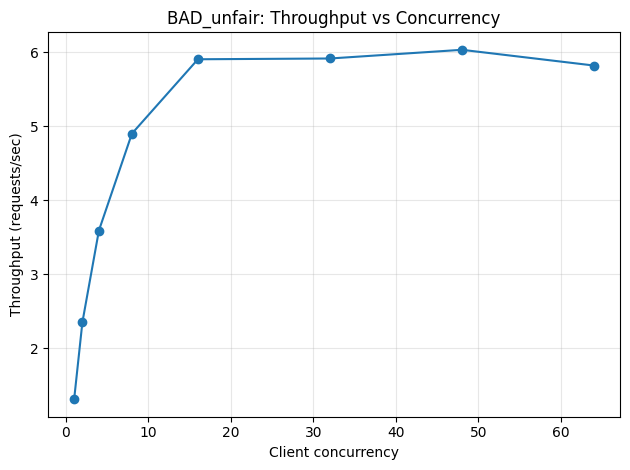

Saved: plots_bad_sweep/bad_p50_s_vs_concurrency.png


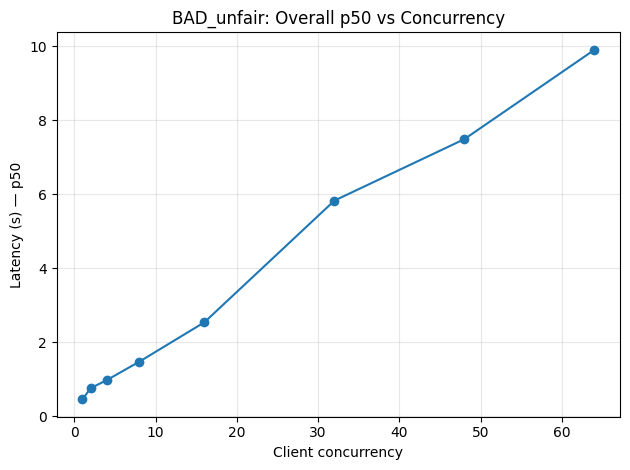

Saved: plots_bad_sweep/bad_p90_s_vs_concurrency.png


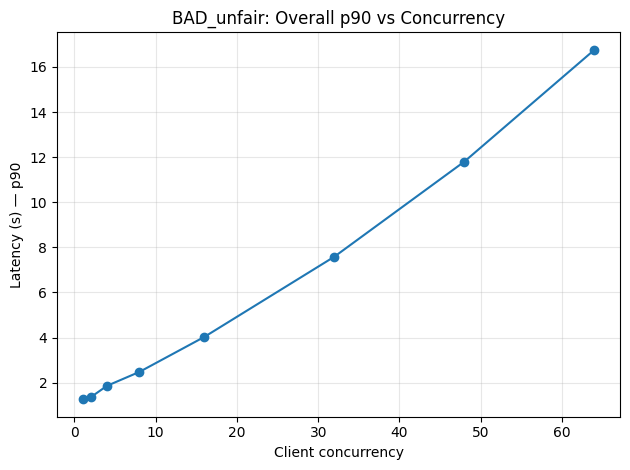

Saved: plots_bad_sweep/bad_p99_s_vs_concurrency.png


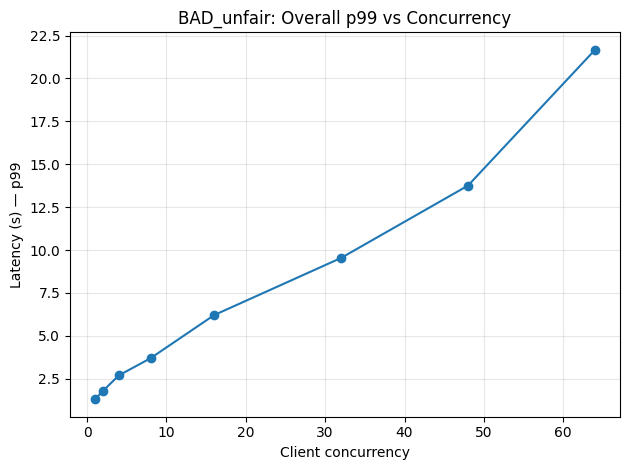

Saved: plots_bad_sweep/bad_short_long_p99_vs_concurrency.png


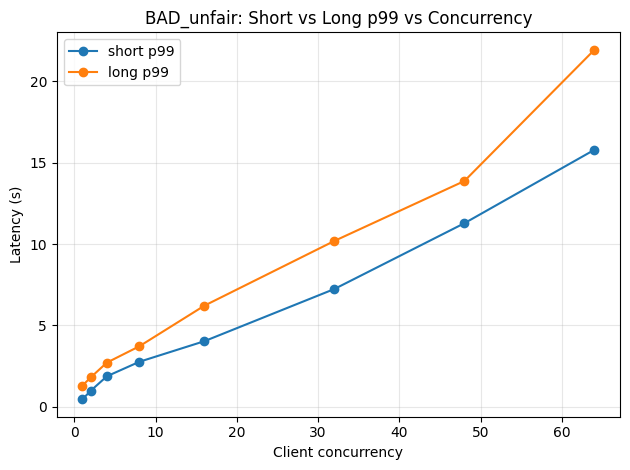

Saved: plots_bad_sweep/bad_p99_vs_rps.png


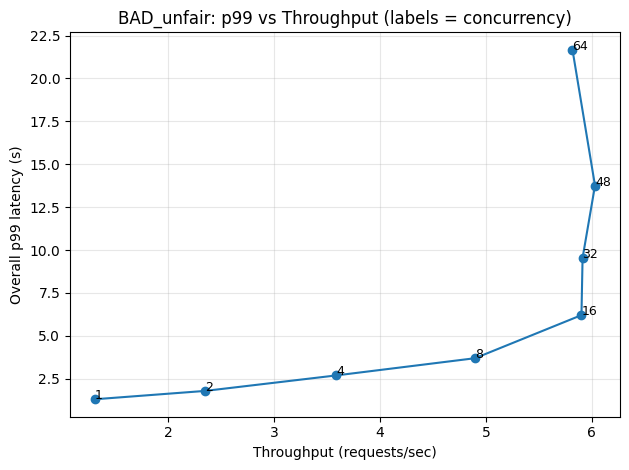

Done. Plot folder: plots_bad_sweep


concurrency       rps     p50_s      p90_s      p99_s  short_p99_s  \
0            1  1.310728  0.455211   1.264692   1.302439     0.459093   
1            2  2.350512  0.753871   1.356037   1.788700     0.975944   
2            4  3.588961  0.974289   1.860058   2.692315     1.870385   
3            8  4.897939  1.472894   2.478667   3.694609     2.762490   
4           16  5.902047  2.537444   4.032396   6.204649     4.027770   
5           32  5.912537  5.829220   7.589303   9.536481     7.235541   
6           48  6.029853  7.492978  11.804981  13.755477    11.278168   
7           64  5.817353  9.910197  16.760385  21.667766    15.790760   

   long_p99_s  
0    1.303359  
1    1.797350  
2    2.711042  
3    3.715869  
4    6.210381  
5   10.189636  
6   13.872306  
7   21.937133

In [ ]:
df = summary_df.copy()

num_cols = [
    "concurrency","rps","wall_time_s","p50_s","p90_s","p99_s","mean_s",
    "short_p50_s","short_p90_s","short_p99_s",
    "long_p50_s","long_p90_s","long_p99_s",
    "short_n","long_n"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.sort_values("concurrency").reset_index(drop=True)

# output directory
PLOT_DIR = "plots_bad_sweep"
os.makedirs(PLOT_DIR, exist_ok=True)


def savefig(name):
    path = os.path.join(PLOT_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("Saved:", path)


# Throughput vs concurrency
plt.figure()
plt.plot(df["concurrency"], df["rps"], marker="o")
plt.xlabel("Client concurrency")
plt.ylabel("Throughput (requests/sec)")
plt.title("BAD_unfair: Throughput vs Concurrency")
plt.grid(True, alpha=0.3)
savefig("bad_throughput_vs_concurrency.png")
plt.show()

# Overall tail latency vs concurrency (p50 / p90 / p99)
for metric, title in [
    ("p50_s", "BAD_unfair: Overall p50 vs Concurrency"),
    ("p90_s", "BAD_unfair: Overall p90 vs Concurrency"),
    ("p99_s", "BAD_unfair: Overall p99 vs Concurrency"),
]:
    plt.figure()
    plt.plot(df["concurrency"], df[metric], marker="o")
    plt.xlabel("Client concurrency")
    plt.ylabel(f"Latency (s) — {metric.replace('_s','')}")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    savefig(f"bad_{metric}_vs_concurrency.png")
    plt.show()

# Short vs Long p99 comparison (same plot)
plt.figure()
plt.plot(df["concurrency"], df["short_p99_s"], marker="o", label="short p99")
plt.plot(df["concurrency"], df["long_p99_s"], marker="o", label="long p99")
plt.xlabel("Client concurrency")
plt.ylabel("Latency (s)")
plt.title("BAD_unfair: Short vs Long p99 vs Concurrency")
plt.grid(True, alpha=0.3)
plt.legend()
savefig("bad_short_long_p99_vs_concurrency.png")
plt.show()

# "Knee" visualization: p99 vs RPS (tradeoff curve)
plt.figure()
plt.plot(df["rps"], df["p99_s"], marker="o")
for _, r in df.iterrows():
    plt.text(r["rps"], r["p99_s"], str(int(r["concurrency"])), fontsize=9)

plt.xlabel("Throughput (requests/sec)")
plt.ylabel("Overall p99 latency (s)")
plt.title("BAD_unfair: p99 vs Throughput (labels = concurrency)")
plt.grid(True, alpha=0.3)
savefig("bad_p99_vs_rps.png")
plt.show()

print("Done. Plot folder:", PLOT_DIR)
df[["concurrency","rps","p50_s","p90_s","p99_s","short_p99_s","long_p99_s"]]


## Conclusion

- **Throughput scales then saturates:** RPS rises from **~1.31 (c=1)** to **~5.90 (c=16)** and then stays around **~5.8–6.0 RPS** through **c=64**, showing the server hits a throughput ceiling.
- **Clear knee and tail blow-up:** overall **p99** grows from **~1.30s (c=1)** to **~6.20s (c=16)**, then jumps to **~9.54s (c=32)** and reaches **~21.67s (c=64)**.
- **Short requests get dragged into the tail:** short **p99** inflates from **~0.46s (c=1)** to **~4.03s (c=16)** and **~15.79s (c=64)**, which indicates strong queueing interference from long prompts.
- **At high concurrency, short and long tails converge:** by **c=64**, short **p99 ~15.79s** and long **p99 ~21.94s**, meaning even short prompts suffer large delays under this bad/unfair configuration.


## Saving plots to Drive

In [ ]:
LOCAL_PLOT_DIR = "plots_bad_sweep"
DRIVE_PLOT_DIR = "/content/drive/MyDrive/vllm_sweeps/exp2_bad_unfair/plots_bad_sweep"

if os.path.exists(DRIVE_PLOT_DIR):
    shutil.rmtree(DRIVE_PLOT_DIR)
shutil.copytree(LOCAL_PLOT_DIR, DRIVE_PLOT_DIR)

print("Copied plots to:", DRIVE_PLOT_DIR)

Copied plots to: /content/drive/MyDrive/vllm_sweeps/exp2_bad_unfair/plots_bad_sweep


# Experiment 4: Sweep of concurrency and `max-num-seqs`

In this sweep, we stress-test a deliberately “bad” vLLM server configuration under a mixed workload (mix_50_50) to quantify how tail latency behaves as system load increases. By sweeping both client concurrency and the server’s admission capacity (max_num_seqs), we expose where throughput stops scaling, where queueing begins to dominate, and how long-prefill requests can degrade the latency of short requests in a shared serving setup. The goal is to establish a clear baseline of failure modes before introducing improved scheduling/configurations in the next steps.

In [ ]:
BASE = "http://127.0.0.1:8000"
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"


CHECKPOINT_CSV = "bad_grid_checkpoint.csv"
MANIFEST_JSON  = "bad_grid_manifest.json"


def kill_server():
    os.system('pkill -f "vllm.entrypoints.openai.api_server" || true')
    os.system('pkill -f "VLLM::EngineCore" || true')
    time.sleep(1.5)

def tail_log(log_path, n=60):
    if os.path.exists(log_path):
        print(f"\n--- tail {log_path} (last {n}) ---")
        os.system(f"tail -n {n} {log_path}")
    else:
        print(f"(log missing: {log_path})")

def wait_for_ready(base=BASE, log_path="vllm_bad.log", timeout_s=420):
    t0 = time.time()
    tries = 0
    while True:
        tries += 1
        try:
            r = requests.get(f"{base}/v1/models", timeout=2)
            if r.status_code == 200:
                data = r.json().get("data", [])
                ids = [m.get("id") for m in data]
                print(f" Server ready. Models: {ids}")
                return True
            else:
                print(f"[{tries}] /v1/models status={r.status_code}")
        except Exception as e:
            print(f"[{tries}] not ready yet: {type(e).__name__}")

        alive = os.system('ps -ef | grep -E "vllm.entrypoints.openai.api_server" | grep -v grep > /dev/null') == 0
        if not alive:
            print(" vLLM process is NOT running anymore.")
            tail_log(log_path, n=140)
            return False

        if time.time() - t0 > timeout_s:
            print(" Timed out waiting for server.")
            tail_log(log_path, n=140)
            return False

        if tries % 5 == 0:
            tail_log(log_path, n=30)

        time.sleep(2)

def warmup_request():
    payload = {
        "model": MODEL_ID,
        "messages": [{"role": "user", "content": "hi"}],
        "max_tokens": 8,
        "temperature": 0.0,
    }
    try:
        _ = requests.post(f"{BASE}/v1/chat/completions", json=payload, timeout=30)
    except Exception:
        pass

def start_bad_server(max_num_seqs, log_path="vllm_bad.log"):
    kill_server()
    try:
        os.remove(log_path)
    except FileNotFoundError:
        pass

    cmd = f"""
nohup python3 -m vllm.entrypoints.openai.api_server \
  --model {MODEL_ID} \
  --host 127.0.0.1 --port 8000 \
  --dtype half \
  --max-model-len 4096 \
  --gpu-memory-utilization 0.70 \
  --disable-log-stats \
  --enforce-eager \
  --max-num-batched-tokens 8192 \
  --long-prefill-token-threshold 1024 \
  --max-num-seqs {int(max_num_seqs)} \
  > {log_path} 2>&1 </dev/null &
"""
    os.system(cmd)
    time.sleep(1.0)



def _safe_quantile(series, q):
    if series is None or len(series) == 0:
        return None
    return float(series.quantile(q))

def _safe_mean(series):
    if series is None or len(series) == 0:
        return None
    return float(series.mean())

def subset_metrics(df, short_cutoff_tokens=64, long_cutoff_tokens=2048):
    ok = df[df["ok"] == True].copy()
    lat = ok["latency_s"]

    out = {
        "overall_n": int(len(ok)),
        "overall_p50": _safe_quantile(lat, 0.50),
        "overall_p90": _safe_quantile(lat, 0.90),
        "overall_p99": _safe_quantile(lat, 0.99),
        "overall_mean": _safe_mean(lat),
    }

    short = ok[ok["prompt_tokens"] <= short_cutoff_tokens]
    out.update({
        "short_n": int(len(short)),
        "short_p50": _safe_quantile(short["latency_s"], 0.50),
        "short_p90": _safe_quantile(short["latency_s"], 0.90),
        "short_p99": _safe_quantile(short["latency_s"], 0.99),
        "short_mean": _safe_mean(short["latency_s"]),
    })

    long = ok[ok["prompt_tokens"] >= long_cutoff_tokens]
    out.update({
        "long_n": int(len(long)),
        "long_p50": _safe_quantile(long["latency_s"], 0.50),
        "long_p90": _safe_quantile(long["latency_s"], 0.90),
        "long_p99": _safe_quantile(long["latency_s"], 0.99),
        "long_mean": _safe_mean(long["latency_s"]),
    })
    return out

def row_from_run(label, workload, concurrency, max_num_seqs, df, summ):
    m = subset_metrics(df, short_cutoff_tokens=64, long_cutoff_tokens=2048)
    return {
        "label": label,
        "workload": workload,
        "concurrency": int(concurrency),
        "max_num_seqs": int(max_num_seqs),

        "status": "ok",
        "ok": int(summ.get("ok")) if summ.get("ok") is not None else int((df["ok"] == True).sum()),
        "fail": int(summ.get("fail")) if summ.get("fail") is not None else int((df["ok"] != True).sum()),
        "rps": float(summ.get("rps")) if summ.get("rps") is not None else None,
        "wall_time_s": float(summ.get("wall_time_s")) if summ.get("wall_time_s") is not None else None,
        "summ_p50_s": float(summ.get("p50_s")) if summ.get("p50_s") is not None else None,
        "summ_p90_s": float(summ.get("p90_s")) if summ.get("p90_s") is not None else None,
        "summ_p99_s": float(summ.get("p99_s")) if summ.get("p99_s") is not None else None,
        "summ_mean_s": float(summ.get("mean_s")) if summ.get("mean_s") is not None else None,
    }


def load_checkpoint_df(path=CHECKPOINT_CSV):
    if os.path.exists(path):
        df = pd.read_csv(path)
        # normalize types
        if "max_num_seqs" in df.columns:
            df["max_num_seqs"] = df["max_num_seqs"].astype(int)
        if "concurrency" in df.columns:
            df["concurrency"] = df["concurrency"].astype(int)
        return df
    return pd.DataFrame()

def completed_pairs(df_ckpt):
    # Only treat status=="ok" as completed (you can also include server_failed if you want)
    if df_ckpt.empty:
        return set()
    done = df_ckpt[df_ckpt["status"] == "ok"][["max_num_seqs", "concurrency"]].dropna()
    return set((int(r.max_num_seqs), int(r.concurrency)) for r in done.itertuples(index=False))

def append_row_checkpoint(row, path=CHECKPOINT_CSV):
    df_row = pd.DataFrame([row])
    header = not os.path.exists(path)
    df_row.to_csv(path, mode="a", header=header, index=False)

def write_manifest(payload, path=MANIFEST_JSON):
    # don’t overwrite if already exists unless identical
    if os.path.exists(path):
        try:
            old = json.loads(open(path, "r").read())
            if old != payload:
                print(" Manifest differs from existing one. You may be resuming with different sweep params.")
                print("Existing:", old)
                print("New:", payload)
        except Exception:
            print(" Could not read existing manifest. Proceeding.")
        return
    with open(path, "w") as f:
        json.dump(payload, f, indent=2)



# sweep runner

WL_FILE = "mix_50_50.jsonl"
TOTAL_REQ = 200
DESIRED_MAX_TOKENS = 16

concurrency_list = [1, 2, 4, 8, 16, 32, 48, 64]
max_num_seqs_list = [16, 32, 48, 64, 80, 96]

# save manifest to know what this checkpoint corresponds to
write_manifest({
    "workload": WL_FILE,
    "total_requests": TOTAL_REQ,
    "desired_max_tokens": DESIRED_MAX_TOKENS,
    "concurrency_list": concurrency_list,
    "max_num_seqs_list": max_num_seqs_list,
    "model_id": MODEL_ID,
    "server_flags": {
        "max_num_batched_tokens": 8192,
        "long_prefill_token_threshold": 1024,
        "gpu_memory_utilization": 0.70,
        "max_model_len": 4096,
        "dtype": "half",
        "enforce_eager": True
    }
})

ckpt_df = load_checkpoint_df(CHECKPOINT_CSV)
done = completed_pairs(ckpt_df)
print(f" Loaded checkpoint rows: {len(ckpt_df)} | completed runs: {len(done)}")

for max_num_seqs in max_num_seqs_list:
    # If all concurrencies for this max_num_seqs are done, skip server restart entirely
    all_done_for_this = all((max_num_seqs, c) in done for c in concurrency_list)
    if all_done_for_this:
        print(f"\n Skipping max_num_seqs={max_num_seqs} (all concurrencies already done)")
        continue

    print("\n====================================================")
    print(f"Starting BAD server with max-num-seqs={max_num_seqs}")
    print("====================================================")
    start_bad_server(max_num_seqs=max_num_seqs, log_path="vllm_bad.log")

    ok = wait_for_ready(BASE, log_path="vllm_bad.log", timeout_s=420)
    if not ok:
        # record server_failed for missing concurrencies only
        for c in concurrency_list:
            if (max_num_seqs, c) in done:
                continue
            row = {
                "label": "BAD_unfair",
                "workload": WL_FILE,
                "concurrency": int(c),
                "max_num_seqs": int(max_num_seqs),
                "status": "server_failed",
            }
            append_row_checkpoint(row, CHECKPOINT_CSV)
        # refresh checkpoint view
        ckpt_df = load_checkpoint_df(CHECKPOINT_CSV)
        done = completed_pairs(ckpt_df)
        continue

    warmup_request()

    for c in concurrency_list:
        if (max_num_seqs, c) in done:
            print(f"  Skip (already done): max_seqs={max_num_seqs}, c={c}")
            continue

        print(f"\n--- RUN: BAD_unfair | {WL_FILE} | max_seqs={max_num_seqs} | c={c} ---")

        try:
            df_bad, summ_bad = run_load(
                prompt_sets[WL_FILE],
                concurrency=c,
                total_requests=TOTAL_REQ,
                desired_max_tokens=DESIRED_MAX_TOKENS,
                desc=f"BAD_unfair | {WL_FILE} | max_seqs={max_num_seqs} | c={c}",
            )

            row = row_from_run(
                label="BAD_unfair",
                workload=WL_FILE,
                concurrency=c,
                max_num_seqs=max_num_seqs,
                df=df_bad,
                summ=summ_bad,
            )
            append_row_checkpoint(row, CHECKPOINT_CSV)

        except Exception as e:
            # record run_failed so you can retry later
            row = {
                "label": "BAD_unfair",
                "workload": WL_FILE,
                "concurrency": int(c),
                "max_num_seqs": int(max_num_seqs),
                "status": "run_failed",
                "error": type(e).__name__,
            }
            append_row_checkpoint(row, CHECKPOINT_CSV)
            print(" run_load failed:", type(e).__name__)
            tail_log("vllm_bad.log", n=80)

        # refresh done set so mid-run restarts still work cleanly
        ckpt_df = load_checkpoint_df(CHECKPOINT_CSV)
        done = completed_pairs(ckpt_df)

kill_server()

summary_df = load_checkpoint_df(CHECKPOINT_CSV)
print("\n BAD (concurrency x max-num-seqs) sweep (resume-capable) done.")
summary_df


✅ Loaded checkpoint rows: 0 | completed runs: 0

Starting BAD server with max-num-seqs=16
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready 

BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=1:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=2 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=2:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=4 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=4:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=8 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=8:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=16 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=16:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=32 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=32:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=48 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=48:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=64 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=16 | c=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting BAD server with max-num-seqs=32
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready yet: Connect

BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=1:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=2 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=2:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=4 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=4:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=8 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=8:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=16 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=16:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=32 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=32:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=48 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=48:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=64 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=32 | c=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting BAD server with max-num-seqs=48
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready yet: Connect

BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=1:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=2 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=2:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=4 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=4:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=8 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=8:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=16 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=16:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=32 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=32:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=48 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=48:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=64 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=48 | c=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting BAD server with max-num-seqs=64
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready yet: Connect

BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=1:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=2 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=2:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=4 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=4:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=8 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=8:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=16 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=16:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=32 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=32:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=48 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=48:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=64 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=64 | c=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting BAD server with max-num-seqs=80
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready yet: Connect

BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=1:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=2 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=2:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=4 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=4:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=8 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=8:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=16 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=16:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=32 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=32:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=48 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=48:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=64 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=80 | c=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting BAD server with max-num-seqs=96
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_bad.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready yet: Connect

BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=1:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=2 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=2:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=4 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=4:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=8 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=8:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=16 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=16:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=32 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=32:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=48 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=48:   0%|          | 0/200 [00:00<?, ?it/s]


--- RUN: BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=64 ---


BAD_unfair | mix_50_50.jsonl | max_seqs=96 | c=64:   0%|          | 0/200 [00:00<?, ?it/s]


✅ BAD (concurrency x max-num-seqs) sweep (resume-capable) done.


label         workload  concurrency  max_num_seqs status   ok  fail  \
0   BAD_unfair  mix_50_50.jsonl            1            16     ok  200     0   
1   BAD_unfair  mix_50_50.jsonl            2            16     ok  200     0   
2   BAD_unfair  mix_50_50.jsonl            4            16     ok  200     0   
3   BAD_unfair  mix_50_50.jsonl            8            16     ok  200     0   
4   BAD_unfair  mix_50_50.jsonl           16            16     ok  200     0   
5   BAD_unfair  mix_50_50.jsonl           32            16     ok  200     0   
6   BAD_unfair  mix_50_50.jsonl           48            16     ok  200     0   
7   BAD_unfair  mix_50_50.jsonl           64            16     ok  200     0   
8   BAD_unfair  mix_50_50.jsonl            1            32     ok  200     0   
9   BAD_unfair  mix_50_50.jsonl            2            32     ok  200     0   
10  BAD_unfair  mix_50_50.jsonl            4            32     ok  200     0   
11  BAD_unfair  mix_50_50.jsonl            8            32     ok  200     0   
12  BAD_unfair  mix_50_50.jsonl           16            32     ok  200     0   
13  BAD_unfair  mix_50_50.jsonl           32            32     ok  200     0   
14  BAD_unfair  mix_50_50.jsonl           48            32     ok  200     0   
15  BAD_unfair  mix_50_50.jsonl           64            32     ok  200     0   
16  BAD_unfair  mix_50_50.jsonl            1            48     ok  200     0   
17  BAD_unfair  mix_50_50.jsonl            2            48     ok  200     0   
18  BAD_unfair  mix_50_50.jsonl            4            48     ok  200     0   
19  BAD_unfair  mix_50_50.jsonl            8            48     ok  200     0   
20  BAD_unfair  mix_50_50.jsonl           16            48     ok  200     0   
21  BAD_unfair  mix_50_50.jsonl           32            48     ok  200     0   
22  BAD_unfair  mix_50_50.jsonl           48            48     ok  200     0   
23  BAD_unfair  mix_50_50.jsonl           64            48     ok  200     0   
24  BAD_unfair  mix_50_50.jsonl            1            64     ok  200     0   
25  BAD_unfair  mix_50_50.jsonl            2            64     ok  200     0   
26  BAD_unfair  mix_50_50.jsonl            4            64     ok  200     0   
27  BAD_unfair  mix_50_50.jsonl            8            64     ok  200     0   
28  BAD_unfair  mix_50_50.jsonl           16            64     ok  200     0   
29  BAD_unfair  mix_50_50.jsonl           32            64     ok  200     0   
30  BAD_unfair  mix_50_50.jsonl           48            64     ok  200     0   
31  BAD_unfair  mix_50_50.jsonl           64            64     ok  200     0   
32  BAD_unfair  mix_50_50.jsonl            1            80     ok  200     0   
33  BAD_unfair  mix_50_50.jsonl            2            80     ok  200     0   
34  BAD_unfair  mix_50_50.jsonl            4            80     ok  200     0   
35  BAD_unfair  mix_50_50.jsonl            8            80     ok  200     0   
36  BAD_unfair  mix_50_50.jsonl           16            80     ok  200     0   
37  BAD_unfair  mix_50_50.jsonl           32            80     ok  200     0   
38  BAD_unfair  mix_50_50.jsonl           48            80     ok  200     0   
39  BAD_unfair  mix_50_50.jsonl           64            80     ok  200     0   
40  BAD_unfair  mix_50_50.jsonl            1            96     ok  200     0   
41  BAD_unfair  mix_50_50.jsonl            2            96     ok  200     0   
42  BAD_unfair  mix_50_50.jsonl            4            96     ok  200     0   
43  BAD_unfair  mix_50_50.jsonl            8            96     ok  200     0   
44  BAD_unfair  mix_50_50.jsonl           16            96     ok  200     0   
45  BAD_unfair  mix_50_50.jsonl           32            96     ok  200     0   
46  BAD_unfair  mix_50_50.jsonl           48            96     ok  200     0   
47  BAD_unfair  mix_50_50.jsonl           64            96     ok  200     0   

          rps  wall_time_s  summ_p50_s  ...  short_n  short_p50  short_p90  \
0    1.327

## Conclusion



- **Throughput scaling:** RPS increases with client concurrency, but the gains flatten after roughly `c=32` for most `max_num_seqs` values (diminishing returns region).

- **Tail latency inflation:** As concurrency rises, **p99 grows much faster than p50**, showing queueing and head-of-line effects dominating at high load.

- **Short vs long separation:** In the mixed workload, **short requests stay much faster than long requests**, but short p99 still inflates as concurrency increases because shorts get stuck behind long-prefill work.

- **Impact of max_num_seqs:** Larger `max_num_seqs` generally allows higher throughput at mid/high concurrency, but it can also **worsen tail latency** if the server admits too many concurrent sequences and amplifies contention/queueing under this “bad” configuration.


In [ ]:
OUT_DIR = "/content/drive/MyDrive/vllm_sweeps/bad"
os.makedirs(OUT_DIR, exist_ok=True)

# Copy any existing on-disk artifacts to Drive (if they exist)
for f in ["bad_grid_checkpoint.csv", "bad_grid_manifest.json", "vllm_bad.log"]:
    if os.path.exists(f):
        shutil.copy(f, f"{OUT_DIR}/{f}")
        print("✅ Copied:", f"{OUT_DIR}/{f}")
    else:
        print("⚠️ Missing locally:", f)

# save the final dataframe we have in memory (summary_df)
try:
    summary_df_path = f"{OUT_DIR}/bad_summary_df.csv"
    summary_df.to_csv(summary_df_path, index=False)
    print("✅ Saved summary_df:", summary_df_path)
except NameError:
    print("⚠️ summary_df not found in memory. If your df has a different name, save that instead.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Copied: /content/drive/MyDrive/vllm_sweeps/bad/bad_grid_checkpoint.csv
✅ Copied: /content/drive/MyDrive/vllm_sweeps/bad/bad_grid_manifest.json
✅ Copied: /content/drive/MyDrive/vllm_sweeps/bad/vllm_bad.log
✅ Saved summary_df: /content/drive/MyDrive/vllm_sweeps/bad/bad_summary_df.csv


## Plots for Bidirectional Sweep in Bad Config

In [ ]:
df = summary_df.copy()

# Keep only good rows
df = df[df["status"] == "ok"].copy()

# Ensure numeric
for col in ["concurrency", "max_num_seqs", "rps", "short_p99", "long_p99", "overall_p99", "wall_time_s"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Sort for consistent plotting
df = df.sort_values(["max_num_seqs", "concurrency"]).reset_index(drop=True)

concurrency_list = sorted(df["concurrency"].unique().tolist())
max_num_seqs_list = sorted(df["max_num_seqs"].unique().tolist())

print("Concurrencies:", concurrency_list)
print("max_num_seqs:", max_num_seqs_list)
print("Rows:", len(df))


Concurrencies: [1, 2, 4, 8, 16, 32, 48, 64]
max_num_seqs: [16, 32, 48, 64, 80, 96]
Rows: 48


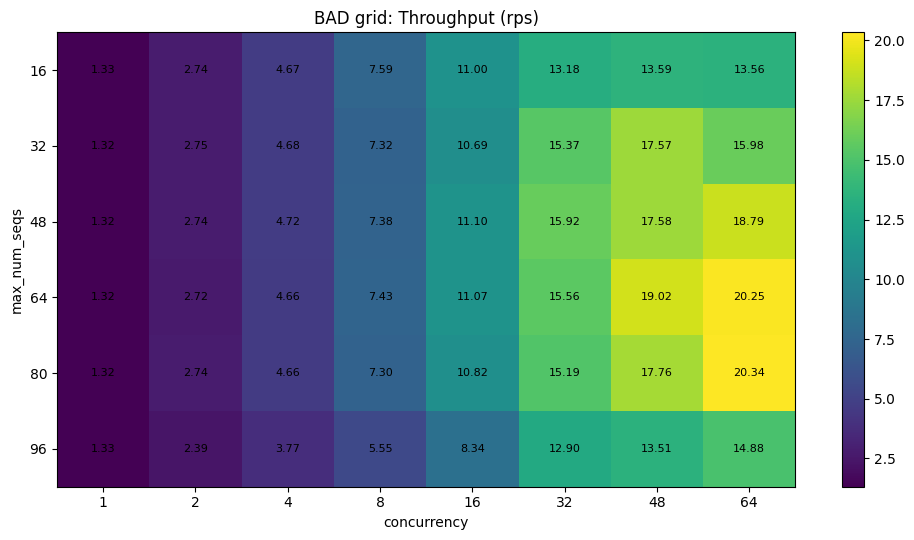

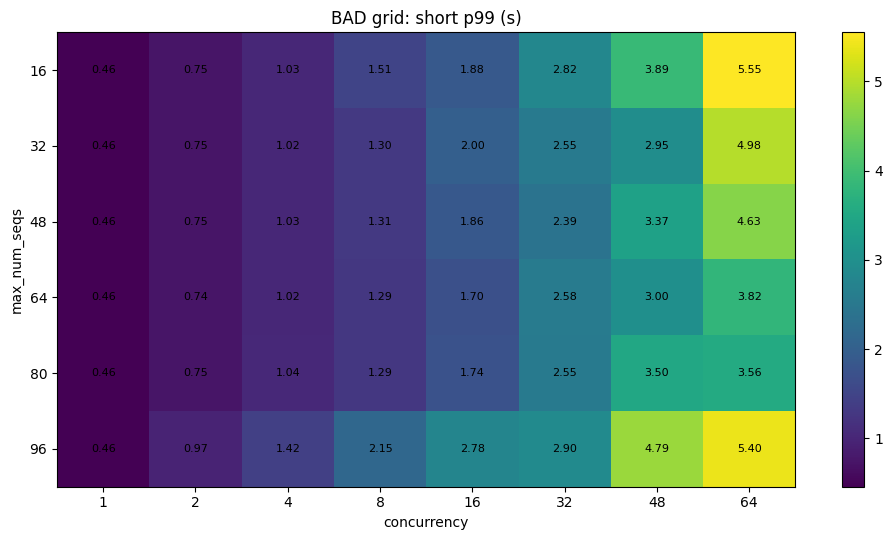

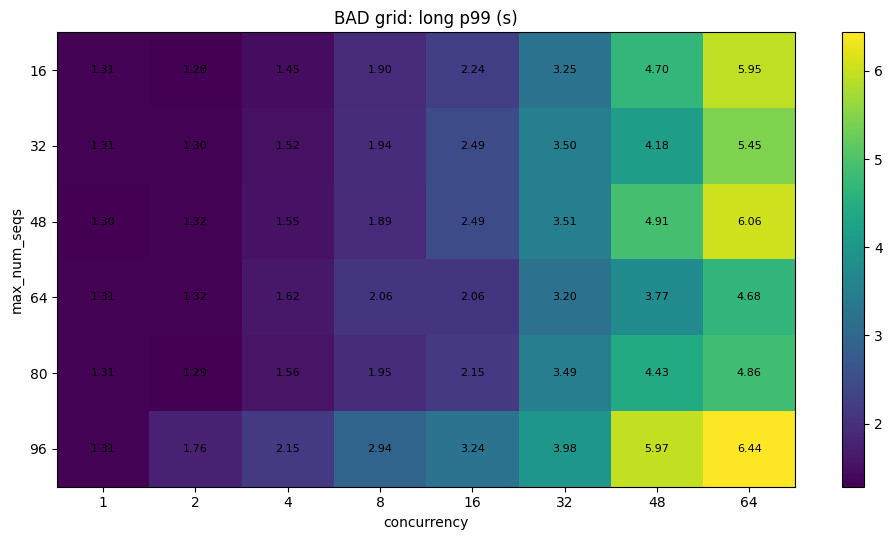

In [ ]:
def plot_heatmap(pivot_df, title, xlabel="concurrency", ylabel="max_num_seqs", fmt="{:.2f}"):
    """
    pivot_df: index=max_num_seqs, columns=concurrency, values=metric
    """
    data = pivot_df.values.astype(float)

    plt.figure(figsize=(10, 5.5))
    im = plt.imshow(data, aspect="auto", interpolation="nearest")
    plt.colorbar(im)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.xticks(ticks=np.arange(pivot_df.shape[1]), labels=pivot_df.columns.tolist())
    plt.yticks(ticks=np.arange(pivot_df.shape[0]), labels=pivot_df.index.tolist())


    for i in range(pivot_df.shape[0]):
        for j in range(pivot_df.shape[1]):
            val = data[i, j]
            if np.isfinite(val):
                plt.text(j, i, fmt.format(val), ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

# Heatmap: rps
p_rps = df.pivot_table(index="max_num_seqs", columns="concurrency", values="rps", aggfunc="mean")
plot_heatmap(p_rps, "BAD grid: Throughput (rps)")

# Heatmap: short_p99
p_sp99 = df.pivot_table(index="max_num_seqs", columns="concurrency", values="short_p99", aggfunc="mean")
plot_heatmap(p_sp99, "BAD grid: short p99 (s)")

# Heatmap: long_p99
p_lp99 = df.pivot_table(index="max_num_seqs", columns="concurrency", values="long_p99", aggfunc="mean")
plot_heatmap(p_lp99, "BAD grid: long p99 (s)")


## Heatmap Interpretaion


- **Throughput scales with concurrency until ~32–64**, but the gain after ~32 is smaller than the latency cost. You can see the plateau: rps improves from low concurrency to 32, then flattens for many max_num_seqs settings.

- **max_num_seqs acts like a capacity knob for concurrency.** At high concurrency (48–64), small max_num_seqs (like 16) cannot keep up, so both short and long p99 inflate. Mid-range values (around 64–80) sustain higher rps while keeping p99 lower.

- **Too large max_num_seqs can hurt.** The row at max_num_seqs = 96 shows lower throughput and much higher short and long p99 at high concurrency, consistent with extra batching/queueing overhead and heavier contention when you allow too many in-flight sequences.

- **Short requests still suffer under mixed workloads when scheduling is unfair.** Even though “short p99” is lower than “long p99”, it rises sharply with concurrency (especially at c=48–64), showing head-of-line blocking where long prefills delay short requests.

- **Practical “knee” region:** max_num_seqs around **64–80** with concurrency around **16–32** gives a better tradeoff. It keeps rps high without the steep tail-latency blow-up seen at the extreme high concurrency settings.


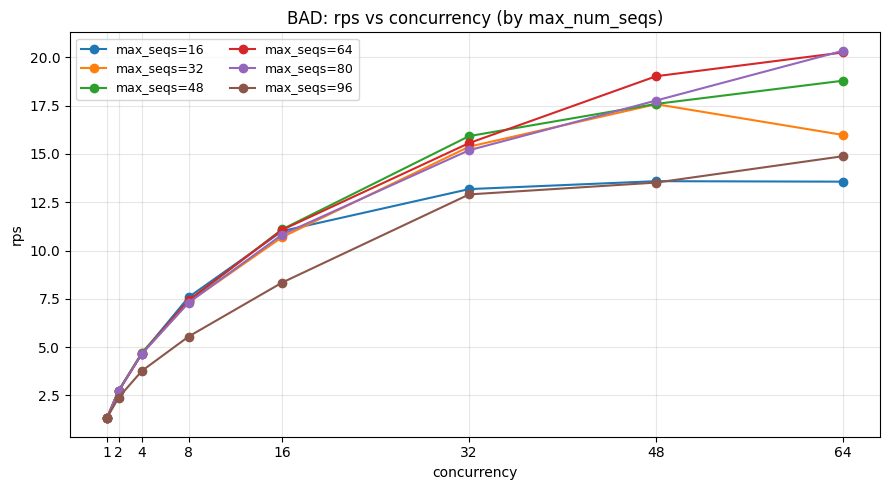

In [ ]:
plt.figure(figsize=(9, 5))
for m in max_num_seqs_list:
    sub = df[df["max_num_seqs"] == m].sort_values("concurrency")
    plt.plot(sub["concurrency"], sub["rps"], marker="o", label=f"max_seqs={m}")

plt.title("BAD: rps vs concurrency (by max_num_seqs)")
plt.xlabel("concurrency")
plt.ylabel("rps")
plt.xticks(concurrency_list)
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


## Interpretation: BAD configuration throughput (RPS) vs concurrency, grouped by max_num_seqs

- **RPS increases with concurrency for all settings up to ~16–32**, which is the “scaling region” where the GPU is getting better utilized as we add more in-flight work.

- **max_num_seqs controls how far you can scale before flattening.**
  - With **max_num_seqs=16**, the curve **plateaus early** (around concurrency 32) and stays near ~13–14 rps, meaning the server cannot admit enough parallel sequences to benefit from more client concurrency.
  - With **max_num_seqs=48/64/80**, the curves keep improving to higher concurrencies and reach the best throughput at the right edge (48–64).

- **The best throughput in this sweep occurs at high concurrency (48–64) with max_num_seqs around 64–80** (top curves near ~20 rps). That suggests this range is closer to the capacity point of this setup.

- **max_num_seqs=96 underperforms at low and mid concurrency and only partially catches up later.** This is consistent with “too many allowed in-flight sequences” adding overhead (more queueing, scheduling contention, memory pressure), so the system wastes efficiency instead of converting concurrency into throughput.

- **Diminishing returns are visible beyond ~48 concurrency**, even for the best max_num_seqs values. The slope flattens, meaning you are approaching saturation, and extra concurrency mostly increases queueing rather than throughput.


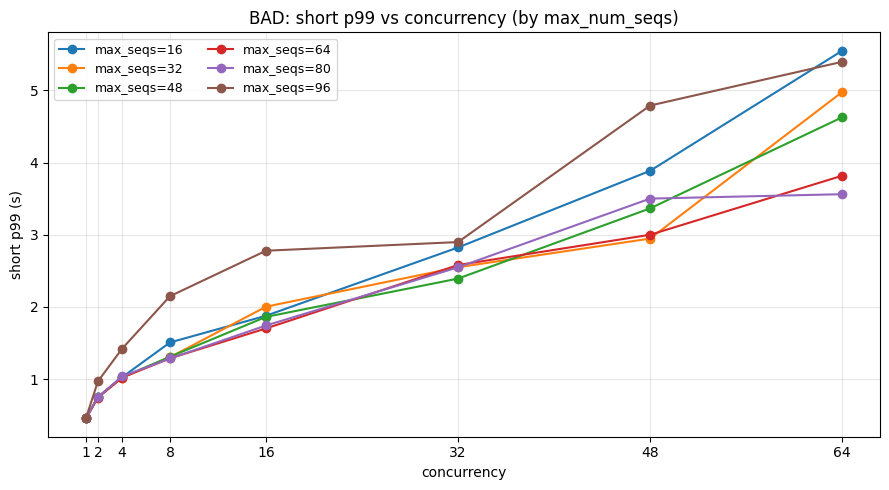

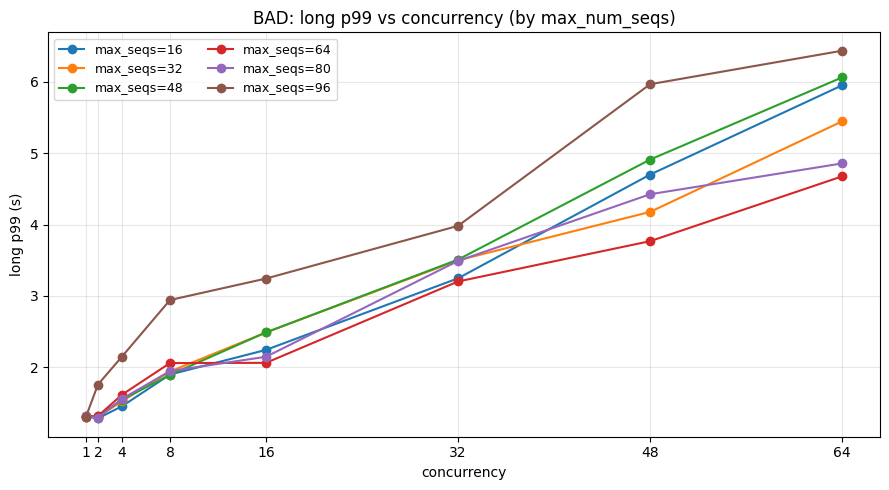

In [ ]:
# short p99
plt.figure(figsize=(9, 5))
for m in max_num_seqs_list:
    sub = df[df["max_num_seqs"] == m].sort_values("concurrency")
    plt.plot(sub["concurrency"], sub["short_p99"], marker="o", label=f"max_seqs={m}")

plt.title("BAD: short p99 vs concurrency (by max_num_seqs)")
plt.xlabel("concurrency")
plt.ylabel("short p99 (s)")
plt.xticks(concurrency_list)
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# long p99
plt.figure(figsize=(9, 5))
for m in max_num_seqs_list:
    sub = df[df["max_num_seqs"] == m].sort_values("concurrency")
    plt.plot(sub["concurrency"], sub["long_p99"], marker="o", label=f"max_seqs={m}")

plt.title("BAD: long p99 vs concurrency (by max_num_seqs)")
plt.xlabel("concurrency")
plt.ylabel("long p99 (s)")
plt.xticks(concurrency_list)
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


## Interpretation: BAD short p99 vs concurrency and BAD long p99 vs concurrency

- For both short and long requests, **p99 increases monotonically with concurrency**. This is classic queueing behavior: higher offered load increases worst-case wait time.
- **Short p99 inflates sharply at high concurrency** (c=48, c=64), showing that short requests lose their "fast path" when mixed with long prompts under unfair scheduling.
- **Long p99 also climbs steadily**, and it typically climbs faster than short p99 because long prompts contribute more prefill work and hold resources longer.
- **max_num_seqs=64 (and sometimes 80) provides a better tradeoff** than 16/32 (too restrictive) and 96 (too aggressive): higher throughput without blowing up p99 as badly as the overcommitted setting.


# Expermient 5: Creating Fair Scheduling to improve the latency and RPS (or the trade-off)

## Fair sanity check: lower max-num-batched-tokens (btok=768) at c=32

Before running the full FAIR sweeps, I ran a single controlled trial by reducing `max-num-batched-tokens` from the BAD baseline (8192) down to **768**, while keeping everything else identical and evaluating at the **same client concurrency (c=32)** used for the BAD runs.

- **Purpose:** verify that `max-num-batched-tokens` is a meaningful lever under mixed 50/50 traffic, and that lowering it can reduce the “long-prefill domination” effect that inflates tail latency.
- **Why 768:** it’s a mid-range value expected to encourage more frequent scheduling turns (smaller batches), which can improve responsiveness for short requests in mixed workloads.
- **Why c=32:** match the BAD configuration’s stress level so the comparison is apples-to-apples and any improvement is not just because the system is under-loaded.


In [ ]:
!pkill -f "vllm.entrypoints.openai.api_server" || true
!pkill -f "VLLM::EngineCore" || true
!rm -f vllm_fair.log
!sleep 1


In [ ]:

!nohup python3 -m vllm.entrypoints.openai.api_server \
  --model Qwen/Qwen2.5-3B-Instruct \
  --host 127.0.0.1 --port 8000 \
  --dtype half \
  --max-model-len 4096 \
  --gpu-memory-utilization 0.70 \
  --disable-log-stats \
  --enforce-eager \
  --max-num-batched-tokens 768 \
  --long-prefill-token-threshold 1024 \
  > vllm_fair.log 2>&1 </dev/null &

^C
^C


In [ ]:
!tail -n 40 vllm_fair.log


(APIServer pid=22255) INFO 01-10 15:52:09 [launcher.py:38] Available routes are:
(APIServer pid=22255) INFO 01-10 15:52:09 [launcher.py:46] Route: /openapi.json, Methods: GET, HEAD
(APIServer pid=22255) INFO 01-10 15:52:09 [launcher.py:46] Route: /docs, Methods: GET, HEAD
(APIServer pid=22255) INFO 01-10 15:52:09 [launcher.py:46] Route: /docs/oauth2-redirect, Methods: GET, HEAD
(APIServer pid=22255) INFO 01-10 15:52:09 [launcher.py:46] Route: /redoc, Methods: GET, HEAD
(APIServer pid=22255) INFO 01-10 15:52:09 [launcher.py:46] Route: /scale_elastic_ep, Methods: POST
(APIServer pid=22255) INFO 01-10 15:52:09 [launcher.py:46] Route: /is_scaling_elastic_ep, Methods: POST
(APIServer pid=22255) INFO 01-10 15:52:09 [launcher.py:46] Route: /tokenize, Methods: POST
(APIServer pid=22255) INFO 01-10 15:52:09 [launcher.py:46] Route: /detokenize, Methods: POST
(APIServer pid=22255) INFO 01-10 15:52:09 [launcher.py:46] Route: /inference/v1/generate, Methods: POST
(APIServer pid=22255) INFO 01-10 15

In [ ]:
df_fair_50_50, summ_fair_50_50 = run_load(
    prompt_sets["mix_50_50.jsonl"],
    concurrency=32,
    total_requests=200,
    desired_max_tokens=16,
    desc="FAIR_protected | mix_50_50 | c=16"
)

print("FAIR summary:", summ_fair_50_50)
df_fair_50_50.head()


FAIR_protected | mix_50_50 | c=16:   0%|          | 0/200 [00:00<?, ?it/s]

FAIR summary: {'concurrency': 32, 'total_requests': 200, 'ok': 200, 'fail': 0, 'wall_time_s': 41.268839522000235, 'rps': 4.84627148028674, 'p50_s': 6.04282219300012, 'p90_s': 9.18175588419981, 'p99_s': 11.05694531869025, 'mean_s': 6.266493499729964}


latency_s  prompt_tokens  completion_tokens  total_tokens  status_code  \
0   3.036116             37                 16            53          200   
1   3.129861             37                 16            53          200   
2   3.074753             45                 16            61          200   
3   3.092510             37                 16            53          200   
4   3.141762             38                 16            54          200   

   prompt_tokens_est  max_tokens_used  trimmed  prompt_tokens_est_original  \
0                 37               16     True                          37   
1                 37               16     True                          37   
2                 45               16     True                          45   
3                 37               16     True                          37   
4                 38               16     True                          38   

   original_prompt_len_chars  final_prompt_len_chars    ok  
0                         36                      36  True  
1                         36                      36  True  
2                         72                      72  True  
3                         38                      38  True  
4                         38                      38  True

In [ ]:

def latency_stats(df, label, mask, subset_name):
    x = df.loc[mask & (df["ok"] == True), "latency_s"].dropna().values
    if len(x) == 0:
        return {"label": label, "subset": subset_name, "n": 0, "p50": None, "p90": None, "p99": None, "mean": None}
    return {
        "label": label,
        "subset": subset_name,
        "n": int(len(x)),
        "p50": float(np.quantile(x, 0.50)),
        "p90": float(np.quantile(x, 0.90)),
        "p99": float(np.quantile(x, 0.99)),
        "mean": float(np.mean(x)),
    }

def compare_short_long(df, label, short_cut=64, long_cut=2048):
    return [
        latency_stats(df, label, mask=df["prompt_tokens"] >= 0, subset_name="overall"),
        latency_stats(df, label, mask=df["prompt_tokens"] <= short_cut, subset_name=f"short<= {short_cut}"),
        latency_stats(df, label, mask=df["prompt_tokens"] >= long_cut, subset_name=f"long>= {long_cut}"),
    ]

bad_stats  = compare_short_long(df_bad,  "BAD_unfair", short_cut=64, long_cut=2048)
fair_stats = compare_short_long(df_fair_50_50, "FAIR_768", short_cut=64, long_cut=2048)

bad_stats, fair_stats


([{'label': 'BAD_unfair',
   'subset': 'overall',
   'n': 200,
   'p50': 5.534205468999517,
   'p90': 10.461404818999926,
   'p99': 11.045583048669595,
   'mean': 6.076663721505029},
  {'label': 'BAD_unfair',
   'subset': 'short<= 64',
   'n': 108,
   'p50': 4.6954104774999905,
   'p90': 8.427761869799998,
   'p99': 10.15342957642024,
   'mean': 5.170086654425977},
  {'label': 'BAD_unfair',
   'subset': 'long>= 2048',
   'n': 92,
   'p50': 7.038852010499795,
   'p90': 10.96015420079957,
   'p99': 11.058848744559482,
   'mean': 7.140906365467394}],
 [{'label': 'FAIR_768',
   'subset': 'overall',
   'n': 200,
   'p50': 6.04282219300012,
   'p90': 9.18175588419981,
   'p99': 11.05694531869025,
   'mean': 6.266493499729964},
  {'label': 'FAIR_768',
   'subset': 'short<= 64',
   'n': 108,
   'p50': 5.629765399999542,
   'p90': 8.433177871999579,
   'p99': 10.081671103819572,
   'mean': 5.578912106185119},
  {'label': 'FAIR_768',
   'subset': 'long>= 2048',
   'n': 92,
   'p50': 7.1285672229

## Conclusion: btok = 768 and c = 32

- **Overall:** FAIR_768 slightly **hurts median** (p50: 6.04s vs 5.53s) but **improves p90** (9.18s vs 10.46s). **p99 is basically unchanged** (~11.06s in both).
- **Short requests (≤64 tokens):** FAIR_768 **slows p50** (5.63s vs 4.70s) but gives a **small p99 improvement** (10.08s vs 10.15s). Net: better tail for short, worse typical latency.
- **Long requests (≥2048 tokens):** FAIR_768 **improves p90** (10.00s vs 10.96s) while **p99 stays ~the same** (11.11s vs 11.06s). This suggests btok=768 reduces “most long requests” queueing, but the worst-case is still dominated by contention.
- **Implication:** Lowering `max-num-batched-tokens` to 768 shifts the distribution (especially **p90**) but doesn’t meaningfully reduce the **worst-case p99** at this concurrency—so a sweep is needed to find the btok “sweet spot” that improves tails without sacrificing too much throughput.


## `max-num-batched-token` Sweep @ c = 16

In [ ]:
BASE = "http://127.0.0.1:8000"
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"

def kill_server():
    os.system('pkill -f "vllm.entrypoints.openai.api_server" || true')
    os.system('pkill -f "VLLM::EngineCore" || true')
    time.sleep(1.5)

def start_fair_server(max_btok, log_path="vllm_fair.log"):
    # clean + restart
    kill_server()
    try:
        os.remove(log_path)
    except FileNotFoundError:
        pass

    cmd = f"""
nohup python3 -m vllm.entrypoints.openai.api_server \
  --model {MODEL_ID} \
  --host 127.0.0.1 --port 8000 \
  --dtype half \
  --max-model-len 4096 \
  --gpu-memory-utilization 0.70 \
  --disable-log-stats \
  --enforce-eager \
  --max-num-batched-tokens {int(max_btok)} \
  --long-prefill-token-threshold 1024 \
  > {log_path} 2>&1 </dev/null &
"""
    os.system(cmd)
    time.sleep(1.0)

def tail_log(log_path, n=60):
    if os.path.exists(log_path):
        print(f"\n--- tail {log_path} (last {n}) ---")
        os.system(f"tail -n {n} {log_path}")
    else:
        print(f"(log missing: {log_path})")

def wait_for_ready(base=BASE, log_path="vllm_fair.log", timeout_s=300):
    t0 = time.time()
    tries = 0
    while True:
        tries += 1
        try:
            r = requests.get(f"{base}/v1/models", timeout=2)
            if r.status_code == 200:
                data = r.json().get("data", [])
                ids = [m.get("id") for m in data]
                print(f"✅ Server ready. Models: {ids}")
                return True
            else:
                print(f"[{tries}] /v1/models status={r.status_code}")
        except Exception as e:
            print(f"[{tries}] not ready yet: {type(e).__name__}")

        # if process died, fail fast
        alive = os.system('ps -ef | grep -E "vllm.entrypoints.openai.api_server" | grep -v grep > /dev/null') == 0
        if not alive:
            print("❌ vLLM process is NOT running anymore.")
            tail_log(log_path, n=120)
            return False

        if time.time() - t0 > timeout_s:
            print("❌ Timed out waiting for server.")
            tail_log(log_path, n=120)
            return False

        if tries % 5 == 0:
            tail_log(log_path, n=30)

        time.sleep(2)

def warmup_request():
    # forces one small request to populate caches
    payload = {
        "model": MODEL_ID,
        "messages": [{"role": "user", "content": "hi"}],
        "max_tokens": 8,
        "temperature": 0.0
    }
    try:
        _ = requests.post(f"{BASE}/v1/chat/completions", json=payload, timeout=30)
    except Exception:
        pass



#  Sweep runner

WL_FILE = "mix_50_50.jsonl"
CONCURRENCY = 16
TOTAL_REQ = 400
DESIRED_MAX_TOKENS = 16

btok_list = [256, 384, 512, 768, 1024, 1536, 2048]  # edit as you like
rows = []
fair_runs = {}

for btok in btok_list:
    print(f"\n==============================")
    print(f"Starting FAIR server: max-num-batched-tokens={btok}")
    print(f"==============================")

    start_fair_server(btok, log_path="vllm_fair.log")

    ok = wait_for_ready(BASE, log_path="vllm_fair.log", timeout_s=420)
    if not ok:
        rows.append({
            "label": "FAIR",
            "workload": WL_FILE,
            "concurrency": CONCURRENCY,
            "max_num_batched_tokens": btok,
            "status": "server_failed"
        })
        continue

    warmup_request()

    df_fair, summ_fair = run_load(
        prompt_sets[WL_FILE],
        concurrency=CONCURRENCY,
        total_requests=TOTAL_REQ,
        desired_max_tokens=DESIRED_MAX_TOKENS,
        desc=f"FAIR | {WL_FILE} | c={CONCURRENCY} | btok={btok}"
    )

    fair_runs[btok] = (df_fair, summ_fair)

    m = subset_metrics(df_fair)

    rows.append({
        "label": "FAIR",
        "workload": WL_FILE,
        "concurrency": CONCURRENCY,
        "max_num_batched_tokens": btok,
        "status": "ok",
        "ok_count": int((df_fair["ok"] == True).sum()),
        "fail_count": int((df_fair["ok"] != True).sum()),
        "p50_s": float(df_fair[df_fair["ok"]==True]["latency_s"].quantile(0.50)),
        "p90_s": float(df_fair[df_fair["ok"]==True]["latency_s"].quantile(0.90)),
        "p99_s": float(df_fair[df_fair["ok"]==True]["latency_s"].quantile(0.99)),
        "mean_s": float(df_fair[df_fair["ok"]==True]["latency_s"].mean()),
        **m
    })


kill_server()

fair_summary_df = pd.DataFrame(rows)
print("\n✅ FAIR btok sweep done.")
fair_summary_df



Starting FAIR server: max-num-batched-tokens=256
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready.

FAIR | mix_50_50.jsonl | c=16 | btok=256:   0%|          | 0/400 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=384
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready 

FAIR | mix_50_50.jsonl | c=16 | btok=384:   0%|          | 0/400 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=512
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready.

FAIR | mix_50_50.jsonl | c=16 | btok=512:   0%|          | 0/400 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=768
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready.

FAIR | mix_50_50.jsonl | c=16 | btok=768:   0%|          | 0/400 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=1024
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready

FAIR | mix_50_50.jsonl | c=16 | btok=1024:   0%|          | 0/400 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=1536
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready

FAIR | mix_50_50.jsonl | c=16 | btok=1536:   0%|          | 0/400 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=2048
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready

FAIR | mix_50_50.jsonl | c=16 | btok=2048:   0%|          | 0/400 [00:00<?, ?it/s]


✅ FAIR btok sweep done.


label         workload  concurrency  max_num_batched_tokens status  \
0  FAIR  mix_50_50.jsonl           16                     256     ok   
1  FAIR  mix_50_50.jsonl           16                     384     ok   
2  FAIR  mix_50_50.jsonl           16                     512     ok   
3  FAIR  mix_50_50.jsonl           16                     768     ok   
4  FAIR  mix_50_50.jsonl           16                    1024     ok   
5  FAIR  mix_50_50.jsonl           16                    1536     ok   
6  FAIR  mix_50_50.jsonl           16                    2048     ok   

   ok_count  fail_count     p50_s     p90_s     p99_s  ...  overall_p99  \
0       400           0  3.917620  6.003256  7.490066  ...     7.490066   
1       400           0  3.789676  6.003093  7.391527  ...     7.391527   
2       400           0  3.275586  5.115305  6.397388  ...     6.397388   
3       400           0  3.206392  4.961443  6.085882  ...     6.085882   
4       400           0  3.165028  5.063683  6.221846  ...     6.221846   
5       400           0  3.112720  4.985570  6.045147  ...     6.045147   
6       400           0  2.877141  4.879512  5.880604  ...     5.880604   

   overall_mean  short_n  short_p50  short_p90  short_p99  long_n  long_p50  \
0      3.909862      219   3.230642   5.430116   6.209954     181  4.435861   
1      3.873967      219   3.062236   5.282700   6.146763     181  4.459937   
2      3.331515      219   2.742682   4.518725   5.412965     181  3.902552   
3      3.222704      219   2.496879   4.252760   5.780472     181  3.817410   
4      3.276949      219   2.627720   4.264552   5.456294     181  3.878716   
5      3.153403      219   2.298252   3.957246   5.713906     181  4.125251   
6      3.091901      219   2.363636   3.867254   5.054890     181  3.717427   

   long_p90  long_p99  
0  6.198407  7.641955  
1  6.214115  7.543956  
2  5.332178  6.979876  
3  5.325118  6.490589  
4  5.402732  6.348548  
5  5.409860  6.194904  
6  5.357849  5.966436  

[7 rows x 24 columns]

In [ ]:
import os, time, requests
import pandas as pd
import numpy as np

BASE = "http://127.0.0.1:8000"
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"


def subset_metrics(df, short_cutoff=64, long_cutoff=3500):
    ok = df[df["ok"] == True].copy()

    def _q(s, p):
        if len(s) == 0:
            return None
        return float(s.quantile(p))

    overall = {
        "overall_n": int(len(ok)),
        "overall_p50": _q(ok["latency_s"], 0.50),
        "overall_p90": _q(ok["latency_s"], 0.90),
        "overall_p99": _q(ok["latency_s"], 0.99),
        "overall_mean": float(ok["latency_s"].mean()) if len(ok) else None,
    }

    short = ok[ok["prompt_tokens"] <= short_cutoff]
    short_stats = {
        "short_n": int(len(short)),
        "short_p50": _q(short["latency_s"], 0.50),
        "short_p90": _q(short["latency_s"], 0.90),
        "short_p99": _q(short["latency_s"], 0.99),
        "short_mean": float(short["latency_s"].mean()) if len(short) else None,
    }

    long_ = ok[ok["prompt_tokens"] >= long_cutoff]
    long_stats = {
        "long_n": int(len(long_)),
        "long_p50": _q(long_["latency_s"], 0.50),
        "long_p90": _q(long_["latency_s"], 0.90),
        "long_p99": _q(long_["latency_s"], 0.99),
        "long_mean": float(long_["latency_s"].mean()) if len(long_) else None,
    }

    out = {}
    out.update(overall)
    out.update(short_stats)
    out.update(long_stats)
    return out



def kill_server():
    os.system('pkill -f "vllm.entrypoints.openai.api_server" || true')
    os.system('pkill -f "VLLM::EngineCore" || true')
    time.sleep(1.5)

def start_fair_server(max_btok, log_path="vllm_fair.log"):
    kill_server()
    try:
        os.remove(log_path)
    except FileNotFoundError:
        pass

    cmd = f"""
nohup python3 -m vllm.entrypoints.openai.api_server \
  --model {MODEL_ID} \
  --host 127.0.0.1 --port 8000 \
  --dtype half \
  --max-model-len 4096 \
  --gpu-memory-utilization 0.70 \
  --disable-log-stats \
  --enforce-eager \
  --max-num-batched-tokens {int(max_btok)} \
  --long-prefill-token-threshold 1024 \
  > {log_path} 2>&1 </dev/null &
"""
    os.system(cmd)
    time.sleep(1.0)

def tail_log(log_path, n=60):
    if os.path.exists(log_path):
        print(f"\n--- tail {log_path} (last {n}) ---")
        os.system(f"tail -n {n} {log_path}")

def wait_for_ready(base=BASE, log_path="vllm_fair.log", timeout_s=420):
    t0 = time.time()
    tries = 0
    while True:
        tries += 1
        try:
            r = requests.get(f"{base}/v1/models", timeout=2)
            if r.status_code == 200:
                data = r.json().get("data", [])
                ids = [m.get("id") for m in data]
                print(f"✅ Server ready. Models: {ids}")
                return True
        except Exception as e:
            print(f"[{tries}] not ready yet: {type(e).__name__}")

        alive = os.system('ps -ef | grep -E "vllm.entrypoints.openai.api_server" | grep -v grep > /dev/null') == 0
        if not alive:
            print("❌ vLLM process is NOT running anymore.")
            tail_log(log_path, n=120)
            return False

        if time.time() - t0 > timeout_s:
            print("❌ Timed out waiting for server.")
            tail_log(log_path, n=120)
            return False

        if tries % 5 == 0:
            tail_log(log_path, n=30)

        time.sleep(2)

def warmup_request():
    payload = {
        "model": MODEL_ID,
        "messages": [{"role": "user", "content": "hi"}],
        "max_tokens": 8,
        "temperature": 0.0
    }
    try:
        _ = requests.post(f"{BASE}/v1/chat/completions", json=payload, timeout=30)
    except Exception:
        pass




WL_FILE = "mix_50_50.jsonl"
CONCURRENCY = 32
TOTAL_REQ = 200
DESIRED_MAX_TOKENS = 16


btok_list = [256, 384, 512, 768, 1024, 1536, 2048, 3072, 4096, 6144, 8192]

rows = []
fair_runs = {}

for btok in btok_list:
    print(f"\n==============================")
    print(f"Starting FAIR server: max-num-batched-tokens={btok}")
    print(f"==============================")

    start_fair_server(btok, log_path="vllm_fair.log")

    ok = wait_for_ready(BASE, log_path="vllm_fair.log", timeout_s=420)
    if not ok:
        rows.append({
            "label": "FAIR",
            "workload": WL_FILE,
            "concurrency": CONCURRENCY,
            "max_num_batched_tokens": btok,
            "status": "server_failed"
        })
        continue

    warmup_request()

    df_fair, summ_fair = run_load(
        prompt_sets[WL_FILE],
        concurrency=CONCURRENCY,
        total_requests=TOTAL_REQ,
        desired_max_tokens=DESIRED_MAX_TOKENS,
        desc=f"FAIR | {WL_FILE} | c={CONCURRENCY} | btok={btok}"
    )

    fair_runs[btok] = (df_fair, summ_fair)

    # subset metrics + safe latency stats
    m = subset_metrics(df_fair, short_cutoff=64, long_cutoff=3500)
    ok_df = df_fair[df_fair["ok"] == True]

    # rps/wall_time from summary (safe if missing)
    rps = summ_fair.get("rps", None)
    wall = summ_fair.get("wall_time_s", None)

    rows.append({
        "label": "FAIR",
        "workload": WL_FILE,
        "concurrency": CONCURRENCY,
        "max_num_batched_tokens": btok,
        "status": "ok",

        "ok_count": int((df_fair["ok"] == True).sum()),
        "fail_count": int((df_fair["ok"] != True).sum()),

        # added throughput fields
        "rps": float(rps) if rps is not None else None,
        "wall_time_s": float(wall) if wall is not None else None,

        "p50_s": float(ok_df["latency_s"].quantile(0.50)) if len(ok_df) else None,
        "p90_s": float(ok_df["latency_s"].quantile(0.90)) if len(ok_df) else None,
        "p99_s": float(ok_df["latency_s"].quantile(0.99)) if len(ok_df) else None,
        "mean_s": float(ok_df["latency_s"].mean()) if len(ok_df) else None,

        **m
    })


kill_server()

fair_summary_df = pd.DataFrame(rows)
print("\n✅ FAIR btok sweep done.")
fair_summary_df



Starting FAIR server: max-num-batched-tokens=256
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready.

FAIR | mix_50_50.jsonl | c=32 | btok=256:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=384
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready.

FAIR | mix_50_50.jsonl | c=32 | btok=384:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=512
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready 

FAIR | mix_50_50.jsonl | c=32 | btok=512:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=768
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready.

FAIR | mix_50_50.jsonl | c=32 | btok=768:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=1024
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready

FAIR | mix_50_50.jsonl | c=32 | btok=1024:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=1536
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready

FAIR | mix_50_50.jsonl | c=32 | btok=1536:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=2048
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready

FAIR | mix_50_50.jsonl | c=32 | btok=2048:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=3072
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready

FAIR | mix_50_50.jsonl | c=32 | btok=3072:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=4096
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready

FAIR | mix_50_50.jsonl | c=32 | btok=4096:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=6144
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready

FAIR | mix_50_50.jsonl | c=32 | btok=6144:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server: max-num-batched-tokens=8192
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready

FAIR | mix_50_50.jsonl | c=32 | btok=8192:   0%|          | 0/200 [00:00<?, ?it/s]


✅ FAIR btok sweep done.


label         workload  concurrency  max_num_batched_tokens status  \
0   FAIR  mix_50_50.jsonl           32                     256     ok   
1   FAIR  mix_50_50.jsonl           32                     384     ok   
2   FAIR  mix_50_50.jsonl           32                     512     ok   
3   FAIR  mix_50_50.jsonl           32                     768     ok   
4   FAIR  mix_50_50.jsonl           32                    1024     ok   
5   FAIR  mix_50_50.jsonl           32                    1536     ok   
6   FAIR  mix_50_50.jsonl           32                    2048     ok   
7   FAIR  mix_50_50.jsonl           32                    3072     ok   
8   FAIR  mix_50_50.jsonl           32                    4096     ok   
9   FAIR  mix_50_50.jsonl           32                    6144     ok   
10  FAIR  mix_50_50.jsonl           32                    8192     ok   

    ok_count  fail_count       rps  wall_time_s     p50_s  ...  short_n  \
0        200           0  3.968775    50.393380  8.030764  ...      108   
1        200           0  4.213007    47.472030  7.573981  ...      108   
2        200           0  4.897244    40.839298  6.548973  ...      108   
3        200           0  4.987193    40.102719  6.471648  ...      108   
4        200           0  5.040940    39.675140  6.254756  ...      108   
5        200           0  5.232841    38.220158  5.971958  ...      108   
6        200           0  5.461870    36.617497  5.305476  ...      108   
7        200           0  5.480285    36.494454  5.126561  ...      108   
8        200           0  5.356887    37.335120  5.362229  ...      108   
9        200           0  5.252920    38.074062  6.087259  ...      108   
10       200           0  5.243340    38.143628  5.762486  ...      108   

    short_p50  short_p90  short_p99  short_mean  long_n  long_p50   long_p90  \
0    6.835840  10.755014  12.854326    6.408663      92  8.699075  12.771936   
1    6.504703  10.084012  12.070611    6.097060      92  8.179299  11.920281   
2    5.574814   8.666509  10.385283    5.264652      92  7.076204  10.680524   
3    5.485829   8.449879  10.094231    5.282323      92  6.945431  10.354277   
4    5.377607   8.483696  10.541172    5.299665      92  6.957520  10.273009   
5    5.323622   8.471957  10.808859    4.949558      92  7.026540  10.495543   
6    4.614040   8.893801  10.684957    4.779464      92  6.437848  10.193996   
7    3.940538   8.337370  12.466926    4.674823      92  5.975895  12.025077   
8    3.878399   8.924416  12.651472    4.689062      92  6.525861  13.001420   
9    3.941492   9.234577  10.074812    4.615928      92  6.497619  10.800588   
10   4.709529   8.167315  10.168693    4.584386      92  6.440498  11.189300   

     long_p99  long_mean  
0   14.228444   8.689737  
1   13.324357   8.211755  
2   11.587312   7.141176  
3   11.662259   7.037242  
4   11.583068   7.015300  
5   12.135595   7.090914  
6   12.465500   6.814218  
7   13.201842   6.775633  
8   14.277313   7.106377  
9   12.740196   7.705792  
10  13.953629   7.773084  

[11 rows x 28 columns]

## Conclusion: `btok` Sweep @ c= 16

- **Even at lower concurrency (FAIR sweep at `c=16`), FAIR is dramatically better than the BAD baseline you saw (BAD at `c=32`).**  
  _Not an apples-to-apples comparison due to different `concurrency`, but it’s still a strong signal that the FAIR knob is addressing the bottleneck._  
  - Overall **p99: 11.05s (BAD) → 5.88s (FAIR @ btok=2048)** (≈ **46.8%** lower)  
  - Overall **p90: 10.46s (BAD) → 4.88s (FAIR @ btok=2048)** (≈ **53.3%** lower)  
  - Overall **p50: 5.53s (BAD) → 2.88s (FAIR @ btok=2048)** (≈ **47.9%** lower)  
  - Overall **mean: 6.08s (BAD) → 3.09s (FAIR @ btok=2048)** (≈ **49.2%** lower)

- **Short and long tails both improve vs BAD (still with the same cross-concurrency caveat).**  
  - Short **p99: 10.15s (BAD) → 5.05s (FAIR @ btok=2048)** (≈ **50.2%** lower)  
  - Long **p99: 11.06s (BAD) → 5.97s (FAIR @ btok=2048)** (≈ **46.0%** lower)

- **Within the FAIR sweep itself (`c=16`), tail latency improves as `max-num-batched-tokens` increases (256 → 2048).**  
  - Overall **p99: 7.49s → 5.88s** (≈ **21.5%** lower)  
  - Long **p99: 7.64s → 5.97s** (≈ **21.9%** lower)  
  This strongly suggests the server was **prefill-throttled** at low btok.

- **Not just tail — median improves too (FAIR `c=16`, 256 → 2048).**  
  - Overall **p50: 3.92s → 2.88s** (≈ **26.6%** lower)  
  - Overall **p90: 6.00s → 4.88s** (≈ **18.7%** lower)  



## Caveat: concurrency confounds the BAD vs FAIR comparison
- The BAD baseline numbers were measured at **`concurrency=32`**, while this FAIR btok sweep was run at **`concurrency=16`**.
- Lower concurrency reduces queueing pressure by itself, so part of the latency improvement could be explained by **less load**, not only by better batching/scheduling.
- To isolate the effect of server knobs, we need an apples-to-apples sweep at **the same concurrency**.

### What to do next (to remove the confound)
- Re-run the btok sweep at **`concurrency=32`** (same workload and request count) to validate whether the btok trend holds at the real comparison point.
- Then run a **2D grid sweep** at `c=32` over:
  - `max-num-batched-tokens` (controls prefill batching / throughput)
  - `max-num-seqs` (controls how many sequences can be in-flight; too low underutilizes, too high overcommits)
- This will let us attribute changes correctly:
  - If FAIR still wins at `c=32`, the gains are genuinely from scheduling/batching.
  - If FAIR only wins at lower `c`, the improvement is mostly due to reduced load rather than config.


In [ ]:
output_path = os.path.join(DRIVE_OUT_DIR, "fair_scheduling_sweep_summary.csv")
fair_summary_df.to_csv(output_path, index=False)
print(f"✅ Saved fair_summary_df to Drive: {output_path}")

✅ Saved fair_summary_df to Drive: /content/drive/MyDrive/llm_loadtest_workloads/fair_scheduling_sweep_summary.csv


In [ ]:
import os, time, json, requests
import pandas as pd

BASE = "http://127.0.0.1:8000"
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"


CHECKPOINT_CSV = "fair_grid_checkpoint.csv"
MANIFEST_JSON  = "fair_grid_manifest.json"


def kill_server():
    os.system('pkill -f "vllm.entrypoints.openai.api_server" || true')
    os.system('pkill -f "VLLM::EngineCore" || true')
    time.sleep(1.5)

def tail_log(log_path, n=80):
    if os.path.exists(log_path):
        print(f"\n--- tail {log_path} (last {n}) ---")
        os.system(f"tail -n {n} {log_path}")
    else:
        print(f"(log missing: {log_path})")

def wait_for_ready(base=BASE, log_path="vllm_fair.log", timeout_s=480):
    t0 = time.time()
    tries = 0
    while True:
        tries += 1
        try:
            r = requests.get(f"{base}/v1/models", timeout=2)
            if r.status_code == 200:
                data = r.json().get("data", [])
                ids = [m.get("id") for m in data]
                print(f"✅ Server ready. Models: {ids}")
                return True
            else:
                print(f"[{tries}] /v1/models status={r.status_code}")
        except Exception:
            print(f"[{tries}] not ready yet: ConnectionError")

        alive = os.system('ps -ef | grep -E "vllm.entrypoints.openai.api_server" | grep -v grep > /dev/null') == 0
        if not alive:
            print("❌ vLLM process is NOT running anymore.")
            tail_log(log_path, n=160)
            return False

        if time.time() - t0 > timeout_s:
            print("❌ Timed out waiting for server.")
            tail_log(log_path, n=160)
            return False

        if tries % 5 == 0:
            tail_log(log_path, n=30)

        time.sleep(2)

def warmup_request():
    payload = {
        "model": MODEL_ID,
        "messages": [{"role": "user", "content": "hi"}],
        "max_tokens": 8,
        "temperature": 0.0,
    }
    try:
        _ = requests.post(f"{BASE}/v1/chat/completions", json=payload, timeout=30)
    except Exception:
        pass

def start_fair_server(max_btok, max_num_seqs, log_path="vllm_fair.log"):
    kill_server()
    try:
        os.remove(log_path)
    except FileNotFoundError:
        pass

    cmd = f"""
nohup python3 -m vllm.entrypoints.openai.api_server \
  --model {MODEL_ID} \
  --host 127.0.0.1 --port 8000 \
  --dtype half \
  --max-model-len 4096 \
  --gpu-memory-utilization 0.70 \
  --disable-log-stats \
  --enforce-eager \
  --max-num-batched-tokens {int(max_btok)} \
  --max-num-seqs {int(max_num_seqs)} \
  --long-prefill-token-threshold 1024 \
  > {log_path} 2>&1 </dev/null &
"""
    os.system(cmd)
    time.sleep(1.0)



def _safe_quantile(series, q):
    if series is None or len(series) == 0:
        return None
    return float(series.quantile(q))

def _safe_mean(series):
    if series is None or len(series) == 0:
        return None
    return float(series.mean())

def subset_metrics(df, short_cutoff_tokens=64, long_cutoff_tokens=2048):
    ok = df[df["ok"] == True].copy()
    lat = ok["latency_s"]

    out = {
        "overall_n": int(len(ok)),
        "overall_p50": _safe_quantile(lat, 0.50),
        "overall_p90": _safe_quantile(lat, 0.90),
        "overall_p99": _safe_quantile(lat, 0.99),
        "overall_mean": _safe_mean(lat),
    }

    short = ok[ok["prompt_tokens"] <= short_cutoff_tokens]
    out.update({
        "short_n": int(len(short)),
        "short_p50": _safe_quantile(short["latency_s"], 0.50),
        "short_p90": _safe_quantile(short["latency_s"], 0.90),
        "short_p99": _safe_quantile(short["latency_s"], 0.99),
        "short_mean": _safe_mean(short["latency_s"]),
    })

    long = ok[ok["prompt_tokens"] >= long_cutoff_tokens]
    out.update({
        "long_n": int(len(long)),
        "long_p50": _safe_quantile(long["latency_s"], 0.50),
        "long_p90": _safe_quantile(long["latency_s"], 0.90),
        "long_p99": _safe_quantile(long["latency_s"], 0.99),
        "long_mean": _safe_mean(long["latency_s"]),
    })
    return out

def row_from_run(label, workload, concurrency, max_btok, max_num_seqs, df, summ):
    m = subset_metrics(df, short_cutoff_tokens=64, long_cutoff_tokens=2048)
    return {
        "label": label,
        "workload": workload,
        "concurrency": int(concurrency),
        "max_num_batched_tokens": int(max_btok),
        "max_num_seqs": int(max_num_seqs),

        "status": "ok",
        "ok": int(summ.get("ok")) if summ.get("ok") is not None else int((df["ok"] == True).sum()),
        "fail": int(summ.get("fail")) if summ.get("fail") is not None else int((df["ok"] != True).sum()),
        "rps": float(summ.get("rps")) if summ.get("rps") is not None else None,
        "wall_time_s": float(summ.get("wall_time_s")) if summ.get("wall_time_s") is not None else None,
        "summ_p50_s": float(summ.get("p50_s")) if summ.get("p50_s") is not None else None,
        "summ_p90_s": float(summ.get("p90_s")) if summ.get("p90_s") is not None else None,
        "summ_p99_s": float(summ.get("p99_s")) if summ.get("p99_s") is not None else None,
        "summ_mean_s": float(summ.get("mean_s")) if summ.get("mean_s") is not None else None,

        **m,
    }



def write_manifest(payload, path=MANIFEST_JSON):
    if os.path.exists(path):
        try:
            old = json.loads(open(path, "r").read())
            if old != payload:
                print("⚠️ Manifest differs from existing one. You may be resuming with different sweep params.")
                print("Existing:", old)
                print("New:", payload)
        except Exception:
            print("⚠️ Could not read existing manifest. Proceeding.")
        return
    with open(path, "w") as f:
        json.dump(payload, f, indent=2)

def load_checkpoint_df(path=CHECKPOINT_CSV):
    if os.path.exists(path):
        df = pd.read_csv(path)
        for col in ["concurrency", "max_num_batched_tokens", "max_num_seqs"]:
            if col in df.columns:
                df[col] = df[col].astype(int)
        return df
    return pd.DataFrame()

def completed_pairs(df_ckpt):
    if df_ckpt.empty:
        return set()
    done = df_ckpt[df_ckpt["status"] == "ok"][["max_num_batched_tokens", "max_num_seqs"]].dropna()
    return set((int(r.max_num_batched_tokens), int(r.max_num_seqs)) for r in done.itertuples(index=False))

def append_row_checkpoint(row, path=CHECKPOINT_CSV):
    df_row = pd.DataFrame([row])
    header = not os.path.exists(path)
    df_row.to_csv(path, mode="a", header=header, index=False)


# Sweep settings
WL_FILE = "mix_50_50.jsonl"
CONCURRENCY = 32
TOTAL_REQ = 200
DESIRED_MAX_TOKENS = 16

btok_list = [512, 768, 1024, 1536, 2048, 3072, 4096, 6144, 8192]
max_seqs_list = [32, 48, 64, 80, 96, 128]

write_manifest({
    "workload": WL_FILE,
    "concurrency": CONCURRENCY,
    "total_requests": TOTAL_REQ,
    "desired_max_tokens": DESIRED_MAX_TOKENS,
    "btok_list": btok_list,
    "max_seqs_list": max_seqs_list,
    "model_id": MODEL_ID,
    "server_flags_fixed": {
        "long_prefill_token_threshold": 1024,
        "gpu_memory_utilization": 0.70,
        "max_model_len": 4096,
        "dtype": "half",
        "enforce_eager": True
    }
})

ckpt_df = load_checkpoint_df(CHECKPOINT_CSV)
done = completed_pairs(ckpt_df)
print(f"✅ Loaded checkpoint rows: {len(ckpt_df)} | completed runs: {len(done)}")



# RUN GRID (resume-capable)
for max_num_seqs in max_seqs_list:
    for btok in btok_list:
        if (btok, max_num_seqs) in done:
            print(f"⏭️  Skip (already done): btok={btok}, max_seqs={max_num_seqs}")
            continue

        print("\n====================================================")
        print(f"Starting FAIR server | btok={btok} | max-num-seqs={max_num_seqs}")
        print("====================================================")

        start_fair_server(max_btok=btok, max_num_seqs=max_num_seqs, log_path="vllm_fair.log")

        ok = wait_for_ready(BASE, log_path="vllm_fair.log", timeout_s=480)
        if not ok:
            row = {
                "label": "FAIR",
                "workload": WL_FILE,
                "concurrency": CONCURRENCY,
                "max_num_batched_tokens": btok,
                "max_num_seqs": max_num_seqs,
                "status": "server_failed",
            }
            append_row_checkpoint(row, CHECKPOINT_CSV)
            ckpt_df = load_checkpoint_df(CHECKPOINT_CSV)
            done = completed_pairs(ckpt_df)
            continue

        warmup_request()

        try:
            df_fair, summ_fair = run_load(
                prompt_sets[WL_FILE],
                concurrency=CONCURRENCY,
                total_requests=TOTAL_REQ,
                desired_max_tokens=DESIRED_MAX_TOKENS,
                desc=f"FAIR | {WL_FILE} | c={CONCURRENCY} | btok={btok} | max_seqs={max_num_seqs}",
            )

            row = row_from_run(
                label="FAIR",
                workload=WL_FILE,
                concurrency=CONCURRENCY,
                max_btok=btok,
                max_num_seqs=max_num_seqs,
                df=df_fair,
                summ=summ_fair,
            )
            append_row_checkpoint(row, CHECKPOINT_CSV)

        except Exception as e:
            row = {
                "label": "FAIR",
                "workload": WL_FILE,
                "concurrency": CONCURRENCY,
                "max_num_batched_tokens": btok,
                "max_num_seqs": max_num_seqs,
                "status": "run_failed",
                "error": type(e).__name__,
            }
            append_row_checkpoint(row, CHECKPOINT_CSV)
            print("❌ run_load failed:", type(e).__name__)
            tail_log("vllm_fair.log", n=120)

        ckpt_df = load_checkpoint_df(CHECKPOINT_CSV)
        done = completed_pairs(ckpt_df)

kill_server()

fair_grid_df = load_checkpoint_df(CHECKPOINT_CSV)
print("\n✅ FAIR (btok x max-num-seqs) sweep done (resume-capable).")
fair_grid_df


⚠️ Manifest differs from existing one. You may be resuming with different sweep params.
Existing: {'workload': 'mix_50_50.jsonl', 'concurrency': 32, 'total_requests': 200, 'desired_max_tokens': 16, 'btok_list': [768, 1024, 1536, 2048, 3072, 4096, 6144, 8192], 'max_seqs_list': [32, 48, 64, 80, 96, 128], 'model_id': 'Qwen/Qwen2.5-3B-Instruct', 'server_flags_fixed': {'long_prefill_token_threshold': 1024, 'gpu_memory_utilization': 0.7, 'max_model_len': 4096, 'dtype': 'half', 'enforce_eager': True}}
New: {'workload': 'mix_50_50.jsonl', 'concurrency': 32, 'total_requests': 200, 'desired_max_tokens': 16, 'btok_list': [512, 768, 1024, 1536, 2048, 3072, 4096, 6144, 8192], 'max_seqs_list': [32, 48, 64, 80, 96, 128], 'model_id': 'Qwen/Qwen2.5-3B-Instruct', 'server_flags_fixed': {'long_prefill_token_threshold': 1024, 'gpu_memory_utilization': 0.7, 'max_model_len': 4096, 'dtype': 'half', 'enforce_eager': True}}
✅ Loaded checkpoint rows: 0 | completed runs: 0

Starting FAIR server | btok=512 | max-n

FAIR | mix_50_50.jsonl | c=32 | btok=512 | max_seqs=32:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=768 | max-num-seqs=32
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
✅ Server ready

FAIR | mix_50_50.jsonl | c=32 | btok=768 | max_seqs=32:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=1024 | max-num-seqs=32
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=1024 | max_seqs=32:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=1536 | max-num-seqs=32
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=1536 | max_seqs=32:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=2048 | max-num-seqs=32
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=2048 | max_seqs=32:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=3072 | max-num-seqs=32
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=3072 | max_seqs=32:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=4096 | max-num-seqs=32
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=4096 | max_seqs=32:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=6144 | max-num-seqs=32
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=6144 | max_seqs=32:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=8192 | max-num-seqs=32
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=8192 | max_seqs=32:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=512 | max-num-seqs=48
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready

FAIR | mix_50_50.jsonl | c=32 | btok=512 | max_seqs=48:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=768 | max-num-seqs=48
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready

FAIR | mix_50_50.jsonl | c=32 | btok=768 | max_seqs=48:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=1024 | max-num-seqs=48
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=1024 | max_seqs=48:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=1536 | max-num-seqs=48
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=1536 | max_seqs=48:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=2048 | max-num-seqs=48
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=2048 | max_seqs=48:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=3072 | max-num-seqs=48
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=3072 | max_seqs=48:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=4096 | max-num-seqs=48
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=4096 | max_seqs=48:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=6144 | max-num-seqs=48
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=6144 | max_seqs=48:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=8192 | max-num-seqs=48
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=8192 | max_seqs=48:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=512 | max-num-seqs=64
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready

FAIR | mix_50_50.jsonl | c=32 | btok=512 | max_seqs=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=768 | max-num-seqs=64
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready

FAIR | mix_50_50.jsonl | c=32 | btok=768 | max_seqs=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=1024 | max-num-seqs=64
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=1024 | max_seqs=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=1536 | max-num-seqs=64
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=1536 | max_seqs=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=2048 | max-num-seqs=64
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=2048 | max_seqs=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=3072 | max-num-seqs=64
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=3072 | max_seqs=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=4096 | max-num-seqs=64
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=4096 | max_seqs=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=6144 | max-num-seqs=64
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=6144 | max_seqs=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=8192 | max-num-seqs=64
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=8192 | max_seqs=64:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=512 | max-num-seqs=80
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready

FAIR | mix_50_50.jsonl | c=32 | btok=512 | max_seqs=80:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=768 | max-num-seqs=80
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready

FAIR | mix_50_50.jsonl | c=32 | btok=768 | max_seqs=80:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=1024 | max-num-seqs=80
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=1024 | max_seqs=80:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=1536 | max-num-seqs=80
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=1536 | max_seqs=80:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=2048 | max-num-seqs=80
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=2048 | max_seqs=80:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=3072 | max-num-seqs=80
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=3072 | max_seqs=80:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=4096 | max-num-seqs=80
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=4096 | max_seqs=80:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=6144 | max-num-seqs=80
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=6144 | max_seqs=80:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=8192 | max-num-seqs=80
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=8192 | max_seqs=80:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=512 | max-num-seqs=96
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready

FAIR | mix_50_50.jsonl | c=32 | btok=512 | max_seqs=96:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=768 | max-num-seqs=96
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not ready

FAIR | mix_50_50.jsonl | c=32 | btok=768 | max_seqs=96:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=1024 | max-num-seqs=96
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=1024 | max_seqs=96:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=1536 | max-num-seqs=96
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=1536 | max_seqs=96:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=2048 | max-num-seqs=96
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=2048 | max_seqs=96:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=3072 | max-num-seqs=96
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=3072 | max_seqs=96:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=4096 | max-num-seqs=96
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=4096 | max_seqs=96:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=6144 | max-num-seqs=96
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=6144 | max_seqs=96:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=8192 | max-num-seqs=96
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=8192 | max_seqs=96:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=512 | max-num-seqs=128
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=512 | max_seqs=128:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=768 | max-num-seqs=128
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not read

FAIR | mix_50_50.jsonl | c=32 | btok=768 | max_seqs=128:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=1024 | max-num-seqs=128
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not rea

FAIR | mix_50_50.jsonl | c=32 | btok=1024 | max_seqs=128:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=1536 | max-num-seqs=128
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not rea

FAIR | mix_50_50.jsonl | c=32 | btok=1536 | max_seqs=128:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=2048 | max-num-seqs=128
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not rea

FAIR | mix_50_50.jsonl | c=32 | btok=2048 | max_seqs=128:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=3072 | max-num-seqs=128
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not rea

FAIR | mix_50_50.jsonl | c=32 | btok=3072 | max_seqs=128:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=4096 | max-num-seqs=128
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not rea

FAIR | mix_50_50.jsonl | c=32 | btok=4096 | max_seqs=128:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=6144 | max-num-seqs=128
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not rea

FAIR | mix_50_50.jsonl | c=32 | btok=6144 | max_seqs=128:   0%|          | 0/200 [00:00<?, ?it/s]


Starting FAIR server | btok=8192 | max-num-seqs=128
[1] not ready yet: ConnectionError
[2] not ready yet: ConnectionError
[3] not ready yet: ConnectionError
[4] not ready yet: ConnectionError
[5] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[6] not ready yet: ConnectionError
[7] not ready yet: ConnectionError
[8] not ready yet: ConnectionError
[9] not ready yet: ConnectionError
[10] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[11] not ready yet: ConnectionError
[12] not ready yet: ConnectionError
[13] not ready yet: ConnectionError
[14] not ready yet: ConnectionError
[15] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[16] not ready yet: ConnectionError
[17] not ready yet: ConnectionError
[18] not ready yet: ConnectionError
[19] not ready yet: ConnectionError
[20] not ready yet: ConnectionError

--- tail vllm_fair.log (last 30) ---
[21] not ready yet: ConnectionError
[22] not ready yet: ConnectionError
[23] not rea

FAIR | mix_50_50.jsonl | c=32 | btok=8192 | max_seqs=128:   0%|          | 0/200 [00:00<?, ?it/s]


✅ FAIR (btok x max-num-seqs) sweep done (resume-capable).


label         workload  concurrency  max_num_batched_tokens  max_num_seqs  \
0   FAIR  mix_50_50.jsonl           32                     512            32   
1   FAIR  mix_50_50.jsonl           32                     768            32   
2   FAIR  mix_50_50.jsonl           32                    1024            32   
3   FAIR  mix_50_50.jsonl           32                    1536            32   
4   FAIR  mix_50_50.jsonl           32                    2048            32   
5   FAIR  mix_50_50.jsonl           32                    3072            32   
6   FAIR  mix_50_50.jsonl           32                    4096            32   
7   FAIR  mix_50_50.jsonl           32                    6144            32   
8   FAIR  mix_50_50.jsonl           32                    8192            32   
9   FAIR  mix_50_50.jsonl           32                     512            48   
10  FAIR  mix_50_50.jsonl           32                     768            48   
11  FAIR  mix_50_50.jsonl           32                    1024            48   
12  FAIR  mix_50_50.jsonl           32                    1536            48   
13  FAIR  mix_50_50.jsonl           32                    2048            48   
14  FAIR  mix_50_50.jsonl           32                    3072            48   
15  FAIR  mix_50_50.jsonl           32                    4096            48   
16  FAIR  mix_50_50.jsonl           32                    6144            48   
17  FAIR  mix_50_50.jsonl           32                    8192            48   
18  FAIR  mix_50_50.jsonl           32                     512            64   
19  FAIR  mix_50_50.jsonl           32                     768            64   
20  FAIR  mix_50_50.jsonl           32                    1024            64   
21  FAIR  mix_50_50.jsonl           32                    1536            64   
22  FAIR  mix_50_50.jsonl           32                    2048            64   
23  FAIR  mix_50_50.jsonl           32                    3072            64   
24  FAIR  mix_50_50.jsonl           32                    4096            64   
25  FAIR  mix_50_50.jsonl           32                    6144            64   
26  FAIR  mix_50_50.jsonl           32                    8192            64   
27  FAIR  mix_50_50.jsonl           32                     512            80   
28  FAIR  mix_50_50.jsonl           32                     768            80   
29  FAIR  mix_50_50.jsonl           32                    1024            80   
30  FAIR  mix_50_50.jsonl           32                    1536            80   
31  FAIR  mix_50_50.jsonl           32                    2048            80   
32  FAIR  mix_50_50.jsonl           32                    3072            80   
33  FAIR  mix_50_50.jsonl           32                    4096            80   
34  FAIR  mix_50_50.jsonl           32                    6144            80   
35  FAIR  mix_50_50.jsonl           32                    8192            80   
36  FAIR  mix_50_50.jsonl           32                     512            96   
37  FAIR  mix_50_50.jsonl           32                     768            96   
38  FAIR  mix_50_50.jsonl           32                    1024            96   
39  FAIR  mix_50_50.jsonl           32                    1536            96   
40  FAIR  mix_50_50.jsonl           32                    2048            96   
41  FAIR  mix_50_50.jsonl           32                    3072            96   
42  FAIR  mix_50_50.jsonl           32                    4096            96   
43  FAIR  mix_50_50.jsonl           32                    6144            96   
44  FAIR  mix_50_50.jsonl           32                    8192            96   
45  FAIR  mix_50_50.jsonl           32                     512           128   
46  FAIR  mix_50_50.jsonl           32                     768           128   
47  FAIR  mix_50_50.jsonl           32                    1024           128   
48  FAIR  mix_50_50.jsonl           32                    1536           128   
49 

In [ ]:

import os
OUT_DIR = "/content/drive/MyDrive/vllm_sweeps"
os.makedirs(OUT_DIR, exist_ok=True)

fair_grid_df.to_csv(f"{OUT_DIR}/fair_grid_df_snapshot.csv", index=False)
print("✅ Saved:", f"{OUT_DIR}/fair_grid_df_snapshot.csv")


✅ Saved: /content/drive/MyDrive/vllm_sweeps/fair_grid_df_snapshot.csv


In [ ]:
import shutil, os

local_ckpt = "fair_grid_checkpoint.csv"
local_manifest = "fair_grid_manifest.json"

if os.path.exists(local_ckpt):
    shutil.copy(local_ckpt, f"{OUT_DIR}/{local_ckpt}")
    print("✅ Copied:", f"{OUT_DIR}/{local_ckpt}")

if os.path.exists(local_manifest):
    shutil.copy(local_manifest, f"{OUT_DIR}/{local_manifest}")
    print("✅ Copied:", f"{OUT_DIR}/{local_manifest}")


✅ Copied: /content/drive/MyDrive/vllm_sweeps/fair_grid_checkpoint.csv
✅ Copied: /content/drive/MyDrive/vllm_sweeps/fair_grid_manifest.json


In [ ]:
if os.path.exists("vllm_fair.log"):
    shutil.copy("vllm_fair.log", f"{OUT_DIR}/vllm_fair_last_run.log")


FAIR rows: 54
BAD rows : 48


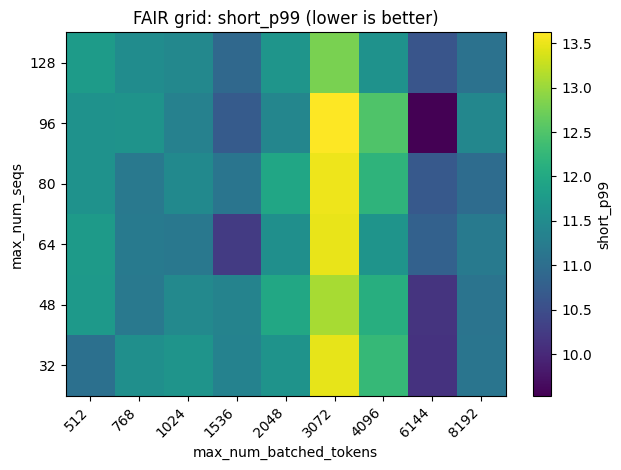

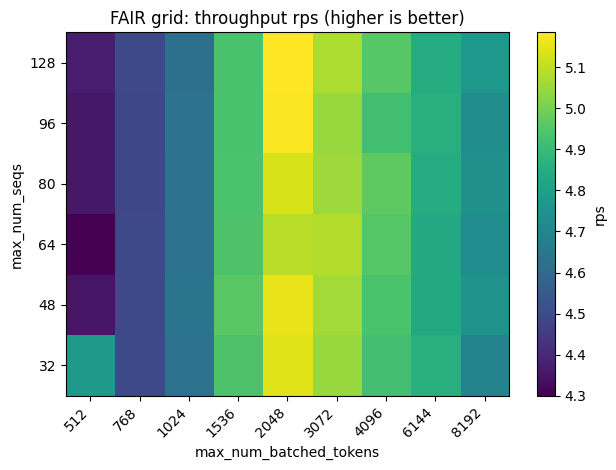

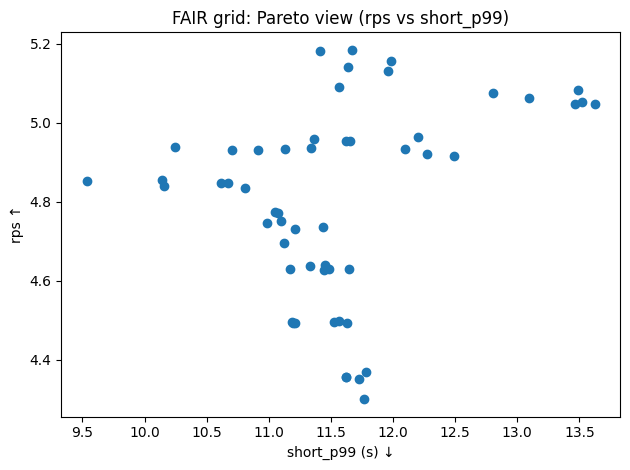

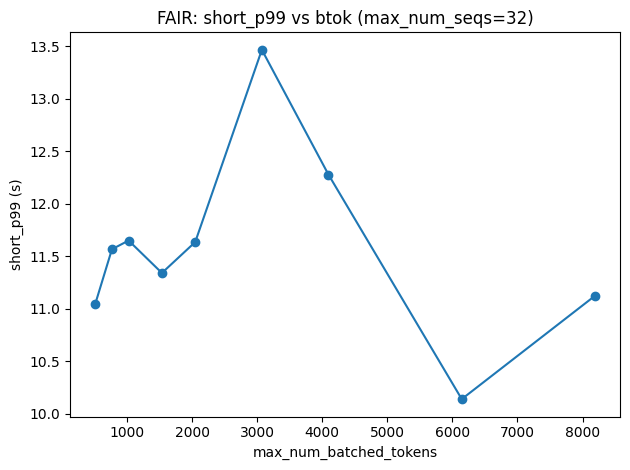

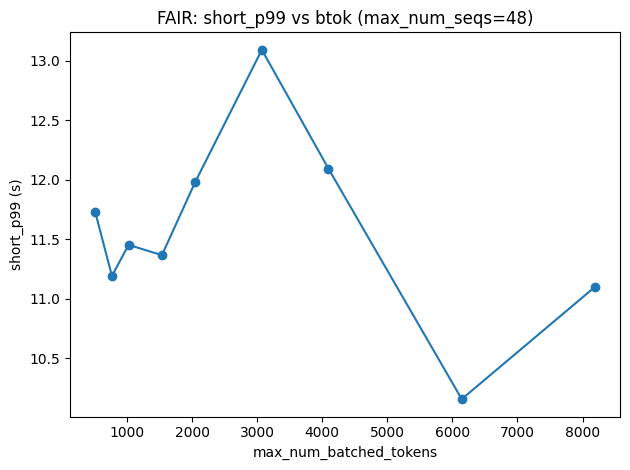

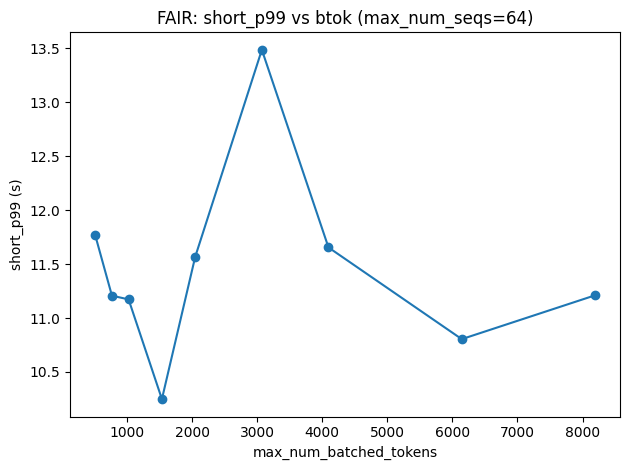

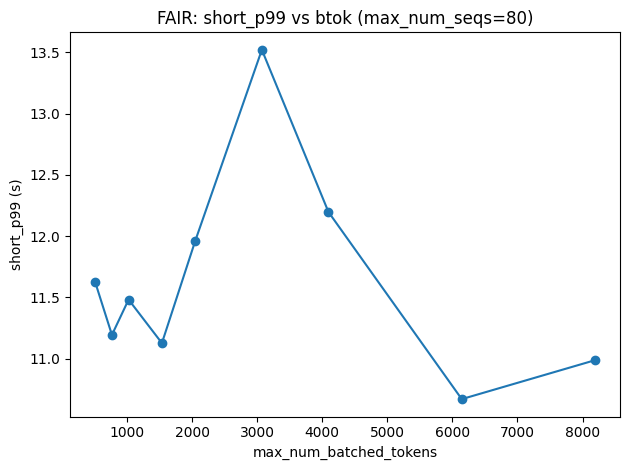

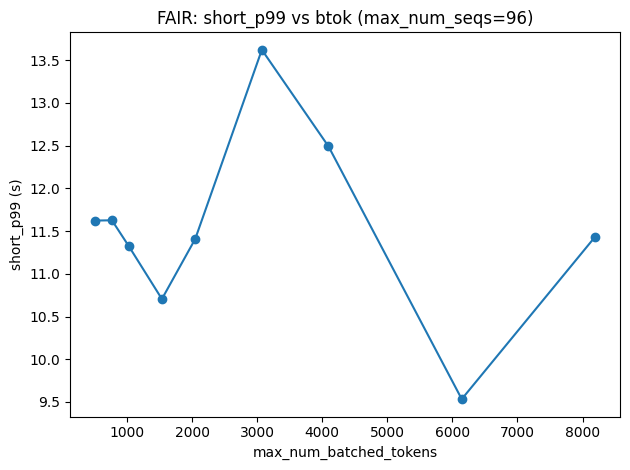

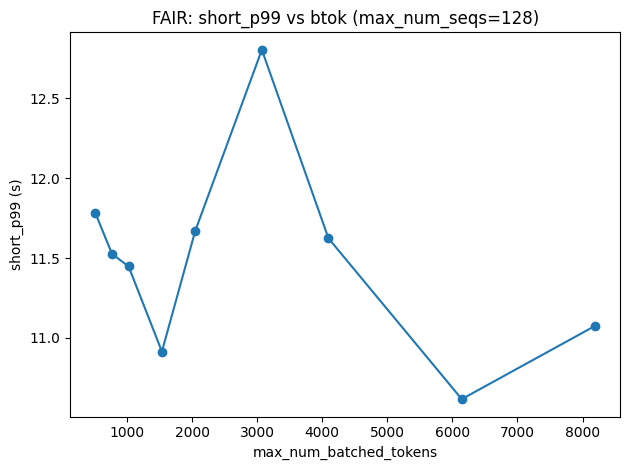

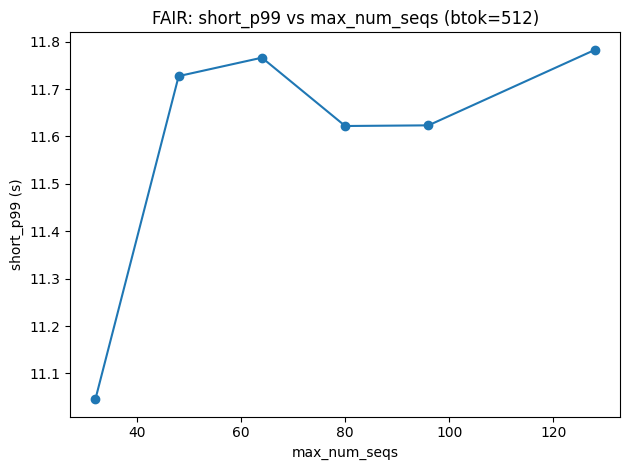

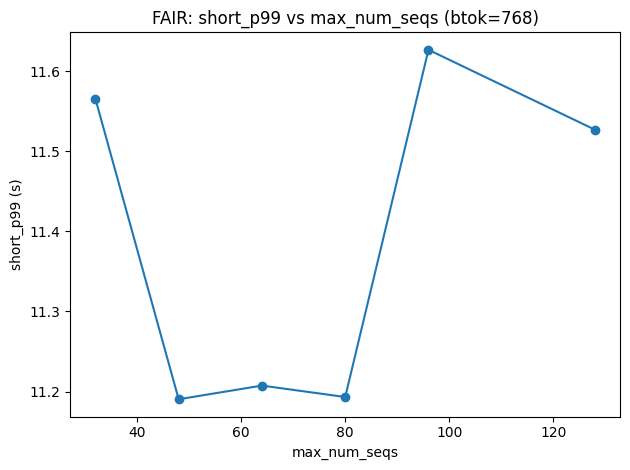

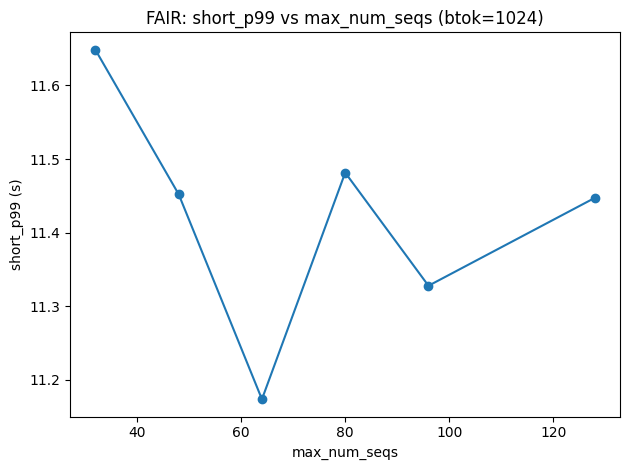

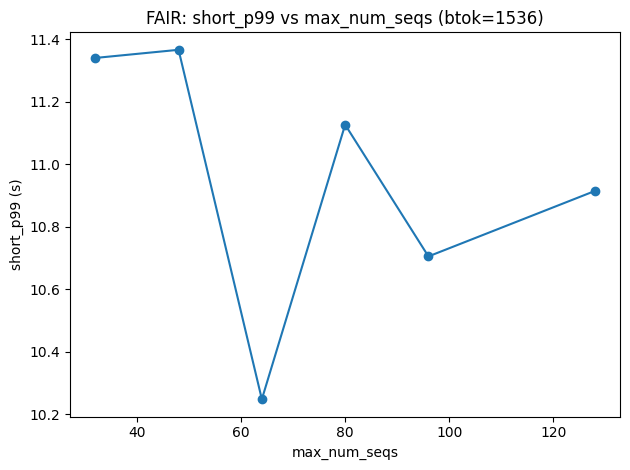

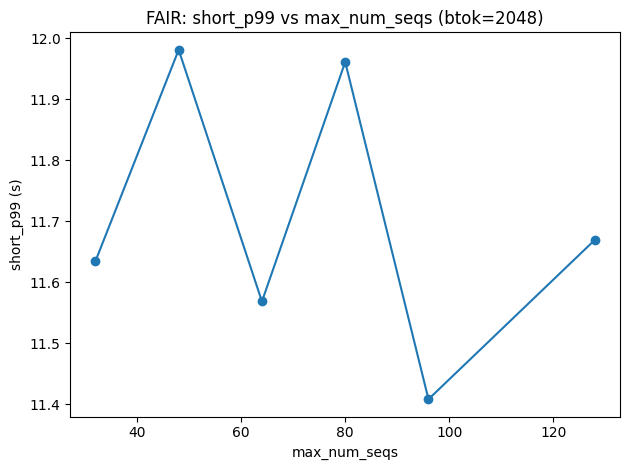

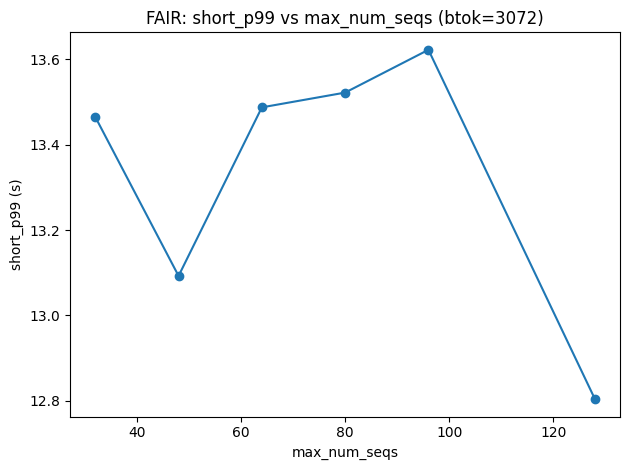

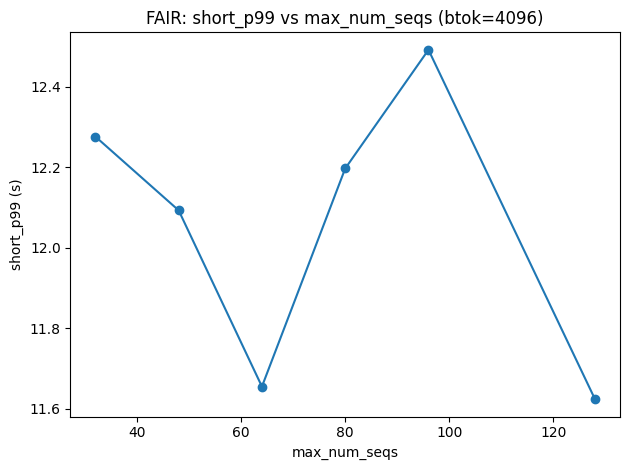

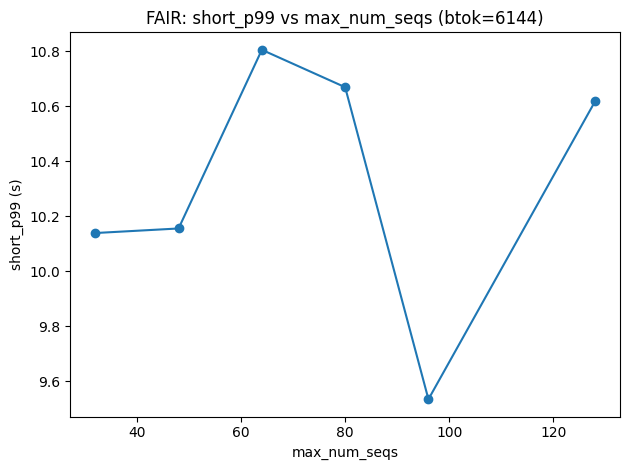

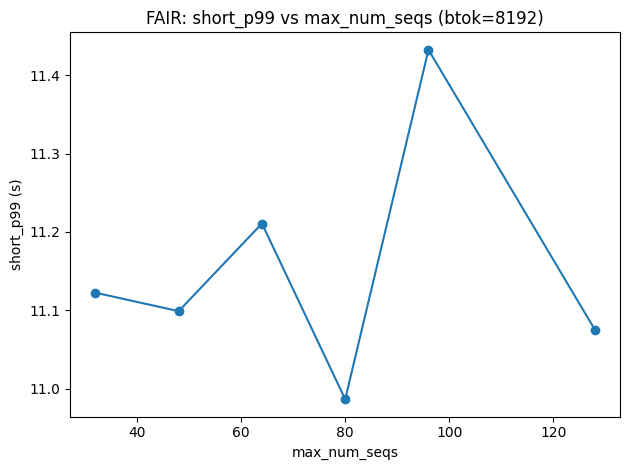

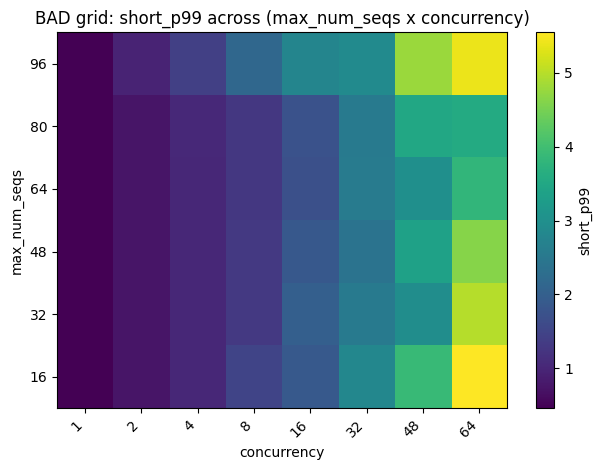

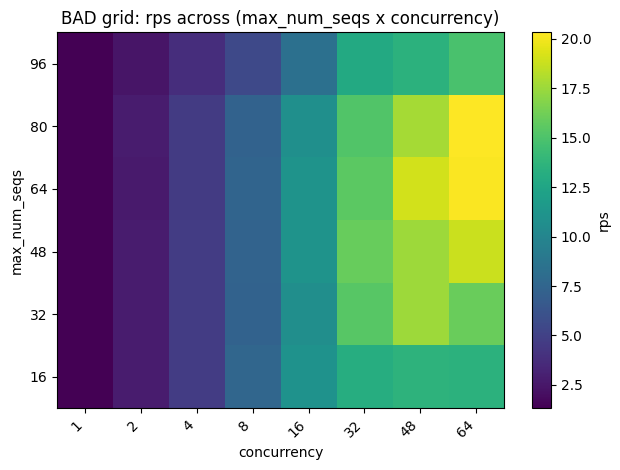

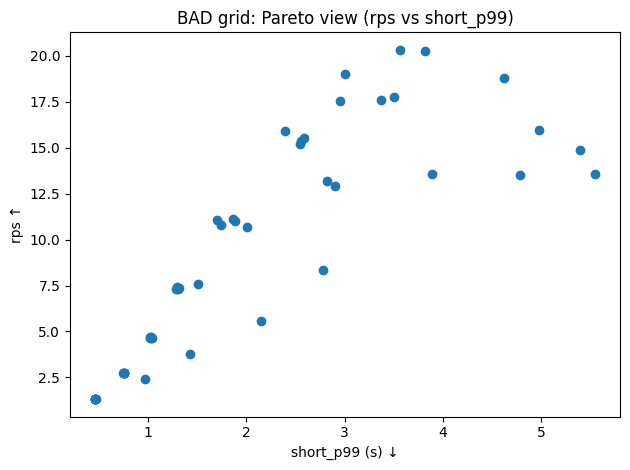


Top FAIR configs by short_p99 improvement vs BAD baseline (most negative is best):
 max_num_batched_tokens  max_num_seqs      rps  short_p50  short_p90  short_p99  delta_short_p99_vs_bad
                   6144            96 4.853246   5.389539   9.325518   9.533743               -1.084291
                   6144            32 4.855452   4.769299   9.536749  10.138313               -0.479721
                   6144            48 4.838867   5.196080   9.575984  10.154904               -0.463130
                   1536            64 4.938646   6.086197   8.717633  10.248558               -0.369476
                   6144           128 4.847778   4.985013  10.048980  10.616775               -0.001259
                   6144            80 4.848198   4.672418   9.520353  10.668710                0.050676
                   1536            96 4.931036   6.244107   9.136553  10.705149                0.087115
                   6144            64 4.834418   4.366397  10.301273  10.804741     

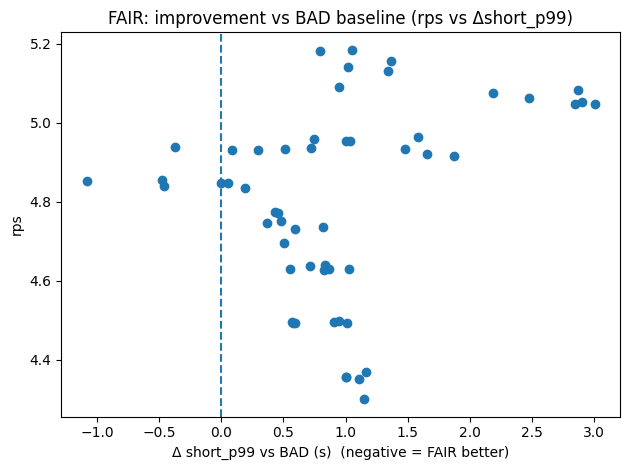

In [ ]:


FAIR_CSV = "fair_grid_checkpoint.csv"
BAD_CSV  = "bad_grid_checkpoint.csv"

fair_df = pd.read_csv(FAIR_CSV) if os.path.exists(FAIR_CSV) else None
bad_df  = pd.read_csv(BAD_CSV)  if os.path.exists(BAD_CSV) else None

def _prep(df):
    if df is None or df.empty:
        return None
    df = df.copy()

    # Keep only successful rows
    if "status" in df.columns:
        df = df[df["status"] == "ok"].copy()

    # numeric coercions
    for col in ["concurrency", "max_num_batched_tokens", "max_num_seqs"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

    for col in ["rps","short_p99","short_p90","short_p50","overall_p99","overall_p90","overall_p50",
                "long_p99","long_p90","long_p50","wall_time_s"]:

        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df


fair_df = _prep(fair_df)
bad_df  = _prep(bad_df)


print("FAIR rows:", 0 if fair_df is None else len(fair_df))
print("BAD rows :", 0 if bad_df is None else len(bad_df))


# heatmap plotter

def plot_heatmap(df, index_col, col_col, value_col, title):
    """
    index_col becomes y-axis, col_col becomes x-axis.
    """
    pivot = df.pivot_table(index=index_col, columns=col_col, values=value_col, aggfunc="mean")
    pivot = pivot.sort_index().sort_index(axis=1)

    plt.figure()

    mat = pivot.values.astype(float)

    masked = np.ma.masked_invalid(mat)

    im = plt.imshow(masked, aspect="auto", origin="lower")
    plt.colorbar(im, label=value_col)

    plt.title(title)
    plt.xlabel(col_col)
    plt.ylabel(index_col)

    # tick labels
    plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns.tolist(), rotation=45, ha="right")
    plt.yticks(ticks=np.arange(pivot.shape[0]), labels=pivot.index.tolist())
    plt.tight_layout()
    plt.show()


# FAIR plots (btok x max_num_seqs)

if fair_df is not None and {"max_num_batched_tokens","max_num_seqs"}.issubset(fair_df.columns):
    # Heatmap: short_p99
    plot_heatmap(
        fair_df,
        index_col="max_num_seqs",
        col_col="max_num_batched_tokens",
        value_col="short_p99",
        title="FAIR grid: short_p99 (lower is better)"
    )

    # Heatmap: rps
    plot_heatmap(
        fair_df,
        index_col="max_num_seqs",
        col_col="max_num_batched_tokens",
        value_col="rps",
        title="FAIR grid: throughput rps (higher is better)"
    )

    # Pareto scatter: rps vs short_p99
    plt.figure()
    plt.scatter(fair_df["short_p99"], fair_df["rps"])
    plt.xlabel("short_p99 (s) ↓")
    plt.ylabel("rps ↑")
    plt.title("FAIR grid: Pareto view (rps vs short_p99)")
    plt.tight_layout()
    plt.show()

    # Slices: short_p99 vs btok for each max_num_seqs
    for seqs in sorted(fair_df["max_num_seqs"].dropna().unique()):
        sub = fair_df[fair_df["max_num_seqs"] == seqs].sort_values("max_num_batched_tokens")
        if len(sub) < 2:
            continue
        plt.figure()
        plt.plot(sub["max_num_batched_tokens"], sub["short_p99"], marker="o")
        plt.xlabel("max_num_batched_tokens")
        plt.ylabel("short_p99 (s)")
        plt.title(f"FAIR: short_p99 vs btok (max_num_seqs={seqs})")
        plt.tight_layout()
        plt.show()

    # Slices: short_p99 vs max_num_seqs for each btok
    for btok in sorted(fair_df["max_num_batched_tokens"].dropna().unique()):
        sub = fair_df[fair_df["max_num_batched_tokens"] == btok].sort_values("max_num_seqs")
        if len(sub) < 2:
            continue
        plt.figure()
        plt.plot(sub["max_num_seqs"], sub["short_p99"], marker="o")
        plt.xlabel("max_num_seqs")
        plt.ylabel("short_p99 (s)")
        plt.title(f"FAIR: short_p99 vs max_num_seqs (btok={btok})")
        plt.tight_layout()
        plt.show()


# BAD plots (concurrency x max_num_seqs)

if bad_df is not None and {"concurrency","max_num_seqs"}.issubset(bad_df.columns):
    plot_heatmap(
        bad_df,
        index_col="max_num_seqs",
        col_col="concurrency",
        value_col="short_p99",
        title="BAD grid: short_p99 across (max_num_seqs x concurrency)"
    )

    plot_heatmap(
        bad_df,
        index_col="max_num_seqs",
        col_col="concurrency",
        value_col="rps",
        title="BAD grid: rps across (max_num_seqs x concurrency)"
    )

    # Pareto scatter: rps vs short_p99 (BAD)
    plt.figure()
    plt.scatter(bad_df["short_p99"], bad_df["rps"])
    plt.xlabel("short_p99 (s) ↓")
    plt.ylabel("rps ↑")
    plt.title("BAD grid: Pareto view (rps vs short_p99)")
    plt.tight_layout()
    plt.show()


# FAIR vs BAD baseline delta plot (optional but very meaningful)

# IfBAD baseline at concurrency=32
BAD_BASELINE_SHORT_P99 = 10.618033962269847  # from (c=32) experiment
BAD_BASELINE_RPS = None

if fair_df is not None and "short_p99" in fair_df.columns:
    fair_df2 = fair_df.copy()
    fair_df2["delta_short_p99_vs_bad"] = fair_df2["short_p99"] - BAD_BASELINE_SHORT_P99

    # show configs that beat BAD (negative delta)
    winners = fair_df2.sort_values("delta_short_p99_vs_bad").head(15)
    print("\nTop FAIR configs by short_p99 improvement vs BAD baseline (most negative is best):")
    cols = ["max_num_batched_tokens","max_num_seqs","rps","short_p50","short_p90","short_p99","delta_short_p99_vs_bad"]
    print(winners[cols].to_string(index=False))

    # Scatter: delta_short_p99 vs rps (winners are below 0)
    plt.figure()
    plt.scatter(fair_df2["delta_short_p99_vs_bad"], fair_df2["rps"])
    plt.axvline(0, linestyle="--")
    plt.xlabel("Δ short_p99 vs BAD (s)  (negative = FAIR better)")
    plt.ylabel("rps")
    plt.title("FAIR: improvement vs BAD baseline (rps vs Δshort_p99)")
    plt.tight_layout()
    plt.show()


## Conclusion: FAIR grid (btok × max-num-seqs @ c=32): interpretation (throughput ↔ tail tradeoff)

- **Baseline (BAD_unfair @ c=32):** overall p99 ≈ **11.05s**, short p99 ≈ **10.15s**, long p99 ≈ **11.06s**.  
  This is the reference point for judging whether FAIR is “better” (and *which* metric we care about).

- **Within FAIR, throughput varies modestly, but tails move a lot.**  
  - RPS stays roughly in **~4.30 → ~5.19 rps**, so the main lever is *where* you land on the **RPS vs p99** curve.

- **Best FAIR config for *long-tail control* (closest to BAD long p99):**  
  - **btok=512, max_num_seqs=32** → long p99 ≈ **11.80s** (best/lowest long p99 in the grid) with RPS ≈ **4.77**.  
  - Compared to BAD long p99 (**11.06s**), FAIR here is **~+6.7% higher** long p99, but it’s the *tightest* long-tail option among FAIR settings.

- **Best FAIR config for *protecting short requests* (lowest short p99):**  
  - **btok=6144, max_num_seqs=96** → short p99 ≈ **9.53s** with RPS ≈ **4.85**.  
  - Compared to BAD short p99 (**10.15s**), this is **~6.1% lower** (better), but it comes with a higher long p99 (≈ **13.09s**), i.e., fairness helps short requests but can tax long tails if batching is too aggressive.

- **Peak-throughput region (if you’re chasing RPS) comes with a tail cost:**  
  - Highest RPS is around **btok=2048, max_num_seqs=96–128** → RPS ≈ **5.18–5.19**.  
  - But long p99 is typically **~12.8–12.9s** and short p99 **~11.4–11.7s**, which is worse than BAD on p99 even though throughput is higher.

- **Takeaway:** there isn’t one “best” FAIR config — it depends on the SLO you want to optimize.  
  - If your SLO is **short p99**, a high-btok / moderate-seqs region (e.g., **6144 × 96**) is attractive.  
  - If your SLO is **long p99**, the most conservative FAIR corner (e.g., **512 × 32**) is safest.  
  - For production, you’d pick the **knee**: *near-peak RPS without large p99 inflation*, then validate with a final concurrency sweep.


# Code to convert notebook (.ipynb) to .pdf

In [ ]:
import json

in_path  = "/content/Copy_of_vllm_serving_project.ipynb"
out_path = "/content/Copy_of_vllm_serving_project_clean.ipynb"

with open(in_path, "r", encoding="utf-8") as f:
    nb = json.load(f)

nb.get("metadata", {}).pop("widgets", None)

for cell in nb.get("cells", []):
    if cell.get("cell_type") != "code":
        continue
    for out in cell.get("outputs", []):
        out.get("metadata", {}).pop("widgets", None)

with open(out_path, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=1)

print("Wrote cleaned notebook:", out_path)


Wrote cleaned notebook: /content/Copy_of_vllm_serving_project_clean.ipynb


In [ ]:
!pip -q install nbconvert
!jupyter nbconvert --to html "/content/Copy_of_vllm_serving_project_clean.ipynb"


[NbConvertApp] Converting notebook /content/Copy_of_vllm_serving_project_clean.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 39 image(s).
[NbConvertApp] Writing 3079951 bytes to /content/Copy_of_vllm_serving_project_clean.html
